In [1]:
import pandas as pd
import numpy as np
import string
import sqlite3
import re


from flask import Flask, request, jsonify
from nltk.tokenize import RegexpTokenizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords

In [2]:
conn = sqlite3.connect('goldlevel/goldchallenge.db')
cursor = conn.cursor()

In [3]:
cursor.execute("DROP TABLE IF EXISTS kamusalay")
conn.commit()

In [4]:
kamusalay = '''CREATE TABLE kamusalay(
                column1 TEXT,
                column2 TEXT)'''

cursor.execute(kamusalay)
conn. commit()

print("create table successful")

create table successful


In [5]:
entities = pd.read_csv('new_kamusalay.csv', encoding='Latin-1')
    
for index, row in entities.iterrows():
    cursor.execute("INSERT INTO kamusalay VALUES(?,?)", tuple(row))
    conn.commit()
    
print("create table successful")

create table successful


In [6]:
cursor.execute("DROP TABLE IF EXISTS abusive")
conn.commit()

In [7]:
abusive = '''CREATE TABLE abusive(
                column1 TEXT)'''

cursor.execute(abusive)
conn. commit()

print("create table successful")

create table successful


In [8]:
entities = pd.read_csv('abusive.csv', encoding='Latin-1')
    
for index, row in entities.iterrows():
    cursor.execute("INSERT INTO abusive VALUES(?)", tuple(row))
    conn.commit()
    
print("create table successful")

create table successful


In [9]:
cursor.execute("DROP TABLE IF EXISTS abusivetext")
conn.commit()

In [10]:
abusivetext = '''CREATE TABLE abusivetext(
                column1 TEXT, column2 VARCHAR(255), column3 VARCHAR(255),
                column4 VARCHAR(255), column5 VARCHAR(255),
                column6 VARCHAR(255), column7 VARCHAR(255),
                column8 VARCHAR(255), column9 VARCHAR(255),
                column10 VARCHAR(255), column11 VARCHAR(255),
                column12 VARCHAR(255), column13 VARCHAR(255))'''

cursor.execute(abusivetext)
conn. commit()

print("create table successful")

create table successful


In [11]:
entities = pd.read_csv('data.csv', encoding='Latin-1')
    
for index, row in entities.iterrows():
    cursor.execute("INSERT INTO abusivetext VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?)", tuple(row))
    conn.commit()
    
print("create table successful")

create table successful


In [12]:
cursor.execute("DROP TABLE IF EXISTS cleaningtext")
conn.commit()

In [13]:
cleaningtext = '''CREATE TABLE cleaningtext(
                        cleaningtext_hasil TEXT)'''

cursor.execute(cleaningtext)
conn. commit()

print("create table successful")

create table successful


In [14]:
app = Flask(__name__)

from flask import request
from flasgger import Swagger, LazyString, LazyJSONEncoder
from flasgger import swag_from

app.json_encoder = LazyJSONEncoder
swagger_template = dict(
info = {
    'title': LazyString(lambda: 'Data Science Challenge'),
    'version': LazyString(lambda: '1.0.0'),
    'description': LazyString(lambda: 'Gold Challenge'),
    },
    host = LazyString(lambda: request.host)
)

swagger_config = {
    "headers": [],
    "specs": [
        {
            "endpoint": 'docs',
            "route": '/docs.json',
        }
    ],
    "static_url_path": "/flasgger_static",
    "swagger_ui": True,
    "specs_route": "/docs/"
}


swagger = Swagger(app, template=swagger_template,             
                  config=swagger_config)

@swag_from("/Users/bianda/Desktop/DSC/API-Binar/docs/hello_world.yml", methods=['GET'])
@app.route('/', methods=['GET'])
def hello_world():
    json_response = {
        'status_code': 200,
        'description': "Menyapa Hello World",
        'data': "Hello World",
    }

    response_data = jsonify(json_response)
    return response_data

@swag_from("/Users/bianda/Desktop/DSC/API-Binar/docs/text_processing.yml", methods=['POST'])
@app.route('/text-processing', methods=['POST'])
def text_processing():

    text = request.form.get('text')
    
    #mengubah ke huruf kecil
    cleaned_text_lower = text.lower()
    
    #remove RT
    cleaned_text_rt = re.sub(r'^rt[\s]+', ' ', cleaned_text_lower)
    
    #remove user
    cleaned_text_user = re.sub(r'^user[\s]+', '', cleaned_text_rt)
    
    #remove url
    cleaned_text_url = re.sub(r'<.*?>', r' ', cleaned_text_user)
    
    #remove tandabaca
    cleaned_text_punct = re.sub(r'[^\w\s\d]', ' ', cleaned_text_url)
    
    #remove dem
    cleaned_text_dem = re.sub(r'[\\x]+[a-z0-9]{2}', '', cleaned_text_punct)
    
    #remove number
    cleaned_text_num = re.sub(r'\d+', ' ', cleaned_text_dem)
    
    # Mengganti karakter selain huruf dan angka dengan spasi
    cleaned_text_alpha = re.sub(r'[^a-zA-Z]', ' ', cleaned_text_num)
    
    # Menghilangkan white space tambahan 
    # .split() = memisahkan teks menjadi spasi, ''.join() = menggabungkan potongan
    cleaned_text_final = ' '.join(cleaned_text_alpha.split())
    
    def read_replacing_word(cursor):
        cursor.execute("SELECT column1, column2 FROM kamusalay")
        rows = cursor.fetchall()
        replacing_word_dict = {}
        for row in rows:
            replacing_word_dict[row[0]] = row[1]
        return replacing_word_dict

    def replacing_term(replaceword, replacing_word_dict):
        return [replacing_word_dict[term] if term in replacing_word_dict else term for term in replaceword]
    
    conn = sqlite3.connect('goldlevel/goldchallenge.db')
    cursor = conn.cursor()
        
    replacing_word_dict = read_replacing_word(cursor)
    replaced_text = replacing_term(cleaned_text_final.split(), replacing_word_dict)
    
    def read_abusive_word(cursors):
        cursors.execute("SELECT column1 FROM abusive")
        rows = cursors.fetchall()
        abusive_word = [row[0] for row in rows]
        return abusive_word
    
    def remove_abusive(replaced_text, abusive_word):
        words = [word for word in replaced_text if word.lower() not in abusive_word]
        return words
    
    conn = sqlite3.connect('goldlevel/goldchallenge.db')
    cursors = conn.cursor()
        
    abusive_word = read_abusive_word(cursors)

    stopword_remove = remove_abusive(replaced_text, abusive_word)
    print("stopword_remove:", stopword_remove)
    
    json_response = {
        'status_code': 200,
        'description': "Teks yang sudah diproses",
        'data': ' '.join(stopword_remove),  
    }

    response_data = jsonify(json_response)
    return response_data

@swag_from("/Users/bianda/Desktop/DSC/API-Binar/docs/text_processing_file.yml", methods=['POST'])
@app.route('/text-processing-file', methods=['POST'])
def text_processing_file():

    # Upladed file
    file = request.files.getlist('file')[0]

    # Import file csv ke Pandas
    df = pd.read_csv(file, encoding='latin-1')

    # Ambil teks yang akan diproses dalam format list
    texts = df['Tweet'].to_list()

    # Lakukan cleansing pada teks
    cleaned_text = []
    for text in texts:
         
        #mengubah ke huruf kecil
        text_lower = text.lower()    
            
        #remove RT
        text_rt = re.sub(r'^rt[\s]+', ' ', text_lower)
    
        #remove user
        text_user = re.sub(r'^user[\s]+', '', text_rt)
    
        #remove url
        text_url = re.sub(r'<.*?>', r' ', text_user)
    
        #remove tandabaca
        text_punct = re.sub(r'[^\w\s\d]', ' ', text_url)
    
        #remove dem
        text_dem = re.sub(r'[\\x]+[a-z0-9]{2}', '', text_punct)
    
        #remove number
        text_num = re.sub(r'\d+', ' ', text_dem)
        
        # Remove hashtag
        text_hashtag = re.sub(r'#\w+', ' ', text_num)
    
        # Mengganti karakter selain huruf dan angka dengan spasi
        text_alpha = re.sub(r'[^a-zA-Z]', ' ', text_hashtag)
          
        #remove white space
        text_space = ' '.join(text_alpha.split())
        
        def read_replacing_word(cursor):
            cursor.execute("SELECT column1, column2 FROM kamusalay")
            rows = cursor.fetchall()
            replacing_word_dict = {}
            for row in rows:
                replacing_word_dict[row[0]] = row[1]
            return replacing_word_dict

        def replacing_term(replaceword, replacing_word_dict):
            return [replacing_word_dict[term] if term in replacing_word_dict else term for term in replaceword]
    
        conn = sqlite3.connect('goldlevel/goldchallenge.db')
        cursor = conn.cursor()
        
        replacing_word_dict = read_replacing_word(cursor)
        replaced_text = replacing_term(text_space.split(), replacing_word_dict)
         
        def read_abusive_word(cursors):
            cursors.execute("SELECT column1 FROM abusive")
            rows = cursors.fetchall()
            abusive_word = [row[0] for row in rows]
            return abusive_word
    
        def remove_abusive(replaced_text, abusive_word):
            words = [word for word in replaced_text if word.lower() not in abusive_word]
            return words
    
        conn = sqlite3.connect('goldlevel/goldchallenge.db')
        cursors = conn.cursor()
        
        abusive_word = read_abusive_word(cursors)

        abusive_remove = remove_abusive(replaced_text, abusive_word)
        print("abusive_remove:", abusive_remove)    
        
        cleaned_text.append(' '.join(map(str, abusive_remove)))
        
        df = pd.DataFrame({'cleaned_text': cleaned_text})
        
        conn = sqlite3.connect('goldlevel/goldchallenge.db')
        df.to_sql('cleaningtext', conn, if_exists='replace', index=False)
    
    json_response = {
        'status_code': 200,
        'description': "Teks yang sudah diproses",
        'data': (cleaned_text),
    }

    response_data = jsonify(json_response)
    return response_data

if __name__ == '__main__':
   app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [04/Dec/2023 23:16:01] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2023 23:16:05] "GET /docs HTTP/1.1" 308 -
127.0.0.1 - - [04/Dec/2023 23:16:05] "GET /docs/ HTTP/1.1" 200 -
127.0.0.1 - - [04/Dec/2023 23:16:05] "GET /docs.json HTTP/1.1" 200 -


abusive_remove: ['di saat', 'semua', 'cowok', 'berusaha', 'melacak', 'perhatian', 'gue', 'kamu', 'lantas', 'remehkan', 'perhatian', 'yang', 'gue', 'kasih', 'khusus', 'ke', 'kamu', 'basic', 'kamu', 'cowok']
abusive_remove: ['pengguna', 'pengguna', 'siapa', 'yang', 'telat', 'memberi', 'tau', 'kamu', 'gue', 'bergaul', 'dengan', 'cigax', 'jifla', 'calis', 'sama', 'siapa', 'itu', 'licew', 'juga']
abusive_remove: ['kadang', 'aku', 'berpikir', 'kenapa', 'aku', 'tetap', 'percaya', 'pada', 'tuhan', 'padahal', 'aku', 'selalu', 'jatuh', 'berkali', 'kali', 'kadang', 'aku', 'merasa', 'tuhan', 'itu', 'meninggalkan', 'aku', 'sendirian', 'ketika', 'orang tuaku', 'berencana', 'berpisah', 'ketika', 'kakakku', 'lebih', 'memilih', 'jadi', 'kristen', 'ketika', 'aku', 'anak', 'ter']
abusive_remove: ['pengguna', 'aku', 'itu', 'aku', 'dan', 'ku', 'tau', 'matamu', 'tapi', 'dilihat', 'dari', 'mana', 'itu', 'aku']
abusive_remove: ['pengguna', 'kaum', 'sudah', 'kelihatan', 'dongoknya', 'dari', 'awal', 'tambah', '

abusive_remove: ['wkwk', 'lowo']
abusive_remove: ['takabur', 'bisa', 'lahir', 'dari', 'siapa', 'saja', 'penguasa', 'rakyat', 'ulama', 'maupun', 'cendikia', 'bahkan', 'makhluk', 'yang', 'alim', 'amp', 'telah', 'beribadah', 'beratus', 'tahun', 'dilaknat', 'karena', 'hasud', 'takaburnya', 'apalagi', 'hanya', 'seorang', 'ahli', 'ilmu', 'filsafat', 'yang', 'tidak', 'failosof', 'mari', 'kita', 'demo', 'diri', 'sendi']
abusive_remove: ['a', 'orang', 'yang', 'suka', 'ke', 'konser', 'konser', 'sedikit', 'boros']
abusive_remove: ['sampai', 'kapan', 'makan', 'racun', 'banyak', 'ulama', 'yang', 'mengatakan', 'hukum', 'rokok', 'mubah', 'dan', 'ada', 'juga']
abusive_remove: ['susilo', 'bambang', 'yudhoyono', 'presiden', 'ri', 'ke', 'meminta', 'khofifah', 'emil', 'untuk', 'dekat', 'dengan', 'masyarakat', 'no', 'bisa', 'bagus', 'khofifahemilnomer']
abusive_remove: ['sudah', 'biasa', 'kali', 'gue', 'penggemar korea pop', 'tapi', 'kalau', 'mengomong', 'sama', 'teman', 'gue', 'idol', 'gue']
abusive_remov

abusive_remove: ['ian']
abusive_remove: ['pengguna', 'mengakuinya', 'orang', 'pintar', 'dan', 'beragama', 'memangnya', 'agama', 'mana', 'yang', 'memperbolehkan', 'menista', 'dan', 'menghujat', 'orang', 'lain', 'jangankan', 'orang', 'orang', 'yang', 'maaf', 'sejak', 'lahir', 'sekalipun', 'dia', 'kita', 'harus', 'hargai', 'sebagai', 'sesama', 'ciptaan', 'tuhan', 'ingat', 'itu', 'juga', 'pintar', 'dan', 'sangat', 'licik']
abusive_remove: ['pendaftaran', 'calon presiden', 'untuk', 'pemilihan presiden', 'saja', 'belum', 'dibuka', 'sampai', 'agustus', 'yang', 'normatif', 'begini', 'politikus', 'partai demokrasi indonesia perjuangan', 'masih', 'belum', 'paham', 'ganti presiden']
abusive_remove: ['sih', 'sudah', 'tau', 'pemerintah', 'ini', 'bobrok', 'koruptor', 'bisa', 'pimpinan', 'sidang', 'dewan perwakilan rakyat', 'paya', 'uniform resource locator']
abusive_remove: ['dari', 'dulu', 'kenapa', 'bapak', 'gue', 'kalau', 'ke', 'mantan', 'mantan', 'gue', 'selalu', 'merasa', 'sedih', 'sampai', 'ke

abusive_remove: ['giat', 'bhayangkara pembina keamanan dan ketertiban masyarakat', 'brigadir polisi', 'manajemen berbasis sekolah', 'sihombing', 'pada', 'hari', 'ini', 'rabu', 'april', 'melaksanakan', 'sambang', 'desa', 'dan', 'tatap', 'muka', 'sekaligus', 'memantau', 'keamanan dan ketertiban masyarakat', 'menuju', 'pilihan kepala daerah', 'di', 'desa', 'lobusiregar', 'i', 'tepatnya', 'di rumah', 'rudi', 'panjaitan', 'helman', 'siahaan', 'dan', 'hotman', 'siahaan']
abusive_remove: ['sayang', 'banget', 'ya', 'melihat', 'perempuan', 'kayak', 'begini', 'tidak', 'ada', 'status', 'apa', 'tetapi', 'sudah', 'menempel', 'sama', 'laki', 'laki', 'sana', 'sini', 'aduh', 'nagita', 'slavina', 'blak', 'blak', 'sebut', 'ayu', 'ting', 'ting', 'viva', 'uniform resource locator']
abusive_remove: ['jangan', 'lupa', 'juga', 'kang', 'umat', 'katolik', 'dan', 'minoritas', 'lainnya', 'diperhatikan', 'gubernur', 'untuk', 'semua', 'golongan', 'bukan', 'satu', 'golongan']
abusive_remove: ['pengguna', 'pengguna'

abusive_remove: ['tau', 'dong', 'bau', 'baunya', 'sudah', 'keciri', 'ini', 'buluk']
abusive_remove: ['kayak', 'memegang', 'bukan']
abusive_remove: ['guru', 'tk', 'darma', 'wanita', 'persatuan', 'desa', 'plumbon', 'porong', 'deklarasi', 'anti', 'hoaks', 'ujaran', 'kebencian', 'isu', 'sarah', 'dan', 'mendukung', 'pilihan kepala daerah', 'damai']
abusive_remove: ['seram', 'mainnya', 'begituan']
abusive_remove: ['kayaknya', 'bisa', 'atau', 'cuma', 'bank', 'tertentu', 'bilang', 'saja', 'mau', 'jual', 'uang', 'tukar', 'ke', 'rupiah']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'yaman', 'nih', 'dan', 'setahun', 'lagi', 'gue', 'deportasi', 'kamu']
abusive_remove: ['hati', 'hati', 'berita', 'pilihan kepala daerah', 'yang', 'berbau', 'hoaks', 'madiun', 'madiun today', 'thmadiun', 'kotak karismatik madiun', 'tolak cukai ilegal', 'kunjungi', 'juga']
abusive_remove: ['anak', 'ya', 'ini', 'pengguna']
abusive_remove: ['sudah', 'ketahuan', 'hoaks', 'ya', 'fahri', 'makanya', 'kalau', 'ambil', 

abusive_remove: ['pengguna', 'pengguna', 'sama', 'saja', 'lah', 'lae', 'meskipun', 'sudah', 'turun', 'menurun', 'tetapi', 'ideologi', 'partai komunis indonesia', 'selalu', 'melekat', 'di', 'jiwa', 'mereka']
abusive_remove: ['pengguna', 'pengguna', 'saya', 'juga', 'kesal', 'kalau', 'ada', 'yang', 'merokok', 'sambil', 'naik', 'motor', 'iyakan', 'kadang', 'pengap', 'kalau', 'ditutup', 'terus', 'apalagi', 'macet']
abusive_remove: ['pengguna', 'sudah', 'meminta', 'maaf', 'pengguna', 'bro', 'dan', 'enak', 'banget', 'rasan', 'mereka', 'sebar', 'hoaks', 'meminta', 'maaf', 'sebar', 'hoaks', 'lagi', 'meminta', 'maaf', 'lagi', 'dan', 'mesti', 'di', 'sapu', 'dulu', 'pengguna', 'biar', 'jera', 'nih', 'orang', 'uniform resource locator']
abusive_remove: ['halo', 'warga', 'jakarta', 'wakil', 'kepala', 'dinas penanaman modal dan pelayanan terpadu satu pintu', 'provinsi', 'daerah khusus ibukota', 'jakarta', 'bapak', 'denny', 'wahyu', 'haryanto', 'mewakili', 'wakil', 'gubernur', 'provinsi', 'daerah khus

abusive_remove: ['serunya', 'pesta', 'budaya', 'derau', 'di', 'kutai', 'kartanegara']
abusive_remove: ['pengguna', 'ada', 'yang', 'mau', 'kontaknya', 'retweet', 'sekarang', 'ya', 'banyak', 'banget', 'kenalan', 'tante', 'jilboobs', 'nini', 'namanya', 'tante', 'dea', 'o']
abusive_remove: ['debat', 'publik', 'bukan', 'ajang', 'pembuktian', 'siapa', 'pintar', 'atau', 'sebaliknya', 'juga', 'bukan', 'ruang', 'akademik', 'untuk', 'pamer', 'siapa', 'paling', 'indah', 'setiap', 'orang', 'punya', 'kekuatan', 'dan', 'kelemahan', 'bukan', 'hanya', 'soal', 'dirinya', 'itu', 'egosentris', 'namanya', 'ini', 'lebih', 'pada', 'soal', 'kekuatan', 'menahan', 'l']
abusive_remove: ['duduki', 'istana', 'negara', 'sekalian', 'lengserkan', 'jokowi', 'salam', 'tahun', 'pengguna']
abusive_remove: ['pengguna', 'wah', 'hebatnya', 'pak', 'pengguna', 'yang', 'lagi', 'sibuk', 'pencitraan', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'baca', 'nih']
abusive_remove: ['bagi', 'anda', 'mungkin', 'tidak', 'apa', 'tapi

abusive_remove: ['pengguna', 'makin', 'kepanasan', 'jadi', 'makin', 'ngawur']
abusive_remove: ['amin', 'semoga', 'kalian', 'bertiga', 'bisa', 'jadi', 'menampilkan', 'yang', 'terbaik', 'dan', 'menyumbangan', 'medali', 'buat', 'sumatra selatan']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna']
abusive_remove: ['gubernur zaman now', 'gusipulputi', 'ganjar yasin', 'djarotsihar', 'hasananton', 'kosterace', 'nurdinsudirman', 'karolingidot', 'rt', 'pengguna', 'keanekaragaman', 'budaya', 'suku', 'agama', 'itulah', 'sesungguhnya', 'kekayaan', 'kita', 'tutur', 'djarot', 'di', 'hadapan', 'peserta', 'rakercabsu']
abusive_remove: ['sudah', 'jangan', 'terlalu', 'banyak', 'membingkai', 'cukup', 'menjadikannya', 'pelajaran', 'saja', 'agar', 'hidup', 'kita', 'semakin', 'baik', 'pada', 'masa', 'yang', 'akan', '

abusive_remove: ['atau', 'seperti', 'hujan', 'lebat', 'dari', 'langit', 'bersama', 'dengan', 'gelap', 'gelita', 'dan', 'guruh', 'serta', 'kilat', 'mereka', 'menyumbat', 'jarinya', 'ke', 'dalam', 'telinga', 'masing', 'masing', 'dari', 'mendengar', 'suara', 'petir', 'ke ranah', 'mereka', 'takut', 'mati', 'masakan', 'mereka', 'boleh', 'terlepas', 'sedang', 'allah', 'me']
abusive_remove: ['cerdas', 'dan', 'konseptual']
abusive_remove: ['namaku', 'baik', 'yoon', 'lagi', 'dan', 'ucapan', 'terputus', 'seiring', 'dia', 'menyergap', 'mata', 'yang', 'terasa', 'mengantuk', 'sedikit', 'demi', 'sedikit', 'gigit', 'bibirnya', 'ragu', 'karena', 'dia', 'ingin', 'menggapai', 'gelas', 'sekali', 'lagi', 'untuk', 'meminum', 'sebagaimana', 'wine', 'yang', 'ditinggal', 'di', 'sama']
abusive_remove: ['bismillah', 'melayu', 'raya', 'tanah', 'melayu', 'macam', 'macam', 'nama', 'kita', 'pernah', 'dengar', 'tapi', 'pernah', 'tak', 'kita', 'kaji', 'besar', 'mana', 'jajahan', 'tanah', 'melayu', 'dulu', 'dalam', 't

abusive_remove: ['sudah', 'lebih', 'dari', 'tahun', 'freeport', 'di', 'kuasai', 'oleh', 'pihak', 'baru', 'di', 'masa', 'pemerintahan', 'jokowi', 'serta', 'pak', 'jonan', 'menjadi', 'menteri', 'energi dan sumber daya mineral', 'freeport', 'kita', 'ambil', 'alih', 'sahamnya', 'jonan jos']
abusive_remove: ['as', 'clara', 'dan', 'anak', 'pintar', 'dan', 'dan', 'paling', 'kocak', 'dan', 'cantik', 'tapi', 'idot', 'dan', 'tak tau', 'malu', 'dan', 'urat', 'malu', 'putus', 'dan', 'butt', 'dia', 'muka', 'nya', 'imut', 'banget']
abusive_remove: ['menteri agama', 'pengguna', 'meminta', 'riset', 'perguruan tinggi keagamaan islam negeri', 'jangan', 'hanya', 'berorientasi', 'publikasi', 'artikel', 'di', 'scopus', 'dan', 'sejenisnya', 'namun', 'keluarannya', 'harus', 'bisa', 'jawab', 'tantangan', 'umat', 'islam', 'perguruan tinggi keagamaan islam negeri', 'perlu', 'buat', 'pangkalan', 'data', 'sebagai', 'rujukan', 'pembangunan', 'misal', 'database', 'ulama', 'nusantara', 'sehingga', 'tidak']
abusive_r

abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'baru', 'tahun', 'sudah', 'sebegitu', 'ya', 'bentar', 'lagi', 'lewat', 'utang', 'susilo bambang yudhoyono', 'njiiieng']
abusive_remove: ['mungkin', 'masih', 'banyak', 'masyarakat', 'tionghoa', 'yang', 'lebih', 'pancasialis', 'dari', 'pada', 'orang', 'jawa', 'cuma', 'enggak', 'terekspos', 'saja', 'contoh', 'nyata', 'pak', 'kwik', 'ekonom', 'dan', 'ustaz', 'felix', 'siauw']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'freeport', 'tak akan', 'berdiam', 'saja', 'setelah', 'negosiasi', 'kalah']
abusive_remove: ['negara', 'kayak', 'menipu', 'bocah', 'sekolah dasar', 'saja', 'dokumennya', 'hilang', 'huh']
abusive_remove: ['allah', 'subhanahu wa taala', 'yang', 'disembah', 'biadab', 'ya', 'percuma']
abusive_remove: ['pengguna', 'ogah', 'prabowo', 'pak', 'gatot', 'baru', 'oke']
abusive_remove: ['perbanyaklah', 'memb

abusive_remove: ['peresmian', 'dan', 'pemberkatan', 'gereja', 'katolik', 'hati', 'kudus', 'yesus', 'batu', 'gantung', 'ambon']
abusive_remove: ['tidak', 'melihat', 'tapi', 'merasa', 'wkwk', 'dan', 'gue', 'merasa', 'lagi', 'tot', 'sama']
abusive_remove: ['pengguna', 'eh', 'ada', 'wartawan', 'selandia', 'baru', 'rasa', 'dan', 'dibuat', 'berita', 'oleh', 'disebar', 'di', 'kekasih', 'konferensi', 'pers', 'tidak', 'dilakukan']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pencitraan', 'kamu', 'ah', 'prabowo', 'masih', 'tidur']
abusive_remove: ['ustaz', 'subki', 'al', 'bughury', 'si', 'sos', 'i', 'saja', 'mendukung', 'pilihan kepala daerah', 'damai', 'di', 'kabupaten', 'sinjai', 'tanpa', 'hoaks', 'ujaran', 'kebencian', 'dan', 'isu', 'sara', 'kalau', 'anda', 'pengguna', 'pengguna', 'pengguna']
abusive_remove: ['pengguna', 'retweet', 'sensasi', 'dengan', 'cewek', 'cantik', 'berhijab', 'dan', 'dan', 'part', 'dan', 'dan', 'blowjob', 'hijab', 'ngentot orang berhijab', 'sepong 

abusive_remove: ['kenapa', 'pengguna', 'bicaranya', 'sesuatu', 'yang', 'remeh', 'temeh', 'surat pemberitahuan tahunan', 'masalah', 'kalajengking', 'karena', 'beliau', 'tau', 'oposisinya', 'surat pemberitahuan tahunan', 'pengguna', 'itu', 'pasti', 'nyinyir', 'jadi', 'stres', 'dan', 'strok', 'sendiri', 'karena', 'memang', 'dosen', 'tidak', 'laku', 'gede', 'hasil', 'karya', 'tidak', 'ada', 'bahkan', 'anak', 'asuhnya', 'mayor']
abusive_remove: ['keanekaragaman', 'budaya', 'suku', 'agama', 'itulah', 'sesungguhnya', 'kekayaan', 'kita', 'tutur', 'djarot', 'di', 'hadapan', 'peserta', 'rapat kerja cabang khusus', 'partai demokrasi indonesia', 'perjuangan', 'kota', 'gunung sitoli', 'gubernur zaman now', 'djarotsihar', 'sumutpilih', 'keren', 'djarot sihar menang', 'gunung sitoli', 'partai demokrasi indonesia perjuangan']
abusive_remove: ['pengguna', 'pengguna', 'sekalian', 'kalau', 'di', 'pasar', 'menemukan', 'tukang', 'jualan', 'pisang', 'memaki', 'saja', 'abangnya', 'gara', 'gara', 'dia', 'pend

abusive_remove: ['lagi', 'mengocok', 'sayang']
abusive_remove: ['pengguna', 'babang', 'dengan', 'tebal', 'rimbun', 'colinya', 'bikin', 'mengiler', 'pengguna', 'pengguna', 'pengguna', 'pengguna']
abusive_remove: ['gue', 'baru', 'menyadari', 'kalau', 'situ', 'baru', 'mengikuti balik', 'saya', 'kelamaan', 'umrah', 'ya', 'mana', 'oleh', 'oleh', 'makkah', 'iya', 'salam', 'kenal', 'dav']
abusive_remove: ['bubarkan', 'saja', 'komisi pemberantasan korupsi', 'biar', 'leluasa', 'para', 'koruptor', 'memperkaya', 'diri', 'di', 'negeri', 'ini']
abusive_remove: ['pengguna', 'pengguna', 'susah', 'bang', 'jawa', 'sudah', 'dipegang', 'jokowi', 'dia', 'semua', 'sedih', 'sih']
abusive_remove: ['cuma', 'ini', 'orang', 'kayak', 'dia', 'berani', 'tampil', 'di', 'layar', 'kaca', 'mohon', 'segera', 'ambil', 'tindakan', 'pengguna', 'pengguna']
abusive_remove: ['pengguna', 'memang', 'otoriter', 'buktinya', 'pengguna', 'selalu', 'ott', 'padahal', 'dari', 'partai', 'politiknya', 'sendiri', 'banyak', 'ya', 'penggu

abusive_remove: ['sepandai', 'pandainya', 'kita', 'menyembunyikan', 'pasti', 'akan', 'tercium', 'juga', 'baunya', 'haha']
abusive_remove: ['pengguna', 'pengguna', 'terus', 'islam', 'tidak', 'punya', 'kitab', 'suci', 'kok', 'logika', 'kamu', 'jatuh', 'ke', 'palung', 'jawa', 'begitu', 'modelnya', 'tau', 'arti', 'kata', 'fiksi', 'menurut', 'kamus besar bahasa indonesia', 'belum']
abusive_remove: ['pengguna', 'mungkin', 'kata', 'pengguna', 'yang', 'dilakukan', 'raja', 'salman', 'hanya', 'pencitraan']
abusive_remove: ['untuk', 'mengedukasi', 'manusya', 'seperti', 'kamu', 'misalnya']
abusive_remove: ['saya', 'muslim', 'katolik', 'buddha', 'hindu', 'kristen', 'jawa', 'sumatra', 'papua', 'tidak', 'masalah', 'konsekuensinya', 'anda', 'bukan', 'muslim', 'jawa', 'dan seterusnya', 'karena', 'itu', 'semua', 'kebinekaan', 'kita', 'tapi', 'kalau', 'saya', 'negara kesatuan republik indonesia', 'pancasila', 'konsekuensinya', 'selain', 'itu', 'bukan', 'orang', 'indonesia']
abusive_remove: ['pengguna', '

abusive_remove: ['secara', 'teknis', 'dia', 'baik', 'mau', 'kembalikan', 'kamu', 'straight', 'tapi', 'cuma', 'cara', 'dia', 'saja', 'yang', 'tidak', 'etis', 'gue', 'bilang', 'sama', 'kamu', 'bagaimana', 'sakitnya', 'mantan', 'ketika', 'putus', 'sama', 'kamu', 'dia', 'ada', 'di', 'jalur', 'yang', 'salah', 'he', 'bro', 'gue', 'mengalami', 'kok', 'setelah', 'gue', 'sama', 'mantan', 'gue', 'putus', 'mantan', 'gu']
abusive_remove: ['jualan', 'kaos', 'tidak', 'laku', 'kembali', 'ke', 'isu', 'partai komunis indonesia', 'duh', 'bagaimana', 'bisa', 'maju']
abusive_remove: ['jokowi', 'pengguna', 'adalah', 'ahok', 'yang', 'tertunda', 'siap', 'siap', 'di penjara', 'juga', 'ya', 'pak', 'uniform resource locator']
abusive_remove: ['rela', 'antre', 'ribuan', 'pelamar', 'berburu', 'lowongan', 'kerja', 'di', 'gedung', 'small and medium enterprises and cooperatives']
abusive_remove: ['mengapa', 'menggunakan', 'bahasa', 'arab', 'bukankah', 'tuhan', 'yang maha esa', 'menurut', 'pancasila', 'berbahasa', 'i

abusive_remove: ['betul', 'itu', 'kelihatannya', 'jika', 'mau', 'main', 'belakang', 'lengserkan', 'jokowi', 'kalau', 'berhasil', 'kan', 'dia', 'yang', 'naik', 'gantikan', 'jadi', 'presiden', 'seperti', 'pak', 'harto', 'diganti', 'habibie']
abusive_remove: ['dulu', 'tanpa', 'media sosial', 'pun', 'presiden', 'soeharto', 'bisa', 'di', 'lengserkan', 'apalagi', 'bapak', 'jokowi']
abusive_remove: ['pengguna', 'cermati', 'deh', 'dari', 'pedean', 'mules', 'ke', 'toilet', 'ke', 'toilet', 'apa', 'kalau', 'tidak', 'dari mana']
abusive_remove: ['apa sih', 'kamu', 'lebay']
abusive_remove: ['buat', 'pak', 'pengguna', 'pengguna', 'ambisi', 'kekuasaan', 'boleh', 'dan', 'sah', 'saja', 'masa', 'pak', 'pengguna', 'dibilang', 'otoriter', 'sih', 'uniform resource locator']
abusive_remove: ['hem', 'pengguna', 'kayaknya', 'sudah', 'saatnya', 'di', 'turunkan', 'pakde', 'pengguna', 'nih', 'akal', 'sehatnya', 'tidak', 'jalan']
abusive_remove: ['heran', 'juga', 'saya', 'pada', 'kabur', 'dan', 'takut', 'kalau', 

abusive_remove: ['the', 'lie', 'tju', 'atau', 'lie', 'tju', 'seroja', 'atau', 'the', 'lie', 'tju', 'seroja', 'siswi', 'sekolah dasar', 'katolik', 'karya', 'yosef', 'istrinya', 'ronaldo', 'pardede', 'the', 'lie', 'tju', 'syiah', 'oi', 'deh', 'gizi', 'oi', 'deh', 'rode', 'ronaldo', 'pardede', 'gizi']
abusive_remove: ['the', 'lie', 'tju', 'siswi', 'sekolah dasar', 'katolik', 'karya', 'yosef', 'kelas', 'b', 'istrinya', 'ronaldo', 'pardede', 'yang', 'sah']
abusive_remove: ['bandel', 'juga', 'ini', 'kakek', 'nuser', 'pengguna', 'pengguna', 'pengguna', 'dan', 'bokep indo', 'bokep asia', 'crot', 'bokep hot', 'horny', 'boobs', 'blowjob', 'milf', 'blonde cum', 'film malam', 'menonton bokep', 'bokep online', 'nurl']
abusive_remove: ['pengguna', 'pengguna', 'jadi', 'dukung', 'koruptor', 'bubarkan', 'komisi pemberantasan korupsi', 'pantas saja', 'dari', 'situlah', 'isu', 'isu', 'partai komunis indonesia', 'keluar', 'dasar', 'koruptor']
abusive_remove: ['enggak', 'aneh', 'kok', 'om', 'buang', 'pada'

abusive_remove: ['karena', 'itu', 'presiden', 'joko', 'widodo', 'menginstruksikan', 'badan', 'pengawas', 'keuangan', 'dan']
abusive_remove: ['haha', 'cape', 'dan', 'gua', 'kira', 'video', 'detik', 'dia', 'benaran', 'berbicara']
abusive_remove: ['kucingnya']
abusive_remove: ['ratusan', 'ulama', 'dan', 'santri', 'desak', 'penganugerahan', 'gelar', 'pahlawan', 'nasional', 'untuk', 'kh', 'ahmad', 'sanusi', 'pikiran', 'rakyat']
abusive_remove: ['soal', 'munir', 'juga', 'ada', 'kaitannya', 'dengan', 'mengapa', 'jokowi', 'sangat', 'anti', 'islam', 'setelah', 'saya', 'twitkan', 'semoga', 'menjadi', 'jelas', 'sejelasnya']
abusive_remove: ['pengguna', 'anaknya', 'pak', 'soemitro', 'begawan', 'ekonomi', 'tapi', 'pola', 'pikir', 'admin', 'gerinda', 'ini', 'kayak', 'tidak', 'pernah', 'kuliah', 'jangan', 'sampai', 'kamu', 'fakir', 'ilmu']
abusive_remove: ['pekerja seks komersial', 'artis', 'online', 'marak', 'kembali', 'di', 'bicarakan', 'tyas', 'mirasih', 'peringati', 'warganet', 'dan', 'warganet',

abusive_remove: ['jangan', 'serahkan', 'nasib', 'bangsa', 'ini', 'kepada', 'orang', 'orang', 'yang', 'mengabdi', 'meng', 'kacungkan', 'diri', 'ke', 'cukong', 'cukong', 'penghianat', 'negara kesatuan republik indonesia', 'yang', 'jadi', 'pemodal', 'dana', 'kampanye', 'mereka', 'dan', 'dan', 'ganti presiden']
abusive_remove: ['di', 'era', 'kapitalisme', 'korporasi', 'tumbuh', 'gigantik', 'menjadi', 'lebih', 'berkuasa', 'dan', 'kuat', 'secara', 'ekonomi', 'melampaui', 'negara']
abusive_remove: ['pengguna', 'seekor', 'yang', 'berada', 'di', 'kebun', 'binatang', 'tianjin', 'cina', 'menjadi', 'viral', 'karena', 'memiliki', 'wajah', 'seperti', 'manusia', 'berus']
abusive_remove: ['pengguna', 'karena', 'partaimu', 'partai demokrasi indonesia perjuangan', 'itu']
abusive_remove: ['kaum', 'dengan', 'otak junk food', 'nya', 'masih', 'berkelit', 'mencatut', 'islam', 'dengan', 'kegiatan', 'yang', 'merusak', 'aqidah', 'islam']
abusive_remove: ['iya', 'benar', 'sih', 'tidak', 'sama', 'dulu', 'jokowi',

abusive_remove: ['tindak', 'tegas', 'kecurangan', 'pasangan calon', 'tersebut', 'jangan', 'sampai', 'mengotori', 'pilihan kepala daerah', 'di', 'sumatra utara', 'ini']
abusive_remove: ['amat', 'bangsa', 'gue', 'lagi', 'ujian akhir semester', 'uniform resource locator']
abusive_remove: ['itu', 'bukan', 'hamil', 'haha', 'lucu', 'banget']
abusive_remove: ['profesor', 'begini', 'kamu', 'bilang', 'belum']
abusive_remove: ['berharap', 'sama', 'ini', 'saya', 'rasa', 'mustahil', 'namun', 'pesan', 'saya', 'buat', 'pengguna', 'ada', 'nih', 'bahan', 'buat', 'pencitraan', 'untuk', 'pemilihan presiden', 'ganti presiden']
abusive_remove: ['solo', 'rank', 'di', 'comeback', 'dan', 'sakit', 'aku', 'baru', 'tau', 'kalau', 'tank', 'takut', 'war', 'dan', 'dan', 'hilda', 'emosi']
abusive_remove: ['pengguna', 'kamu', 'manusia homo']
abusive_remove: ['tuli', 'tuli', 'bom', 'orang rusia', 'lullaby']
abusive_remove: ['coincidentally', 'berdoa', 'makan', 'bersamaan', 'dengan', 'mas', 'mas', 'katolik', 'meja', '

abusive_remove: ['pemikiran dua arah riskan dihantam masalah karena posisinya ditengah sebagai penyeimbang bila terlalu condong habislah sudah', 'kalau hitam katakan hitam begitu pula sebaliknya', 'ganti presiden']
abusive_remove: ['pengguna', 'pengguna', 'september', 'perang', 'partai komunis indonesia', 'desember', 'perang', 'topi', 'santa', 'begitu', 'saja', 'terus', 'sampai', 'prabowo', 'jadi', 'menteri', 'peranan', 'wanita']
abusive_remove: ['pengguna', 'ya', 'saya', 'terima', 'kasih']
abusive_remove: ['wah', 'bisa', 'juga', 'kamu', 'hyung', 'gue', 'kira', 'hidup', 'kamu', 'ternyata', 'juga']
abusive_remove: ['pengguna', 'gerombolan', 'partai keadilan sejahtera', 'masih', 'bisa', 'booking', 'di', 'hotel', 'travel', 'fashion', 'hotel', 'dan', 'area', 'sekitar', 'gunung', 'sahari', 'plus', 'markas besar', 'dan', 'sekitarnya', 'alexis', 'adalah', 'cuma', 'tumbal', 'buat', 'pencitraan', 'sisanya', 'di', 'amankan', 'sama', 'wan', 'abud']
abusive_remove: ['tahukah', 'anda', 'dan', 'deng

abusive_remove: ['pengguna', 'apa', 'pak', 'jokowi', 'tidak', 'punya', 'staf', 'ahli', 'khusus', 'mempertahankan', 'aset', 'nasional', 'terlalu', 'diktator', 'jomlo', 'lokal']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'hanya', 'orang', 'dan', 'yang', 'merasa', 'bahaya', 'kalau', 'dengar', 'kata', 'hutang', 'dan', 'dijadikan', 'bahan', 'bully', 'pemerintah', 'kritik', 'presiden', 'cukup', 'katakan', 'pak', 'jangan', 'sampai', 'hutang', 'menyebabkan', 'cashflow', 'negara', 'negatif']
abusive_remove: ['ayahku', 'tsundere', 'dingin', 'jarang', 'omongan', 'canggung', 'begitu', 'sama', 'orang', 'tapi', 'kadang', 'receh', 'dan', 'tidak', 'pelit', 'wkwk', 'aku', 'meminta', 'apa', 'saja', 'langsung', 'dibelikan', 'saat', 'itu', 'juga', 'beda', 'sama', 'mama', 'yang', 'harus', 'menabung', 'dulu', 'lah', 'dan', 'dan', 'baru', 'sampai', 'di', 'madrid', 'jam', 'siang', 'saja']
abus

abusive_remove: ['bau', 'korban', 'cowok', 'yang', 'pintar', 'cakap', 'dan', 'bikin', 'bawa perasaan', 'dan']
abusive_remove: ['kapan', 'kita', 'mulai', 'lengserkan', 'jokowi', 'frop', 'itu', 'sudah', 'lebih', 'parah', 'frop', 'pengguna']
abusive_remove: ['pengguna', 'ya', 'om']
abusive_remove: ['menyesal', 'gue', 'unfollow', 'fers', 'nya', 'hilang', 'malah', 'diaudit', 'jadi', 'makin', 'turun', 'dari', 'sebelumnya']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'baca', 'mulai', 'dari', 'judulnya', 'biar', 'tidak', 'jadi', 'domba']
abusive_remove: ['pilihan kepala daerah', 'ntt']
abusive_remove: ['usai', 'dibebaskan', 'pengadilan', 'ustaz', 'alfian', 'tanjung', 'langsung', 'ditangkap', 'lagi', 'dimana', 'keadilan', 'uniform resource locator', 'uniform resource locator']
abusive_remove: ['kakak', 'ab', 'bin', 'al', 'asyraf', 'itu', 'kan', 'salah', 'satu', 'tokoh', 'yahudi', 'yang', 'sangat', 'benci', 'terhadap', 'dakwah', 'nabi', 'bagaimana', 'dia', 'bisa', 'hafal', '

abusive_remove: ['dari', 'sisi', 'kesadaran', 'gender', 'tetangga', 'sebelah', 'sudah', 'jauh', 'lebih', 'maju', 'yang', 'kerja', 'istrinya', 'suami', 'mengurus', 'anak', 'secara', 'ekonomi', 'lumayan', 'mobil', 'motor', 'ninja', 'bagaimana', 'di', 'lingkunganmu']
abusive_remove: ['kegiatan', 'kepala unit', 'binaan masyarakat', 'kepolisian sektor', 'singojuruh', 'dalam', 'rangka', 'cipta', 'kondisi', 'aman', 'dan', 'kondusif', 'jelang', 'pilihan kepala daerah', 'klik', 'di sini']
abusive_remove: ['apasal', 'lah', 'aku', 'rindu', 'eeeee', 'betul', 'lah']
abusive_remove: ['ahoker', 'jokower', 'mereka', 'semakin', 'kesurupan', 'rakus', 'periode', 'karena', 'itu', 'ganti presiden', 'bergerak']
abusive_remove: ['kb', 'si', 'koneksi']
abusive_remove: ['pengguna', 'drama', 'drama', 'sekarang', 'akhir', 'nya', 'kenapa', 'pada', 'begini', 'ya', 'return', 'lah', 'ya', 'misty', 'lah', 'gue', 'belum', 'menonton', 'sampai', 'akhir', 'tapi', 'dan']
abusive_remove: ['kamu', 'dasar', 'tidak', 'bisa', 

abusive_remove: ['surat pemberitahuan tahunan', 'ahok', 'dulu', 'nasional demokrat', 'disusul', 'dengan', 'rekan', 'nya', 'yang', 'mendukung', 'pasangan calon', 'penista', 'agama', 'dan', 'tukang', 'caci', 'maki']
abusive_remove: ['pak', 'tukang', 'buruan', 'pulang', 'pak', 'saya', 'mau', 'mandi', 'sudah', 'kayak', 'cantik', 'ini']
abusive_remove: ['itu', 'orang', 'kalau', 'suruh', 'baca', 'lks', 'biologi', 'dulu', 'paling', 'cuma', 'lihat', 'gambar', 'nya', 'doang', 'gambar', 'macan', 'gambar', 'bunga', 'gambar', 'organ', 'tubuh', 'hehe']
abusive_remove: ['banget', 'erel']
abusive_remove: ['sudah', 'tegaskan', 'bahwa', 'enakan', 'rendang', 'aku', 'bukan', 'pro', 'melainkan', 'pro', 'tagonis']
abusive_remove: ['kok', 'bisa', 'begitu', 'sih', 'banget', 'paypal']
abusive_remove: ['tomohon', 'juga', 'merupakan', 'pusat', 'pembelajaran', 'agama', 'kristen', 'dan', 'katolik', 'ada', 'tempat', 'khusus', 'untuk', 'berdoa', 'dan', 'meditasi', 'yang', 'disebut', 'bukit', 'kasih', 'sebuah', 'tem

abusive_remove: ['pengguna', 'donatur', 'jadi', 'korban', 'dan', 'iya', 'sih', 'dia', 'jadi', 'korban', 'tetapi', 'korban', 'dari', 'kebiadabannya', 'menipu', 'orang', 'yang', 'mau', 'umrah', 'nc']
abusive_remove: ['bro', 'pengguna', 'tolong', 'digoreng', 'dengan', 'teori', 'konspirasi', 'islamofobia', 'oleh', 'yahudi', 'liberal']
abusive_remove: ['jangan', 'biarkan', 'pemerintah provinsi', 'daerah khusus ibukota', 'bekerja', 'sendiri', 'mari', 'kita', 'dukung', 'dan', 'ikut', 'membantu', 'pemerintah provinsi', 'dalam', 'melawan', 'cukong', 'dan', 'para', 'koruptor', 'dan', 'bersatu', 'kita', 'teguh', 'pemerintah provinsi', 'daerah khusus ibukota', 'bersama', 'warga', 'daerah khusus ibukota', 'jakarta', 'melawan', 'cukong', 'dan', 'para', 'k']
abusive_remove: ['banget', 'tidak', 'sih', 'gue', 'dijual']
abusive_remove: ['barang siapa', 'membunuh', 'seorang', 'mu', 'ahid', 'yang', 'mendapatkan', 'jaminan', 'keamanan', 'tanpa', 'alasan', 'yang', 'hak', 'maka', 'ia', 'tidak', 'akan', 'menc

abusive_remove: ['kelakuan', 'batak', 'itu', 'ya', 'seperti', 'sih', 'pengguna', 'suka', 'memecah', 'belah', 'umat']
abusive_remove: ['namanya', 'juga', 'simpang', 'susun', 'bukan', 'bundaran', 'semanggi', 'om', 'habib', 'waras', 'dasar', 'kamu', 'om']
abusive_remove: ['katolik', 'sudah', 'nusantara', 'kok', 'misa', 'sekarang', 'pakai', 'bahasa', 'indonesia', 'bahkan', 'ada', 'yang', 'pakai', 'bahasa', 'jawa', 'di', 'yogyakarta', 'jawa', 'tengah', 'dan', 'sekitarnya', 'dan', 'di', 'tempat', 'lain', 'pun', 'saya', 'rasa', 'juga', 'banyak', 'yang', 'pakai', 'bahasa', 'lokal']
abusive_remove: ['pertamina', 'rugi', 'garuda', 'rugi', 'perusahaan listrik negara', 'rugi', 'kau', 'rugi', 'dan', 'banyak', 'lagi', 'badan usaha milik negara', 'yang', 'harusnya', 'untung', 'malah', 'devisit', 'tapi', 'masih', 'ada', 'pihak', 'yang', 'tanpa', 'sungkan', 'bilang', 'jokowi', 'presiden', 'hebat', 'giliran', 'anaknya', 'bisnis', 'pisang', 'goreng', 'omzetnya', 'triliunan', 'mereka', 'percaya']
abusive_

abusive_remove: ['pengguna', 'kamu', 'lupa', 'susilo bambang yudhoyono', 'tahun', 'kowi', 'tahun', 'buat', 'persentase', 'baru', 'jelas', 'kawan', 'sembako', 'garam', 'saja', 'impor', 'kan']
abusive_remove: ['sepertinya', 'gue', 'paham', 'deh', 'selera', 'bias', 'gue', 'dan', 'vokal', 'rapp', 'orang', 'singing', 'dan', 'gemas', 'dan']
abusive_remove: ['ambang', 'batas', 'itu', 'diperlukan', 'untuk', 'efisiensi', 'biaya', 'demokrasi', 'kata', 'itu', 'lebih', 'tepat', 'diberikan', 'kepada', 'orang', 'yang', 'pernah', 'memimpin', 'sebelum', 'reformasi', 'sekarang', 'ini', 'pemerintahan', 'yang', 'demokratis']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'oi', 'bos', 'kamu', 'mau', 'bilang', 'apa', 'sih', 'bahwa', 'karena', 'ada', 'orang', 'agama', 'kamu', 'terus', 'sih', 'itu', 'tidak', 'bersalah', 'dan', 'boleh', 'dibenarkan', 'tindakannya', 'begitu', 'rupanya', 'ajaran', 'kalian', 'tidak', 'heran', 'kamu', 'junjung', 'harus']
abusive_remove: ['pengguna', 'pengguna', 'wkwk']
abus

abusive_remove: ['twitter', 'logonya', 'burung', 'tapi', 'isinya', 'manusia', 'sama']
abusive_remove: ['muslim', 'rohingya', 'kehilangan', 'kaki', 'akibat', 'ranjau', 'darat', 'yang', 'ditanam', 'teroris', 'buddha']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'takut', 'dia', 'mencret', 'tidak', 'ada', 'toilet', 'kan', 'bahaya', 'dummping']
abusive_remove: ['haha', 'baru', 'tau', 'biasa', 'cuma', 'mentok', 'di', 'cangkem', 'atau', 'haha']
abusive_remove: ['wasit', 'ini']
abusive_remove: ['pengguna', 'amukan', 'massa', 'itu', 'tidak', 'benar', 'secara', 'hukum', 'maupun', 'kemanusiaan', 'namun', 'persoalannya', 'adalah', 'budaya', 'yang', 'mengakar', 'di masyarakat', 'yang', 'bersumber', 'dari', 'kekecewaan', 'turun', 'temurun', 'masyarakat', 'kepada', 'penegakan', 'hukum']
abusive_remove: ['ada', 'yang', 'tidak suka', 'sama', 'aku', 'langung', 'selesaikan', 'bareng', 'saja', 'sini', 'enggak usah', 'mengirim', 'yang', 'suka', 'semb

abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'bilang', 'wendy', 'kakak perempuan', 'suruh', 'jemput', 'vider', 'sebelum', 'dia', 'dijual']
abusive_remove: ['oke', 'tidak', 'apalah', 'lepas nih', 'diam', 'jadi', 'baik', 'biar', 'diri', 'sendiri', 'yang', 'sakit', 'hati', 'pendam', 'sampai', 'ok bye']
abusive_remove: ['aku', 'yakin', 'km', 'tak', 'kan', 'jadi', 'kepala', 'daerah', 'karena', 'km', 'tak', 'kampanye', 'untuk', 'dirimu', 'sendiri', 'apa', 'hubung', 'nya', 'dengan', 'presiden']
abusive_remove: ['jadi', 'di', 'fwg', 'akan', 'ada', 'banyak', 'sekali', 'pertunjukan', 'seni', 'budaya', 'yang', 'banyak', 'sekali', 'dan', 'akan', 'ada', 'artis', 'yang', 'mendatangi', 'event', 'ini', 'fwg']
abusive_remove: ['pengguna', 'pengguna', 'mungkinkah', 'sandi', 'dan', 'anies', 'menyusul', 'sahabat', 'sahabatnya', 'yang', 'jadi', 'buron', 'dan', 'yang', 'sudah', 'ditangkap', 'itu', 'sebelum', 'dilanti

abusive_remove: ['aku', 'juga', 'belum', 'pindah', 'on', 'dari', 'mantanku', 'yang', 'menggemaskan', 'begitu', 'ih']
abusive_remove: ['pengguna', 'pengguna', 'haha', 'pengguna', 'kamu', 'diejek', 'buih', 'tapi', 'memang', 'pantas', 'sih']
abusive_remove: ['pengguna', 'di', 'toilet', 'mas', 'yuk', 'uniform resource locator']
abusive_remove: ['mau', 'aset', 'terjual', 'kayak', 'harga', 'naik', 'kayak', 'yang', 'kerja', 'tenaga kerja asing', 'kayak', 'dan', 'amat', 'bagi', 'mereka', 'karena', 'gaji', 'perbulan', 'mereka', 'terimanya', 'tetap', 'sama']
abusive_remove: ['pengguna', 'menambah', 'lagi', 'nih', 'mega', 'collection', 'yang', 'minat', 'monggo', 'di', 'direct message', 'uniform resource locator']
abusive_remove: ['polling', 'google', 'direncanakan', 'maret', 'april', 'mendadak', 'dihentikan', 'pada', 'april', 'karena', 'responden', 'yang', 'menolak', 'jokowi', 'periode', 'mencapai', 'penutupan', 'resmi', 'polling', 'google', 'akhirnya', 'ditetapkan', 'april', 'dengan', 'posisi', 

abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'biar', 'daerah', 'sekitar', 'bandung', 'berkembang', 'pesat', 'seperti', 'jatinangor', 'sumedang', 'seperti', 'juga', 'sekitaran', 'cengkareng', 'berkembang', 'ke', 'daan', 'mogot', 'serpong', 'kamal', 'dan lain lain', 'otomatis', 'dengan', 'infrastruktur', 'yang', 'terus', 'dibangun', 'jar']
abusive_remove: ['kalau', 'mau', 'jujur', 'partai', 'yang', 'mewakili', 'islam', 'itu', 'hanya', 'ppp', 'hal', 'ini', 'disampaikan', 'habib', 'saggaf', 'al', 'jufri', 'ketua', 'utama', 'al', 'khairat', 'ketika', 'saya', 'bersilaturahmi', 'di', 'kediaman', 'beliau', 'menambah', 'keyakinan', 'serta', 'semangat', 'saya', 'untuk', 'berjuang', 'demi', 'umat', 'bangsa', 'dan', 'dan']
abusive_remove: ['itu', 'opp', 'mukanya', 'bulat', 'pipi', 'nya', 'offside', 'lehernya', 'tidak', 'kelihatan', 'wkwk', 'uniform resource locator']
abusive_remove: ['mbah', 'saleh', 'minuman keras', 'oplosan', 'pelarian', 'warga', 'akibat', 'masalah', 'ekonomi', 'sosiolog

abusive_remove: ['pengguna', 'pengguna', 'mohon', 'dibantu', 'saudara', 'saudara', 'ahmadiyah', 'depok', 'masjidnya', 'disegel', 'pemerintah daerah', 'dulu', 'pemilihan', 'presiden', 'coblos', 'jokowi', 'jika']
abusive_remove: ['pengguna', 'hehe', 'biasa', 'tidak', 'menyanggupi', 'debat', 'terus', 'gue', 'dituduh', 'cina', 'tipikal']
abusive_remove: ['dimanfaatkan', 'untuk', 'politik']
abusive_remove: ['jokowi', 'agus harimurti yudhoyono', 'lawan', 'prabowo', 'belum', 'tau', 'siapa', 'ganti presiden', 'presidenbaru', 'asal bukan jokowi']
abusive_remove: ['pengguna', 'pengguna', 'siapa', 'itu', 'ustad', 'gim', 'gim', 'begitu', 'namanya', 'lupa', 'aku', 'yang', 'meminta', 'ujaran', 'dan', 'dihentikan', 'yang', 'semestinya', 'dihentikan', 'adalah', 'ujaran', 'dajjal', 'dan lain lain', 'yang', 'lebih', 'tak', 'pantas']
abusive_remove: ['boleh', 'deh', 'nangkring', 'asal', 'jangan', 'nangkring', 'di', 'pohon', 'ya', 'nanti', 'susah', 'bedakan', 'kamu', 'sama']
abusive_remove: ['burung', 'da

abusive_remove: ['tren', 'tren', 'sepatu', 'seperti', 'apa', 'sehingga', 'siapapun', 'apa', 'eeeeeeee', 'tren', 'itu', 'akan', 'me', 'meee', 'membentuk', 'sebuah', 'pasar', 'pasar', 'seperti', 'apa', 'yang', 'apa', 'pada', 'dua', 'hari', 'ini', 'eee', 'pameran', 'di sini']
abusive_remove: ['ini', 'semua', 'berawal', 'dari', 'ahok', 'yang', 'dibela', 'aparat', 'para', 'kristen', 'serta', 'cina', 'yang', 'lain', 'semakin', 'berani', 'menghi', 'uniform resource locator']
abusive_remove: ['orangnya', 'amien', 'sih', 'tua', 'belah', 'agama', 'itu', 'hak', 'anda', 'tapi', 'sayangnya', 'otak', 'maling', 'teriak', 'maling', 'dan', 'resmi', 'ditahan', 'komisi pemberantasan korupsi']
abusive_remove: ['kamu']
abusive_remove: ['benowo', 'serta', 'budaya', 'papua', 'filosofi', 'dari', 'konsep', 'ini', 'adalah', 'bendera', 'merah', 'putih', 'sebagai', 'bendera', 'indonesia', 'yang', 'dapat', 'menyatukan', 'belasan', 'ribu', 'pulau', 'dan', 'keberagaman', 'budaya', 'yang', 'ada', 'di', 'indonesia', '

abusive_remove: ['barakallah', 'pak', 'saya', 'dukung', 'dengan', 'ganti presiden', 'gantirezim', 'hancurkan partai setan']
abusive_remove: ['pengguna', 'haha', 'mantap', 'tetap', 'pada', 'intinya', 'yaitu']
abusive_remove: ['wkwk', 'masa', 'dan', 'wkwk', 'nanti', 'yerin', 'jadi', 'kotaro', 'jadi', 'pengasuhnya', 'ya']
abusive_remove: ['ini', 'semua', 'salah']
abusive_remove: ['rekam', 'jejak', 'pengguna', 'pendidikan', 'formal', 'fakultas', 'ekonomi', 'universitas', 'gajah', 'mada', 'siapa anies sandi']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna']
abusive_remove: ['pengguna', 'di atas', 'nurl']
abusive_remove: ['orang', 'kontolnya', 'kecil', 'mitos', 'apa', 'fakta', 'p', 'ada', 'yang', 'fetish', 'latex', 'di sini', 'p', 'uniform resource locator']
abusive_remove: ['ulama', 'jawa', 'barat'

abusive_remove: ['belok', 'kanan', 'belok', 'kiri', 'itu', 'namanya', 'berlawanan', 'tangan', 'kanan', 'tangan', 'kiri', 'itu', 'namanya', 'saling', 'melengkapi', 'berhati', 'hatilah', 'dalam', 'menilai', 'perbedaan', 'apalagi', 'pendapat', 'ulama']
abusive_remove: ['tanda', 'orang', 'ada', 'kalau', 'bicara', 'ia', 'dusta', 'kalau', 'berjanji', 'ia', 'mengingkari', 'kalau', 'di', 'beri', 'amanat', 'ia', 'berkhianat', 'hari', 'bukhari']
abusive_remove: ['pengguna', 'benar', 'sekali', 'pak', 'ustaz', 'di', 'daerah', 'saya', 'mayoritas', 'petani', 'karet', 'amp', 'alhamdulillah', 'masyarakat', 'di', 'daerah', 'saya', 'hidup', 'makmur', 'sebelum', 'jokowi', 'jadi', 'presiden', 'sejak', 'jokowi', 'jadi', 'presiden', 'sampai', 'hari', 'ini', 'harga', 'karet', 'sangat', 'anjlok', 'petani', 'banyak', 'meng']
abusive_remove: ['pengguna', 'retweet', 'tidak', 'ada', 'jari', 'jadi', 'sasaran', 'dan', 'dan', 'sange berat', 'bokep asia', 'video mesum', 'dan', 'video bokep gratis']
abusive_remove: ['

abusive_remove: ['pengguna', 'gerindra', 'perusuh', 'prabowo', 'utang', 'tidak', 'makanya', 'tidak', 'bisa', 'bayar', 'karyawan']
abusive_remove: ['ih', 'sp', 'yang', 'bilang', 'airplane', 'pt', 'bawa', 'islam', 'alquran', 'segala', 'lebih', 'ke', 'latin', 'daripada', 'arabic', 'song', 'kali']
abusive_remove: ['kalau', 'dipikir', 'walaupun', 'kita', 'tidak', 'setuju', 'islam', 'nusantara', 'tetapi', 'secara', 'tidak', 'langsung', 'nama', 'islam', 'kena', 'kena', 'juga', 'imbasnya', 'itu', 'zionis', 'yang', 'terselip', 'di organisasi masyarakat']
abusive_remove: ['lagi', 'baca', 'buku', 'malah', 'kepikiran', 'cara', 'menggulingkan']
abusive_remove: ['wah', 'calon', 'manusia homo', 'pengguna']
abusive_remove: ['aku', 'orang batak', 'x', 'cina', 'kristen', 'tidak boleh', 'mencalonkan', 'jadi', 'ketua', 'organisasi siswa intrasekolah', 'hingga', 'akhirnya', 'adik', 'kelas', 'yang', 'dijadikan', 'calon', 'organisasi siswa intrasekolah', 'lmao']
abusive_remove: ['pengguna', 'sekali', 'yang',

abusive_remove: ['berburu', 'bunga', 'ayo']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'fungsi', 'media', 'sosial', 'di', 'indonesia', 'untuk', 'sebar', 'fitnah', 'di', 'as', 'untuk', 'kecerdasan', 'uniform resource locator']
abusive_remove: ['sirik', 'saja', 'kamu']
abusive_remove: ['pengguna', 'pengguna', 'arseto', 'ini', 'yang', 'sedang', 'cari', 'panggung']
abusive_remove: ['ketahuan', 'jelas', 'kan', 'bedanya', 'yang', 'satu', 'ikhlas', 'yang', 'satu', 'bayaran', 'ganti presiden']
abusive_remove: ['pagi', 'pagi', 'dapat', 'customer', 'pelik']
abusive_remove: ['agama', 'dimana', 'kartu tanda penduduk', 'tertulis', 'agama', 'islam', 'hindu', 'kepercayaan', 'nusantara', 'kristen']
abusive_remove: ['wahai', 'umat', 'bersatu', 'jangan', 'pedulikan', 'mereka', 'membelot', 'ke', 'jokowi', 'itu', 'petunjuk', 'allah', 'bahwa', 'is', 'tidak', 'amanah', 'amp', 'demi', 'uang', 'jabatan', 'kasus', 'maju', 'usir']
abusive_remove: ['pengguna', 'pengguna', 'pengg

abusive_remove: ['budaya', 'turun', 'padang', 'kekal', 'relevan', 'institut', 'sosial', 'malaysia']
abusive_remove: ['pengguna', 'ini', 'orang', 'pasti', 'lupa', 'bayar', 'karyawan', 'nya', 'jangan']
abusive_remove: ['digerebek', 'sama', 'jokowi', 'yang', 'disalahkan', 'demokrasi', 'front pembela islam', 'lah', 'tegas', 'dong', 'mas', 'bro', 'pengguna', 'pengguna', 'jokowi', 'otoriter', 'hehe']
abusive_remove: ['bertemu', 'ulama', 'jabar', 'presiden', 'jokowi', 'mengajak', 'para', 'ulama', 'untuk', 'ikut', 'serta', 'bersama', 'pemerintah', 'menyejukkan', 'suasana', 'menjelang', 'pilihan kepala daerah', 'serentak']
abusive_remove: ['apa', 'sih']
abusive_remove: ['melalui', 'saudara', 'mengaji', 'semoga', 'allah', 'izinkan', 'gus', 'ipul', 'mbak', 'puti', 'jadi', 'gubernur', 'dan', 'wakil gubernur', 'jawa timur', 'saudara mengaji kota batu', 'saudara mengaji jombang', 'jombang gemerlap', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna']
abusive_remove: [

abusive_remove: ['waduh', 'addie', 'ms', 'bongkar', 'keterlibatan', 'veronica', 'saat', 'ahok', 'masih', 'jadi', 'gubernur', 'jakarta', 'uniform resource locator']
abusive_remove: ['dulu', 'saya', 'pilih', 'jokowi', 'bahkan', 'bersusah', 'susah', 'meyakinkan', 'teman', 'agar', 'orang', 'percaya', 'jokowi', 'lebih', 'baik', 'ternyata', 'tidak', 'lebih', 'baik', 'dari', 'susilo bambang yudhoyono']
abusive_remove: ['bukannya', 'kita', 'tumbang', 'tapi', 'justru', 'kita', 'yang', 'sukses', 'mengadu', 'domba', 'dengan', 'liberalis', 'hingga', 'membuat', 'pusing', 'sang', 'perancang', 'perang', 'kita', 'tampil', 'sebagai', 'bangsa', 'pemenang']
abusive_remove: ['mau', 'disamakan', 'zaman', 'wali', 'sanga', 'dengan', 'zaman', 'sekarang', 'dulu', 'zaman', 'wali', 'sanga', 'nusantara', 'itu', 'isi', 'nya', 'hanya', 'hindu', 'buddha', 'dan', 'mereka', 'anti', 'ajaran', 'islam', 'atau', 'yang', 'berunsur', 'islam', 'untuk', 'mendekati', 'masyarakat', 'pada', 'zaman', 'itu', 'satu', 'nya', 'cara',

abusive_remove: ['international monetary fund', 'pertahankan', 'perkiraan', 'pertumbuhan', 'ekonomi', 'global']
abusive_remove: ['deklarasi', 'pilihan kepala daerah', 'aman', 'dan', 'anti', 'hoaks', 'pukul', 'jabon']
abusive_remove: ['mata', 'kamu']
abusive_remove: ['kalau', 'badan', 'gue', 'bisa', 'berbicara', 'dan', 'hoi', 'kamu', 'tidak', 'dengar', 'tulang', 'gue', 'bunyi', 'semua', 'mata', 'gue', 'lelah', 'lihat', 'layar', 'melulu', 'tangan', 'cape', 'mengetik', 'melulu', 'he', 'apa', 'kamu', 'dan', 'dan', 'gue', 'dengar', 'maafkan', 'gue']
abusive_remove: ['perilaku', 'sih', 'pengguna', 'ini', 'memang', 'benci', 'dengan', 'hal', 'berbau', 'islam', 'cocok', 'dengan', 'ahok', 'pengguna']
abusive_remove: ['harus', 'dijelaskan', 'mengaji', 'dan', 'salat', 'juga', 'budaya', 'arab', 'saudi', 'setelah', 'muhammad', 'menguasai', 'jazirah', 'arab']
abusive_remove: ['deklarasi', 'pilihan kepala daerah', 'aman', 'dan', 'anti', 'hoaks', 'warga', 'panggreh', 'jabon']
abusive_remove: ['pengguna

abusive_remove: ['pengguna', 'baru', 'rumor', 'deal']
abusive_remove: ['sa', 'akuntansi', 'intermediate', 'smi']
abusive_remove: ['pengguna', 'salah', 'orang tuanya', 'dong', 'kak', 'kenapa', 'mereka', 'kalau', 'mereka', 'bukan', 'tidak', 'mungkin', 'menetas']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'ini', 'makhluk', 'tuhan', 'paling', 'nyinyir']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'yang', 'tidak', 'setuju', 'pasti', 'pendukung', 'anti', 'sekarang', 'dan', 'yang', 'kamu', 'sebutkan', 'itu', 'yang', 'kamu', 'lakukan']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'partai keadilan sejahtera', 'paguyuban']
abusive_remove: ['percaya', 'adalah', 'sama', 'tuhan', 'jangan', 'sama', 'gue', 'tar', 'dikata', 'musyrik', 'wkwk']
abusive_remove: ['pengguna', 'kebanyakan', 'minum', 'air', 'kencing', 'atau', 'air', 'minum'

abusive_remove: ['orang', 'yang', 'kayak', 'itu', 'adalah', 'ketika', 'dia', 'yang', 'membuat', 'kesalahan', 'tetapi', 'orang', 'lain', 'yang', 'harus', 'meminta', 'maaf']
abusive_remove: ['menyadari', 'hidup', 'belum', 'benar', 'mengurus', 'orang', 'lain', 'haha', 'habis']
abusive_remove: ['presiden', 'pada', 'peringatan', 'harlah', 'ke', 'pergerakan mahasiswa islam indonesia', 'di', 'gedung', 'sabuga', 'bandung', 'selasa', 'meminta', 'semua', 'calon', 'pemimpin', 'untuk', 'memiliki', 'optimisme', 'tahan', 'uji', 'tahan', 'uji', 'tahan', 'banting', 'amp', 'selalu', 'tawakal', 'berserah', 'diri', 'kepada', 'allah', 'dengan', 'tetap', 'berusaha', 'dan', 'berikut']
abusive_remove: ['fakta', 've', 've', 'dulu', 'punya', 'namanya', 'juno', 'dan', 'bruno', 'tapi', 'sekarang', 'karena', 'sudah', 'besar', 'jadi', 'anjingnya', 'dipindahkan', 'ke', 'rumah', 'kakeknya']
abusive_remove: ['diduga', 'masalah', 'ekonomi', 'seorang', 'guru', 'sekolah dasar', 'nekat', 'gantung', 'diri', 'kbrn', 'semar

abusive_remove: ['ombudsman', 'ri', 'setiap', 'hari', 'ada', 'dua', 'pesawat', 'antar', 'tenaga kerja asing', 'tiongkok', 'ke', 'indonesia']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'hihi', 'rasa', 'itu', 'gue', 'kira', 'cuma', 'ada', 'dalam', 'dongeng', 'rupanya']
abusive_remove: ['insyaallah', 'bulan', 'depan', 'akan', 'kita', 'coba', 'mulai', 'tanggal', 'mei', 'nanti', 'akan', 'kita', 'lihat', 'apakah', 'ada', 'hal', 'hal', 'yang', 'perlu', 'diperbaiki', 'airport', 'kertajati', 'bisa', 'menampung', 'kurang', 'lebih', 'juta', 'penumpang', 'merupakan', 'airport', 'terbesar', 'setelah', 'soekarno', 'hatta', 'ujar', 'presiden']
abusive_remove: ['meski', 'tak', 'berambisi', 'jokowi', 'siap', 'mencalonkan presiden', 'jika', 'didukung', 'ulama']
abusive_remove: ['bagian', 'mega', 'utusan', 'malaysia', 'april', 'lebih daripada politik', 'beli', 'utusan malaysia', 'atau', 'langgan', 'islam', 'muslim', 'alquran', 'keluarga', 'wanita', 'kesehatan

abusive_remove: ['islam nusantara', 'baru', 'menetes', 'dari', 'telur', 'kodok', 'sejak', 'sih', 'said', 'agil', 'jadi', 'kolektor', 'bang', 'dan', 'dia', 'cuma', 'hidup', 'dari', 'sari', 'comberan', 'yang', 'hasil', 'buangan', 'makanya', 'dia', 'selalu', 'koar', 'tentang', 'islam nusantara']
abusive_remove: ['kok', 'malah', 'jadi', 'ngebagus', 'in', 'negara', 'yang', 'katanya', 'tat', 'jangan', 'ustad', 'mau', 'hijrah', 'k', 'thailand', 'ya']
abusive_remove: ['jadi', 'kitab', 'suci', 'itu', 'fiksi', 'bukan', 'kalau', 'dulu', 'orang', 'bisa', 'jelas', 'jawab', 'bukan', 'atau', 'fiksi', 'dengan', 'tanpa', 'ragu', 'jaman', 'sekarang', 'menjawab', 'itu', 'membuka', 'kelompok', 'mana', 'sisi', 'politik', 'agama', 'dan', 'keberpihakan']
abusive_remove: ['mereka', 'semua', 'memang', 'tidak', 'bisa', 'menghargai', 'pribumi', 'atau', 'minimal', 'berlaku', 'sopan', 'sebagai', 'tamu', 'mereka', 'itu', 'sejatinya', 'perampas', 'hak', 'pribumi', 'stop tenaga kerja asing cina', 'ganti presiden']
ab

abusive_remove: ['jokowi', 'harus', 'segera', 'di', 'lengserkan', 'dan', 'di', 'ganti', 'oleh', 'ahmad', 'heryawan', 'jangan', 'menyolot', 'saya', 'hanya', 'beri', 'contoh', 'kamu']
abusive_remove: ['bagian', 'dari', 'melestarikan', 'biadab', 'islam', 'melestarikan', 'dukungan', 'terhadap', 'teroris', 'islam']
abusive_remove: ['wah', 'kasihan', 'relawan', 'komisaris', 'bisa', 'minder', 'ketemu', 'bos', 'orang', 'bule', 'wkwk']
abusive_remove: ['berita', 'ini', 'sudah', 'anda', 'twit', 'tanggal', 'pak', 'lukman', 'yang', 'ditunggu', 'rakyat', 'penjelasan', 'anda', 'tentang', 'indonesia', 'baru', 'tanpa', 'islam']
abusive_remove: ['ulama', 'itu', 'punya', 'bashirah', 'untuk', 'melihat', 'yang', 'maslahah', 'bagi', 'umat', 'cerita', 'nabi', 'khidir', 'dengan', 'nabi', 'musa', 'bisa', 'jadi', 'pelajaran', 'untuk', 'kehidupan', 'yang', 'menatap', 'ke', 'depan', 'meskipun', 'keputusannya', 'saat', 'itu', 'terasa', 'menyalahi', 'keyakinan']
abusive_remove: ['guru', 'besar', 'fakultas', 'ilmu'

abusive_remove: ['namanya', 'juga', 'jungkir', 'balik', 'tidak', 'malu', 'lagi', 'ingin', 'periode', 'sori', 'ya', 'saya', 'adalah', 'memilih', 'ganti', 'presiden']
abusive_remove: ['saatnya', 'di', 'lengserkan', 'lengserkan', 'jokowi']
abusive_remove: ['intinya', 'prabowo', 'dan', 'amin', 'berprasangka', 'yang', 'tidak', 'berdasar', 'itu', 'karena', 'ingin', 'menjegal', 'partai demokrasi indonesia perjuangan', 'tidak', 'berkuasa', 'lagi', 'di']
abusive_remove: ['sabtu', 'kemarin', 'polisi', 'memilih', 'hentikan', 'diskusi', 'sesuai', 'dugaan', 'pengguna', 'serang', 'jokowi', 'dengan', 'isu', 'pemerintah', 'represif', 'otoriter']
abusive_remove: ['iya', 'sayangkuuu']
abusive_remove: ['gue', 'bahasa', 'artinya', 'sangat', 'lelah', 'itu', 'apaan', 'min']
abusive_remove: ['sempat', 'putus', 'terus', 'aku', 'masih', 'belum', 'berani', 'approach', 'dan', 'menunggu', 'lagi', 'pas', 'sudah', 'berani', 'eh', 'sih', 'balikan', 'ya sudah', 'lah', 'ya', 'menunggu', 'lagi']
abusive_remove: ['trua'

abusive_remove: ['usir', 'buddha', 'dari', 'tanah', 'jawa']
abusive_remove: ['yang', 'mau', 'lengserkan', 'jok', 'pasti', 'lawan', 'politiknya', 'surat pemberitahuan tahunan', 'susilo bambang yudhoyono', 'prabowo', 'hati', 'thread starter', 'partai keadilan sejahtera', 'biasa', 'bayarkan', 'demo', 'demo', 'front pembela islam', 'jangan', 'takut', 'pak', 'jok', 'rakyat', 'tentara nasional indonesia', 'pol', 'bela', 'jokowi ahok']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna']
abusive_remove: ['tidak', 'kok', 'aku', 'juga', 'tidak', 'mendukung', 'secara', 'agama', 'haram', 'dan', 'secara', 'sosial', 'kurang', 'baik', 'tapi', 'kalau', 'ada', 'yang', 'di', 'sekitar', 'aku', 'akunya', 'juga', 'tidak', 'menjauh', 'apalagi', 'kalau', 'itu', 'teman', 'cukup', 'tau', 'kalau', 'bisa', 'sih', 'dirangku

abusive_remove: ['siapa', 'tahu', 'dengan', 'semakin', 'tingginya', 'tingkat', 'fitur', 'pengamanan', 'paspor', 'indonesia', 'negara', 'negara', 'akan', 'lebih', 'berminat', 'untuk', 'memberikan', 'fasilitas', 'pengguna', 'untuk', 'para', 'warga negara indonesia', 'khususnya', 'pemegang', 'paspor', 'biasa']
abusive_remove: ['gampangan', 'banget', 'sih', 'jadi', 'orang', 'baru', 'dipuji', 'sedikit', 'saja', 'sudah', 'kayak', 'mau', 'memberi', 'kehormatannya', 'saja', 'haha']
abusive_remove: ['sa', 'ingat', 'mana', 'kutipan', 'nih']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'politikus', 'apa', 'pelawak', 'maaf', 'kayak', 'karakter', 'pelawak', 'haji', 'bolot', 'kalau', 'dengar', 'yang', 'dia']
abusive_remove: ['bila', 'sesuai', 'kepentingan', 'jokowi', 'didukung', 'bila', 'mengganggu', 'kepentingan', 'akan', 'disikat']
abusive_remove: ['haha', 'jadi', 'ada', 'yang', 'malu', 'mengakui', 'kinerja', 'presiden', 'ya']
abusive_remove: ['sing', 'pacarku', 'hi

abusive_remove: ['apa', 'komisi aparatur sipil negara', 'berani', 'lawan', 'kalau', 'iya', 'rakyat', 'salut', 'jangan', 'hanya', 'ky', 'ombudsman', 'koar', 'terus', 'diam', 'mana', 'hasilnya', 'malah', 'mengurusi', 'tenaga kerja asing', 'disulut', 'apaan', 'itu', 'tanah', 'abang', 'ditutup', 'pengguna', 'bungkam', 'pada', 'takut', 'organisasi masyarakat', 'atau', 'takut', 'tidak', 'dapat', 'disetujui', 'bagian', 'anggaran pendapatan dan belanja daerah', 'kalau', 'niat', 'sudah', 'usut', 'pasti', 'b']
abusive_remove: ['seblak', 'pusing', 'mencret']
abusive_remove: ['ada', 'teman', 'gue', 'tapi', 'tidak', 'sampai', 'trauma', 'juga', 'i', 'teman', 'baru', 'saja', 'tidak', 'semua', 'cewek', 'yang', 'tampangnya', 'agak', 'laki', 'itu', 'kok']
abusive_remove: ['pengguna', 'ya', 'memang', 'nu', 'musuh', 'yang', 'ditakuti', 'partai komunis indonesia', 'coba', 'kamu', 'baca', 'buku', 'sejarah', 'banyak', 'dijual', 'dan', 'nbk', 'membuat', 'nasakom', 'itu', 'karena', 'kemauan', 'buku', 'untuk', 

abusive_remove: ['pengguna', 'iya']
abusive_remove: ['nak', 'tercabut', 'jantung', 'aku', 'budak', 'budak', 'zaman', 'sekarang', 'main', 'mercun', 'apa', 'nih', 'sampai', 'bunyi', 'macam', 'bom']
abusive_remove: ['admin', 'kok', 'dendaman', 'enggak usah', 'jadi', 'admin']
abusive_remove: ['mas', 'tolong', 'sebutkan', 'kitab', 'suci', 'agama', 'mana', 'yang', 'fiksi']
abusive_remove: ['teroris', 'buddha', 'myanmar']
abusive_remove: ['cina', 'memang', 'sangat', 'agresif', 'mengambil', 'alih', 'saham', 'saham', 'perusahaan', 'tambang', 'di', 'dunia', 'cina', 'juga', 'mengambil', 'alih', 'saham', 'tambang', 'milik', 'freeport', 'di', 'berbagai', 'negara', 'cina', 'menaruh', 'minat', 'besar', 'pada', 'kepemilikan', 'newmont', 'dan', 'freeport', 'dalam', 'memperkuat', 'rantai', 'supply', 'i']
abusive_remove: ['berapa']
abusive_remove: ['pengguna', 'pengguna', 'bubarkan', 'dewan perwakilan rakyat', 'dewan perwakilan rakyat daerah', 'bentuk', 'panitia khusus', 'hak', 'angket', 'dari', 'rakyat'

abusive_remove: ['c', 'dan', 'ikut', 'bersama', 'kami', 'dan', 'kau', 'yang', 'dari', 'tadi', 'menahan', 'emosi', 'akhirnya', 'meledak', 'juga', 'dan', 'dan', 'kamu', 'aku', 'ini', 'lelaki', 'aku', 'tekan', 'kan', 'sekali', 'lagi', 'lelaki', 'cih', 'dan', 'dadanya', 'naik', 'turun', 'wajahnya', 'merah', 'bagaikan', 'kepiting', 'rebus', 'rupanya', 'ia', 'juga']
abusive_remove: ['ibu', 'saya', 'titip', 'salam', 'terima kasih', 'atas', 'undangan', 'nya']
abusive_remove: ['kami', 'juga', 'berhak', 'mengkritik', 'kinerja', 'dewan perwakilan rakyat', 'lalu', 'kenapa', 'tiba', 'terbit', 'undang undang', 'md']
abusive_remove: ['teroris', 'buddha', 'myanmar', 'menembaki', 'perahu', 'yang', 'ditumpangi', 'anak', 'anak']
abusive_remove: ['alhamdulillah', 'kali', 'berturut', 'turut', 'dapat', 'wtp', 'semoga', 'jadi', 'kado', 'positif', 'juga', 'untuk', 'tahun', 'partai keadilan sejahtera', 'berkhidmat', 'dengan', 'benar', 'untuk rakyat', 'sumbar', 'selamat', 'akh', 'gubernur', 'dan', 'warga', 'sum

abusive_remove: ['wah', 'dana', 'nya', 'dari', 'mana', 'sungguh', 'terlalu', 'kamu', 'kowi', 'balik', 'solo', 'ganti presiden']
abusive_remove: ['tidak', 'harus', 'didiskriminasi', 'di', 'tempat', 'kerja', 'mujahid', 'dan', 'golongan', 'lesbian', 'biseksual', 'dan', 'di', 'malaysia', 'berhak', 'menikmati', 'hak', 'yang', 'sama', 'sebagai', 'warga', 'negara', 'ini', 'dan', 'uniform resource locator']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'siapkan', 'meja', 'di', 'bahu', 'aku']
abusive_remove: ['nah', 'hasilnya', 'bagi', 'bagi', 'ke', 'aku', 'wkwk', 'oh', 'begitu', 'bagus', 'deh', 'sarapan', 'tidak', 'sarapan', 'tetap']
abusive_remove: ['begitu']
abusive_remove: ['tidak', 'gue', 'bernyanyi']
abusive_remove: ['ada', 'baiknya', 'beliau', 'diminta', 'mundur', 'saja', 'pak', 'pengguna', 'jika', 'memang', 'mau', 'berpolitik']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'peng

abusive_remove: ['bubarkan', 'dewan perwakilan rakyat']
abusive_remove: ['tidak apa apa', 'biar', 'sekalian', 'saja', 'hancurkan', 'rezimnya', 'pengguna', 'uniform resource locator']
abusive_remove: ['ekspor', 'indonesia', 'naik', 'tajam', 'pada', 'bulan', 'maret', 'naik', 'dibandingkan', 'dengan', 'bulan', 'februari', 'terjadi', 'surplus', 'perdagangan', 'sebesar', 'miliar', 'dolar', 'mudah', 'an', 'ini', 'menjadi', 'pertanda', 'bangkitnya', 'kembali', 'ekonomi', 'indonesia']
abusive_remove: ['pengguna', 'pengguna', 'tadi', 'ada', 'di', 'instagram', 'ya sudah', 'lah', 'ya', 'jadi', 'aku', 'menarik', 'teman', 'saja', 'terus', 'bahas', 'bakso', 'di sana', 'habis', 'itu', 'kan', 'aku', 'perhatian', 'aku', 'bilang', 'mas']
abusive_remove: ['ganyang', 'partai komunis indonesia', 'uniform resource locator']
abusive_remove: ['waktu', 'rapat', 'di', 'dewan perwakilan rakyat', 'pengguna', 'ketiduran']
abusive_remove: ['budak', 'twitter', 'zaman', 'kini', 'memang', 'wajib', 'belajar', 'pendidik

abusive_remove: ['tunggu', 'apa', 'lagi', 'batalkan', 'pelantikan', 'anies', 'sandi']
abusive_remove: ['itu', 'akal', 'akalannya', 'kivlan', 'zen', 'saja', 'sebagai', 'bentuk', 'kekecewaan', 'karena', 'pengguna', 'tidak', 'jadi', 'presiden', 'uniform resource locator']
abusive_remove: ['pensiunkan', 'kepala kepolisian republik indonesia', 'pengguna', 'pengguna', 'uniform resource locator']
abusive_remove: ['sama', 'seperti', 'indonesia', 'harus', 'ada', 'perubahan', 'caranya', 'ganti presiden']
abusive_remove: ['pengguna', 'forever', 'alone', 'tahap', 'dewa', 'member', 'aku', 'seorang', 'nih', 'uniform resource locator']
abusive_remove: ['pengguna', 'pengguna', 'cuihhhhhhh']
abusive_remove: ['pengguna', 'logikanya', 'tidak', 'akan', 'berani', 'pejabat', 'yang', 'punya', 'kasus', 'hukum', 'berseberangan', 'dengan', 'petunjuk', 'sederhana', 'untuk', 'pilih', 'pemimpin']
abusive_remove: ['apa', 'yang', 'ingin', 'di', 'persenjatai', 'itu', 'sebuah', 'bukti', 'bahwa', 'yang', 'anti', 'pemer

abusive_remove: ['pengguna', 'anti', 'kritik', 'mu', 'orang', 'saja', 'tau', 'itu', 'hate', 'speech']
abusive_remove: ['pengguna', 'kamu']
abusive_remove: ['ekonomi', 'dipegang', 'gerindra', 'bisa', 'hancur', 'negara', 'kita', 'masak', 'menyarankan', 'cetak', 'uang', 'sebanyak', 'untuk', 'bayar', 'hutang', 'jadi', 'tidak', 'perlu', 'hutang', 'lagi', 'malah', 'bisa', 'mengutangi', 'negara', 'lain', 'bisa', 'nya', 'bilang', 'biaya', 'produksi', 'cetak', 'uang', 'murah', 'ekonomi', 'comberan', 'para', 'kecoa', 'yang', 'baik', 'yakin']
abusive_remove: ['pengguna', 'pintar', 'dan', 'itu', 'tipis', 'batasnya', 'dan', 'fahri', 'pergi', 'ke', 'toko', 'minuman', 'keras', 'mengendarai', 'sepeda', 'di', 'sana', 'dia', 'membeli', 'sebotol']
abusive_remove: ['masih', 'sore', 'masnya', 'pengkolan', 'saja', 'masih', 'baru', 'pada', 'mandi']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'matamu', 'lah', 'buktikan', 'bukan', 'hoaks', 'dan', 'buktikan', 'kalau', 'km', 'tid

abusive_remove: ['mencari', 'setitik', 'cahaya', 'dalam', 'kegelapan', 'terasa', 'sulit', 'tetapi', 'aku', 'yakin', 'aku', 'pasti', 'bisa', 'menemukan', 'nya', 'dan', 'insya', 'allah', 'aku', 'sabar', 'dalam', 'pencarian', 'ini']
abusive_remove: ['kalau', 'sampailah', 'aku', 'menikah', 'sama', 'dia', 'mana', 'mungkin', 'tidak', 'bela', 'etnis', 'tionghoa', 'sampai', 'tetes', 'darah', 'penghabisan']
abusive_remove: ['gubernur', 'ahok', 'yang', 'di', 'bangga', 'in', 'kelas', 'mana', 'yang', 'di', 'bangga', 'in', 'ahoker', 'sama', 'jokower', 'nih', 'lihat', 'gubernur', 'indonesia', 'cerdasnya']
abusive_remove: ['topeng', 'ke', 'ramayana', 'dan', 'nya', 'dan', 'nya', 'dan', 'nya', 'dan', 'nya', 'uniform resource locator']
abusive_remove: ['pengguna', 'zaman', 'susilo bambang yudhoyono', 'korupsi', 'aman', 'enggak', 'ada', 'yang', 'kutik', 'kutik']
abusive_remove: ['beginilah', 'gencarnya', 'kampanye', 'jelang', 'pilihan kepala daerah', 'net', 'jawa tengah']
abusive_remove: ['wkwk']
abusive

abusive_remove: ['on the way', 'manusia homo', 'kamu', 'adalah']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'hem', 'justru', 'kristen', 'katolik', 'dan', 'kristen', 'protestan', 'sudah', 'membumi', 'nusantara', 'lebih dahulu', 'mas', 'ibadahnya', 'kitabnya', 'lagunya', 'sudah', 'gaya', 'jawa', 'batak', 'flores', 'toraja', 'ds']
abusive_remove: ['bantuan', 'cuma', 'pencitraan']
abusive_remove: ['pengguna', 'memang', 'dasar', 'kecoa', 'mengambil', 'uang', 'simpanan', 'di bank', 'dan', 'dikelola', 'bank', 'tanpa', 'atas izin', 'yang', 'menabung', 'kok', 'dibilang', 'maling']
abusive_remove: ['pengguna', 'harusnya', 'kita', 'makin', 'senang', 'dia', 'koar', 'tidak', 'jelas', 'kayak', 'begitu', 'biar', 'rakyat', 'kita', 'semakin', 'tau', 'yang', 'lagi', 'kebingungan', 'hadapi', 't', 'tapjokowi']
abusive_remove: ['pengguna', 'naila', 'kita', 'jarang', 'interaksi', 'eh', 'kamunya', 'sudah', 'ultra violet', 'sih', 'mata', 'bukan', 'sih', 'wkwk']
abusive_remove: ['sukseska

abusive_remove: ['masih', 'ingat', 'siloam', 'cina', 'kita', 'usir', 'andai', 'ku', 'mati', 'anak', 'anak', 'ku', 'sudah', 'paham', 'filosofi', 'hidup', 'harga', 'diri', 'di atas', 'segalanya', 'bukan', 'di', 'kaki', 'penjajah']
abusive_remove: ['pengguna', 'terus', 'mau', 'kamu', 'apa', 'prabowo']
abusive_remove: ['apakah', 'anda', 'jujur', 'percaya', 'allah', 'subhanahu wa taala', 'perintahkan', 'penggal', 'adalah', 'tuhan', 'pak', 'lukman']
abusive_remove: ['pengguna', 'for', 'presiden', 'buat', 'para', 'jongos', 'dan', 'yang', 'menguras', 'bumi', 'pertiwi', 'bersiaplah', 'ganti presiden']
abusive_remove: ['ingin', 'gue', 'tabok', 'itu', 'anak']
abusive_remove: ['tidak', 'boleh', 'tidur', 'ke ranah', 'akan', 'menjadi', 'nyata']
abusive_remove: ['dan', 'orang', 'orang', 'yang', 'dan', 'mendustakan', 'ayat', 'ayat', 'kami', 'maka', 'bagi', 'mereka', 'azab', 'yang', 'menghinakan', 'qs', 'al', 'hajj']
abusive_remove: ['yuk']
abusive_remove: ['akupun', 'merasa', 'matanya', 'mengecil', 's

abusive_remove: ['buka', 'twitter', 'lagi', 'demi', 'informasi', 'karena', 'dengar', 'dengar', 'ada', 'benda', 'mencurigakan', 'yang', 'diduga', 'bom', 'ditemukan', 'di', 'barel', 'oi', 'stay', 'save', 'kang', 'warung tegal', 'enak', 'kang', 'cilung', 'anak', 'indekos', 'amp', 'warga', 'sekitar', 'barel']
abusive_remove: ['kamu', 'tau', 'tidak', 'sejak', 'kenal', 'kamu', 'bawaannya', 'ingin', 'belajar', 'terus', 'deh', 'belajar', 'jadi', 'yang', 'terbaik', 'buat', 'kamu']
abusive_remove: ['kata', 'mama', 'orang', 'sombong', 'itu', 'temannya', 'jadi', 'jangan', 'salahkan', 'gue', 'kalau', 'gue', 'tidak', 'mau', 'berteman', 'sama', 'orang', 'sombong', 'kayak', 'kamu']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'kebanyakan', 'kencing', 'makhluk', 'satu', 'ini', 'emosi', 'mulu', 'dari', 'tadi', 'gue', 'lihat', 'dasar', 'sumbu', 'pendek', 'sih', 'tidur', 'kebalik']
abusive_remove: ['indonesia', 'makin', 'mundur', 'presiden', 'nya', 'siapa', 'ya', 'mas', 'mas', 'fitnah'

abusive_remove: ['mereka', 'yang', 'berteriak', 'dan', 'menakuti', 'rakyat', 'dengan', 'menyebut', 'presiden', 'lama', 'bisa', 'jadi', 'periode', 'kalau', 'lawannya', 'prabowo', 'itu', 'bisa', 'di', 'pastikan', 'mereka', 'adalah', 'agen', 'ganda', 'mereka', 'dibayar', 'untuk', 'mempromosikan', 'tokoh', 'tertentu', 'supaya', 'rakyat', 'jadi', 'bingung', 'dan', 'terpecah', 'suaranya']
abusive_remove: ['pengguna', 'ih', 'apaan', 'kampung payah']
abusive_remove: ['siapa', 'bilang', 'harga', 'minyak', 'dunia', 'naik', 'kalau', 'tidak', 'bisa', 'jadi', 'direktur utama', 'pertamina', 'mundur', 'saja', 'pengguna', 'uniform resource locator']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'itu', 'yang', 'disalami', 'jokowi', 'kok', 'kayak', 'ferdinan', 'susilo bambang yudhoyono', 'ya', 'pengguna', 'pengguna', 'pengguna']
abusive_remove: ['tak', 'berambisi', 'admin', 'bisa', 'saja', 'judulnya', 'ih']
abusiv

abusive_remove: ['pengguna', 'kne', 'jaga', 'hati', 'pemimpin', 'harbi', 'kamu', 'kakak']
abusive_remove: ['abang', 'ipar', 'adam', 'nih', 'pun', 'dasar', 'penunggang', 'agama']
abusive_remove: ['cina', 'telah', 'menguasai', 'ekonomi', 'dan', 'media', 'massa', 'ayo', 'usir', 'dari', 'indonesia']
abusive_remove: ['guru', 'anak', 'mengajarkan', 'spiritualitas', 'sesuatu', 'yang', 'sifatnya', 'universal', 'dan', 'karenanya', 'ada', 'dalam', 'ajaran', 'islam', 'hindu', 'dan sebagainya', 'seperti', 'kebanyakan', 'penduduk', 'peradaban', 'sindhu', 'hindu', 'sejak', 'dulu', 'beliau', 'bisa', 'menerima', 'semua', 'jalan', 'karena', 'itu', 'beliau', 'memanggil', 'nya', 'allah']
abusive_remove: ['enak', 'buat', 'gesek']
abusive_remove: ['seulgi', 'bilang', 'tidak', 'punya', 'mata', 'barat', 'yang', 'ada', 'kelopak', 'matanya', 'ketimuran', 'gaya', 'banget', 'yang', 'dan', 'seulgi', 'pikir', 'itulah', 'poin', 'yang', 'paling', 'menarik', 'bagi', 'dia']
abusive_remove: ['dari', 'bambang', 'noorsen

abusive_remove: ['sejujurnya', 'aku', 'dengan', 'abang', 'like', 'dengan', 'kucing', 'gaduh', 'pernah', 'sekali', 'kita orang', 'gaduh', 'sampai', 'bertumbuk', 'then', 'dia', 'lari', 'rumah', 'tapi', 'selang', 'sehari', 'baik', 'balik']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'atok', 'silap', 'itu', 'atok', 'hehe', 'yang', 'macai', 'itu', 'atok', 'ler', 'macai', 'ph', 'bangang', 'saya', 'nih', 'cuma', 'rakyat', 'biasa', 'yang', 'akan', 'terus', 'tanya', 'apa', 'yang', 'x', 'tau', 'ke', 'x', 'jelas', 'ke', 'untuk', 'dapat', 'penjelasan', 'opsss', 'atok']
abusive_remove: ['admin', 'di', 'partai', 'partai', 'untuk', 'orang']
abusive_remove: ['pengguna', 'pengguna', 'yang', 'pasti', 'bukan', 'keluarga', 'partai komunis indonesia', 'di', 'negara', 'pancasila', 'yang', 'berbineka', 'tunggal', 'ika', 'ini', 'keluarga', 'nya']
abusive_remove: ['dalam', 'sambutannya', 'ketua', 'dewan perwakilan daerah', 'golkar', 'lumajang', 'sudjatmiko', 'menyampaikan', 'ba

abusive_remove: ['begitu', 'juga', 'orang', 'yang', 'paling', 'merasa', 'islami', 'dengan', 'membangun', 'narasi', 'yang', 'ditujukan', 'kepada', 'pendapat', 'yang', 'berbeda', 'sebagai', 'liberal', 'sekuler', 'pengguna']
abusive_remove: ['kalau', 'saya', 'tidak', 'betah', 'bagi', 'makanya', 'saya', 'dari', 'kemarin', 'minta', 'desak', 'majelis permusyawaratan rakyat', 'sidang', 'istimewa', 'turunkan', 'jokowi', 'jika']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'mata', 'gue', 'tidak']
abusive_remove: ['gue', 'paling', 'normal', 'diantara', 'member']
abusive_remove: ['pengguna', 'banget', 'kamu', 'berdua', 'kenapa sih', 'bully', 'adik', 'atip']
abusive_remove: ['nya', 'tidak', 'gede', 'sudah']
abusive_remove: ['teriak', 'bubarkan', 'partai komunis indonesia', 'itu', 'bagai', 'orang', 'yang', 'pulsa', 'listrik', 'rumahnya', 'habis', 'tetapi', 'malah', 'mengutuk', 'semua', 'orang', 'karena', 'ketidaktahuannya', 'sendir

abusive_remove: ['tomohon', 'juga', 'merupakan', 'pusat', 'pembelajaran', 'agama', 'kristen', 'dan', 'katolik', 'ada', 'tempat', 'khusus', 'untuk', 'berdoa', 'dan', 'meditasi', 'yang', 'disebut', 'bukit', 'kasih', 'sebuah', 'tempat', 'suci', 'yang', 'indah', 'dan', 'tenang', 'tomohon international flower festival', 'dan', 'nor']
abusive_remove: ['kalau', 'cuma', 'soal', 'melokalisasi', 'agama', 'nu', 'sudah', 'kalah', 'kreatif', 'dengan', 'kristen', 'protestan', 'di', 'indonesia', 'ada', 'kristen', 'jawa', 'batak', 'dan sebagainya', 'p']
abusive_remove: ['pengguna', 'iklan ahok jahat', 'bikin', 'darah', 'mendidih', 'penuh', 'dengan', 'propaganda', 'memang', 'kamu', 'kira', 'islam', 'radikal', 'kalau', 'kami', 'mau']
abusive_remove: ['pbb', 'pandangan', 'saya', 'naik', 'secara', 'signifikan', 'paling', 'bagus', 'pasangan', 'presiden', 'incumbent', 'melawan', 'gatot', 'nurmantyo', 'amp', 'yusril']
abusive_remove: ['guys', 'hanya', 'presiden', 'pengguna', 'yang', 'blusuk', 'an', 'dihampir

abusive_remove: ['pengguna', 'bisa', 'tidak', 'oum', 'buat', 'mendapatkan', 'jodoh', 'dan', 'itu', 'adalah', 'pakai', 'pelet', 'jepang', 'saja', 'dek', 'lebih', 'efektif', 'dan', 'honda', 'beat', 'dengan', 'honda', 'jazz', 'itu', 'b']
abusive_remove: ['anda', 'berpeluang', 'menjadi', 'tokoh', 'perubahan', 'pak', 'lukman', 'jelaskan', 'hidup', 'untuk', 'allah', 'subhanahu wa taala', 'sesat']
abusive_remove: ['sini', 'om', 'jilati', 'nya', 'mau', 'enggak']
abusive_remove: ['dan', 'gue', 'mengecek', 'berkali', 'kali', 'buat', 'memastikan', 'itu', 'cewek', 'benaran', 'apa', 'cowok', 'siapa', 'tau', 'tipuan', 'kayak', 'video', 'yang', 'lain', 'ternyata', 'asli', 'cewek', 'dan', 'terlepas', 'dari', 'gender', 'tetap', 'enggak benar', 'sih', 'astaga', 'semoga', 'adek', 'gue', 'tidak', 'begini', 'amin']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'dan', 'niklan', 'buatan', 'partai', 'untuk', 'pemilih']
abusive_remove: ['tambah', 'acak', 'acakan', 'nanti', 'lagi', 'ada', 'pahlawan', 'ke

abusive_remove: ['terlihat', 'salah', 'satu', 'pendukung', 'mafia', 'koruptor', 'dan', 'penista', 'agama', 'para', 'gerombolan', 'titot', 'lakukan', 'bidikan', 'ke', 'arah']
abusive_remove: ['makin', 'ngawur', 'saja', 'nih', 'nanti', 'jadi', 'indonesia cina', 'sudah', 'nih', 'negara']
abusive_remove: ['retweeted', 'uus', 'rusdiana', 'ciamis asyik', 'pengguna', 'saya', 'dari', 'ciamis', 'salah', 'kabupaten', 'di', 'jawa', 'barat', 'mendukung', 'gubernur', 'kami', 'kang', 'pengguna', 'menjadi', 'presiden', 'wakil', 'presiden', 'ri', 'bila', 'ternyata', 'keputusan', 'ms', 'yang', 'partai keadilan sejahtera', 'sebagai']
abusive_remove: ['perbedaan', 'banget', 'sama', 'adi', 'dan', 'kalau', 'adi', 'adalah', 'dan', 'dan', 'itu', 'kak', 'lihat', 'gue', 'bilang', 'juga', 'apa', 'dia', 'dan', 'nyha', 'uniform resource locator']
abusive_remove: ['pengguna', 'pantas saja', 'partai politik', 'sih', 'anu', 'berusaha', 'keras', 'menjegal', 'pengesahan', 'undang undang', 'ini', 'ya', 'tapi', 'takut',

abusive_remove: ['bilangnya', 'tidak', 'penting', 'tetapi', 'kamu', 'baca', 'dan', 'kamu', 'bilang', 'seru', 'juga', 'alah', 'pengirimnya']
abusive_remove: ['pengguna', 'pengguna', 'apakah', 'suatu', 'negara', 'terus', 'akan', 'ada', 'perang', 'jika', 'didalamnya', 'ada', 'orang', 'orang', 'syiah', 'yang', 'ingin', 'berkuasa']
abusive_remove: ['bom', 'saja', 'di', 'peluk', 'masa', 'kamu', 'tidak']
abusive_remove: ['cowok', 'semua', 'ya']
abusive_remove: ['turunkan', 'jokowi', 'ini', 'sudah', 'mengorbankan', 'ahok']
abusive_remove: ['pengguna', 'pengguna', 'driver', 'ojek', 'kalau', 'menemui', 'keluarga', 'ini', 'orang', 'pesan', 'ojek', 'begitu', 'pengguna', 'langsung', 'tabrak', 'saja', 'bacotnya', 'seolah', 'tukang', 'ojek', 'itu', 'banget']
abusive_remove: ['pengguna', 'gue', 'kira', 'gue', 'doang', 'yang', 'dibeginikan', 'tahunnya', 'ada', 'yang', 'lain', 'juga', 'memang', 'mereka', 'ini', 'sinyalnya', 'mau', 'ganti', 'telkomsel', 'tetapi', 'saya', 'orang', 'miskin']
abusive_remove

abusive_remove: ['jadi', 'orang', 'minang', 'tidak', 'salah', 'pilih', 'walaupun', 'kalah', 'tapi', 'tidak', 'ikut', 'memenangkan', 'penyengsara', 'rakyat', 'dan', 'berpihak', 'pada']
abusive_remove: ['pengguna', 'berisik', 'kamu', 'salah', 'tempat', 'kamu', 'pada', 'tokai', 'cabul']
abusive_remove: ['gue', 'memang', 'menel', 'gua', 'memang', 'suka', 'modus', 'sana', 'sini', 'gua', 'memang', 'gua', 'memang', 'bukan', 'anak', 'baik', 'baik', 'dan', 'tapi', 'dan', 'sekali', 'gue', 'sayang', 'tolong', 'jangan', 'anggap', 'itu', 'semua', 'palsu', 'sekali', 'gue', 'serius', 'tolong', 'jangan', 'permainan', 'hati', 'gue']
abusive_remove: ['ppp', 'jangan', 'buru', 'buru', 'tolak', 'wacana', 'pilihan kepala daerah', 'lewat', 'dewan perwakilan rakyat daerah']
abusive_remove: ['dan', 'jangan', 'kita', 'butuh', 'visual', 'yang', 'wah', 'untuk', 'menarik', 'yang', 'non', 'fan', 'maka', 'dari', 'itu', 'we', 'need', 'yireon', 'sakura', 'wonyoung', 'yoonjin', 'lagi pula', 'mereka', 'tidak', 'cuma', '

abusive_remove: ['daya', 'tarik', 'utama', 'mengonsumsi', 'buah', 'adalah', 'kemampuan', 'khusus', 'yang', 'akan', 'diperoleh', 'setelahnya']
abusive_remove: ['pengguna', 'lah', 'kalau', 'rakyat', 'jelata', 'sewenang', 'wenang', 'kalian', 'menderek', 'giliran', 'anggota', 'dewan perwakilan rakyat daerah', 'eeemelawan', 'mana', 'buktinya', 'kalau', 'di', 'mata', 'hukum', 'kita', 'sama']
abusive_remove: ['memang', 'kamu']
abusive_remove: ['kalau', 'ahok', 'masih', 'menjabat', 'gubernur', 'di', 'labrak', 'itu', 'rumah', 'sakit']
abusive_remove: ['anda', 'sudah', 'tahu', 'kebajikan', 'konghucu', 'pak', 'lukman', 'tidak', 'ada', 'ajaran', 'cocok', 'penis', 'dengan', 'istri', 'dan', 'penggal', 'kan']
abusive_remove: ['kenapa', 'yang', 'ada', 'prabowo', 'dalam', 'nama', 'nya', 'selalu', 'ada', 'sesuatu', 'begitu', 'tidak jelas', 'bisanya', 'cuma', 'memecah', 'bangsa', 'uniform resource locator']
abusive_remove: ['pengguna', 'pengguna', 'dalam', 'kristenpun', 'juga', 'ada', 'kristen', 'jawa', 

abusive_remove: ['male trip', 'pantai', 'pahawang', 'lampung', 'jumat', 'minggu', 'april', 'khusus', 'cowok', 'kuota', 'terbatas', 'rupiah', 'orang', 'meeting point', 'pelabuhan', 'merak', 'info', 'lengkap', 'langsung', 'whatsapp', 'gay video', 'lokal hangat']
abusive_remove: ['pengguna', 'setiap', 'cewek', 'itu', 'beda', 'pengguna', 'beda', 'juga', 'bulu', 'nya', 'juga', 'tidak', 'begitu', 'tidak', 'ada', 'yang', 'tau', 'bagaimana', 'yang', 'tau', 'cuma', 'paca']
abusive_remove: ['bergelar', 'profesor', 'doktor', 'ditololkan', 'atau', 'menampakkan', 'diri', 'jadi', 'orang', 'karena', 'mengutip', 'alquran', 'sangat', 'disayangkan']
abusive_remove: ['kamu', 'kalau', 'ada', 'masalah', 'sama', 'gue', 'langsung', 'saja', 'bilang', 'ke', 'gue', 'jangan', 'cuma', 'bisanya', 'kamu', 'doang', 'yang', 'koar', 'di belakang', 'gue', 'fuck', 'pengecut', 'kamu']
abusive_remove: ['semua', 'agama', 'itu', 'baik', 'saya', 'tidak', 'percaya', 'kalau', 'seseorang', 'itu', 'harus', 'memeluk', 'agama', 'a

abusive_remove: ['banyak', 'orang', 'terlanjur', 'kerja', 'agamanya', 'sing', 'koyok', 'ini', 'kok', 'bu', 'neno', 'tidak', 'muncul', 'sih', 'membela', 'yang', 'ditipu', 'kuduuu', 'ikhlas', 'sabar', 'pasrahhh', 'karena', 'sing', 'menipu', 'sesama', 'muslim', 'dipelihara', 'cpd']
abusive_remove: ['pengguna', 'belajar', 'lah', 'dari', 'negara', 'tetangga', 'vietnam', 'terbukti', 'korupsi', 'hukuman', 'mati', 'pasti', 'pikir', 'itu', 'tikus', 'rakus', 'nya', 'indonesia', 'susilo bambang yudhoyono', 'saja', 'tidak', 'berani', 'ditumpas']
abusive_remove: ['pengguna', 'iya', 'siapa', 'juga', 'yang', 'bercita', 'jadi', 'gadun', 'kak', 'ben', 'dan', 'nya', 'minimal', 'bawa', 'alat', 'v', 'l', 'lah', 'rank', 'masa', 'begitu', 'saja', 'bertanya']
abusive_remove: ['pengguna', 'bukan', 'raisa', 'pak', 'deh', 'tapi', 'freeport', 'jatuh', 'ke tangan', 'jiah']
abusive_remove: ['ahok', 'memilih', 'pemimpin', 'berdasarkan', 'agama', 'melanggar', 'konstitusi', 'sebaiknya', 'ini', 'di', 'bungkus', 'saja'

abusive_remove: ['potong', 'sepuluh', 'cukup', 'tidak']
abusive_remove: ['sih', 'markli', 'ku', 'jadi', 'senyum', 'sendiri', 'melihat', 'handphone']
abusive_remove: ['tetangga', 'kiri', 'rumah', 'meninggal', 'malam', 'ini', 'kebaktian', 'teras', 'rumah', 'dipakai', 'pasang', 'tenda', 'juga', 'di', 'depan', 'yang', 'pasang', 'tenda', 'juga', 'pak', 'haji', 'musala', 'yang', 'ribet', 'malah', 'tetangga', 'sebelah', 'kanan', 'eh', 'itu', 'kan', 'kristen', 'xf']
abusive_remove: ['pengguna', 'golongan', 'muda', 'yang', 'tak', 'merasa', 'zaman', 'mahathir', 'lebih', 'tahun', 'dahulu']
abusive_remove: ['modal', 'doang', 'juga', 'bisa', 'saya', 'mas']
abusive_remove: ['prabowo', 'yang', 'memaksakan', 'diri', 'sama', 'pendukung', 'pendukung fanatiknya', 'dikiranya', 'opsi', 'presiden', 'cuma', 'prabowo', 'doang', 'kali']
abusive_remove: ['rlt', 'saran', 'dong', 'aku', 'dapat', 'tugas', 'dari', 'dosen', 'tentang', 'toleransi', 'beragama', 'dalam', 'pilihan kepala daerah', 'menurut', 'kitab', 'su

abusive_remove: ['cnn indonesia', 'presiden', 'jokowi', 'mencoret', 'proyek', 'dari', 'daftar', 'setelah', 'memutuskan', 'ingin', 'lebih', 'realistis', 'mengejar', 'pembangunan', 'proyek', 'strategis', 'nasional', 'proyek', 'apa', 'saja', 'yang', 'dihilangkan']
abusive_remove: ['berita', 'lokal', 'untuk', 'yang', 'tinggal', 'di', 'margonda', 'dan', 'sekitarnya', 'dan', 'ditemukan', 'tas', 'mencurigakan', 'di', 'barel', 'diduga', 'berisi', 'bom', 'jalan', 'ditutup', 'dan', 'komentar', 'teman', 'gue', 'apa', 'mengebom', 'barel', 'isinya', 'juga', 'anak', 'indekos', 'yang', 'makan', 'mie', 'instan', 'semua', 'dan', 'for your information', 'dia', 'kesal', 'soa']
abusive_remove: ['mentalitas', 'sunda', 'sip', 'tidak', 'club', 'tidak', 'pendukung', 'semua', 'uniform resource locator']
abusive_remove: ['pengguna', 'myanmar', 'buddha', 'teroris']
abusive_remove: ['apa', 'vin', 'bagaimana', 'bagaimana', 'mata', 'gue', 'tidak bisa', 'baca']
abusive_remove: ['pengguna', 'pengguna', 'ganyang', 'pa

abusive_remove: ['teman', 'sekolah dasar', 'gue', 'yang', 'smpnya', 'di', 'katolik', 'terbagus', 'itu', 'cerita', 'soal', 'olimpiade', 'ini', 'itu', 'gue', 'di', 'sekolah menengah pertama negeri', 'terbagus', 'masuk', 'kelas', 'terbaik', 'malah', 'tidak', 'tau']
abusive_remove: ['pengguna', 'pengguna', 'puisi', 'sukmawati', 'puisi', 'sang']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'di', 'alquran', 'tertulis', 'orang', 'seperti', 'kamu', 'wajar', 'tidak', 'tau', 'sih', 'silakan', 'dibaca', 'itu', 'diturunkan', 'juga', 'untuk', 'kamu', 'kok', 'agar', 'kamu', 'mendapat', 'petunjuk']
abusive_remove: ['pengguna', 'agenda', 'yahudi', 'hati', 'semua']
abusive_remove: ['selamat', 'hari', 'kartini', 'majulah', 'perempuan', 'indonesia', 'hari kartini', 'hari kartini']
abusive_remove: ['gaya', 'pengumpulan', 'masa', 'partai komunis indonesia']
abusive_remove: ['pengguna', 'enggak', 'kok', 'kakak', 'sayang', 'sekolah', 'aku', 'juga', 'sekolah', 'katolik', 'tapi', 'ada', 'agama', 'kok',

abusive_remove: ['sejak', 'awal', 'banget', 'kayaknya', 'masih', 'ratusan', 'atau', 'malah', 'puluhan', 'waktu', 'itu', 'belum', 'ramai', 'orang', 'kirim', 'tubir', 'jadi', 'adminnya', 'yang', 'mancing', 'ingat', 'dulu', 'saya', 'dulu', 'debat', 'kan', 'nah', 'saya', 'pura', 'pura', 'jadi', 'cons', 'eh', 'dikira', 'homophobic', 'benaran', 'dan', 'dihujat', 'sekar']
abusive_remove: ['sumber daya manusia', 'yang', 'kuat', 'dan', 'berdaya', 'saing', 'tinggi', 'dalam', 'berbagai', 'aspek', 'akan', 'mendukung', 'peningkatan', 'pembangunan', 'baik', 'di', 'bidang', 'ekonomi', 'maupun', 'di', 'bidang', 'sosial', 'dan', 'budaya']
abusive_remove: ['sebenarnya', 'gue', 'ogah', 'berteman', 'sama', 'kamu', 'di', 'rl', 'rupiah', 'dan', 'tidak', 'gue', 'bercanda', 'jangan', 'menangis', 'lagi', 'wkwk', 'tak tau', 'kamu', 'orangnya', 'bikin', 'gue', 'banyak', 'sudah', 'sih', 'itu', 'saja', 'wkwk']
abusive_remove: ['pengguna', 'itu', 'semoga', 'mencret', 'minggu', 'berturut', 'terus', 'terlindas', 'tru

abusive_remove: ['asmara', 'pujangga', 'kere', 'dengan', 'asuransi', 'garap', 'sawah', 'ayo', 'wkwk']
abusive_remove: ['pengguna', 'pengguna', 'haha', 'sih', 'palti west', 'tidak', 'paham', 'sejarah']
abusive_remove: ['bangga', 't', 'itu', 'gede', 'bilangnya', 'bisa', 'buat', 'bayar', 'utang', 'pas', 'dibilangi', 'itu', 'untuk', 'tahun', 'jadinya', 'kecil', 'malah', 'menyerang', 'kemarin', 'apa', 'saja', 'dapat', 'berapa', 'terus', 'aku', 'harus', 'bagaimana', 'jum']
abusive_remove: ['josss', 'gandos itu', 'nya']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'kalau', 'gue', 'sih', 'efek', 'nya', 'jadi', 'saja', 'melihat', 'cewek', 'murahan', 'yang', 'suka', 'menawari', 'diri', 'atau', 'menawari', 'teman', 'nya', 'ke', 'lelaki', 'hidung', 'zebra']
abusive_remove: ['natural killer', 'marah', 'tk', 'payah', 'buat', 'grab', 'lah', 'woi', 'tidak', 'duduk', 'diam', 'dalam', 'rumah', 'punya', 'orang', 'sebab', 'dia', 'tahap', 'tk', 'boleh', 'bwk', 'bincang', 'sudah']
abusive_remove: ['

abusive_remove: ['disebut', 'oleh', 'nagita', 'slavina', 'begini', 'reaksi', 'ayu', 'ting', 'ting', 'dan', 'artis', 'peran', 'nagita', 'slavina', 'secara', 'terus', 'terang', 'menyebut', 'aksi', 'goyang', 'dangdut', 'yang', 'dilakukan', 'ayu', 'ting', 'ting', 'dan', 'dan', 'nagita slavina', 'ayu ting ting', 'raffi ahmad', 'uniform resource locator']
abusive_remove: ['sian', 'kalau', 'jangan', 'di sini', 'dong']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'indah', 'sapi', 'matamu']
abusive_remove: ['ingin', 'merasakan', 'abg']
abusive_remove: ['presiden', 'akan', 'paksakan', 'penerapan', 'online', 'single', 'submission', 'antara', 'news', 'jambi']
abusive_remove: ['iya', 'gue', 'dipanggil', 'bocah cilik', 'karena', 'waktu', 'itu', 'gue', 'kuntet', 'banget', 'kalau', 'upacara', 'saja', 'dipanggil', 'eh', 'semampai', 'alias', 'semeter', 'tak', 'sampai', 'dan', 'nyak', 'lanjut', 'dan', 

abusive_remove: ['orang', 'lain', 'tidak', 'pernah', 'salah', 'hanya', 'saja', 'mungkin', 'saya', 'yang', 'belum', 'bisa', 'menerima', 'perkataan', 'buruk', 'orang', 'lain', 'pada', 'saya']
abusive_remove: ['mereka', 'kaum', 'mau', 'menguasai', 'tambang', 'indonesia', 'kalian', 'tertawa', 'saja', 'dasar', 'tidak', 'punya', 'nasionalisme', 'indonesia', 'lebih', 'baik', 'tidak', 'usah', 'ikut', 'pemilihan umum', 'bagi', 'kalian', 'yang', 'dukung', 'periode', 'dan', 'hasilnya', 'tambang', 'indonesia', 'dikuasai', 'dan', 'kalian', 'tidak']
abusive_remove: ['ciganjur', 'rasa', 'mesir', 'tidak', 'bisa', 'tidur', 'lanjut', 'menghitung']
abusive_remove: ['aku', 'tertawa']
abusive_remove: ['semakin', 'kelojotan', 'para', 'pendukung', 'anies', 'sandi']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'ya', 'memang'

abusive_remove: ['ganja', 'bukan', 'narkoba', 'dan', 'kiri', 'belum', 'tentu']
abusive_remove: ['mau', 'snail', 'bee', 'ini', 'error']
abusive_remove: ['mukamu', 'ke', 'arahnya', 'dan', 'sesungguhnya', 'orang', 'orang', 'yahudi', 'dan', 'nasrani', 'yang', 'diberi', 'al', 'kitab', 'taurat', 'dan', 'injil']
abusive_remove: ['ia', 'kembali', 'mencatat', 'ketahui', 'kapan', 'ecism', 'diperlukan', 'hubungi', 'ahlinya', 'ada', 'dua', 'point', 'di sini', 'panel', 'ini', 'point', 'pertama', 'tentunya', 'bicaralah', 'dengan', 'para', 'pemimpin', 'agama', 'atau', 'seorang', 'ecist', 'yang', 'bisa', 'melakukan', 'ecism', 'ehr']
abusive_remove: ['syukur', 'malaysia', 'masih', 'negara', 'yang', 'aman', 'boleh', 'sambut', 'raya', 'tanpa', 'orang', 'main', 'bom']
abusive_remove: ['pengguna', 'pengguna', 'napi', 'ya', 'napi', 'tidak', 'beda', 'ya', 'jangan', 'sok', 'bela', 'penista', 'agama', 'statusnya', 'sama', 'dengan', 'napi', 'lain', 'hehe']
abusive_remove: ['kepung istana', 'mari', 'kita', 'leng

abusive_remove: ['tua', 'tua', 'pun', 'betul', 'otak', 'uniform resource locator']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'dulu', 'ada', 'yang', 'bilang', 'presiden', 'soeharto', 'negeri', 'ini', 'akan', 'kacau', 'ternyata', 'jokowi', 'yang', 'merusak', 'indonesia']
abusive_remove: ['bubarkan', 'hati', 'tolak', 'paham', 'khilafah']
abusive_remove: ['ayo', 'muslim', 'indonesia', 'jangan', 'hanya', 'berani', 'penggal', 'beranilah', 'diskusi', 'baik', 'mana', 'majelis ulama indonesia', 'nu', 'muhammadiyah', 'ikatan cendekiawan muslim indonesia']
abusive_remove: ['donatur', 'adalah', 'uniform resource locator']
abusive_remove: ['selamat', 'memakai', 'mbak']
abusive_remove: ['pasti', 'sangat', 'sekali', 'di sini']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'kaum', 'otak', 'cingkrang', 'suka', 'hoaks', 'maklum', 'jujungannya', 'prof', 'abal', 'dan', 'ulama', 'yang', 'belajar', 'di', 'sekolahan', 'tidak', 'k', 'ada', 'sejarahnya', 'nu', 'dukung', 'khilafah', 'kenapa', 

abusive_remove: ['reog', 'ponorogo', 'di', 'acara', 'badan', 'karantina', 'ikan', 'amp', 'pengendalian', 'mutu', 'badan karantina ikan pengendalian mutu dan keamanan hasil perikanan', 'kkp', 'indahnya', 'seni', 'budaya', 'nusantara', 'karya', 'amp', 'karsa', 'tradisi', 'bangsa', 'mesti', 'dirawat', 'mewujudkan', 'kebudayaan', 'yang', 'berkepribadian', 'bulanbaktikipm', 'pengguna', 'pengguna']
abusive_remove: ['gubernur zaman now', 'gusipulputi', 'ganjar yasin', 'djarotsihar', 'hasananton', 'kosterace', 'nurdinsudirman', 'karolingidot', 'rt', 'pengguna', 'keanekaragaman', 'budaya', 'suku', 'agama', 'itulah', 'sesungguhnya', 'kekayaan', 'kita', 'tutur', 'djarot', 'di', 'hadapan', 'peserta', 'rakercabsu']
abusive_remove: ['pengguna', 'pengguna', 'nikmati', 'saja', 'tol', 'era', 'now', 'tetap jokowi']
abusive_remove: ['kapan', 'ya', 'djarot', 'tidak', 'sabar', 'lihat', 'kemampuan', 'anies', 'sandi', 'mengelola', 'jakarta']
abusive_remove: ['pengguna', 'pasti', 'bau']
abusive_remove: ['pemb

abusive_remove: ['ada', 'yang', 'maling', 'duit', 'waktu', 'olahraga', 'dan', 'terciduk', 'sampai', 'sekarang', 'tidak ada', 'yang', 'menemani', 'dia', 'banget', 'jadi', 'orang']
abusive_remove: ['bagai', 'rumah', 'bawah', 'ranah', 'yang', 'indah', 'seorang', 'pendiam', 'dan', 'walau', 'dengan', 'bakar', 'besar']
abusive_remove: ['cuma', 'yang', 'anti', 'agama']
abusive_remove: ['pengguna', 'hush', 'jangan', 'menyuruh', 'polisi', 'kerja', 'nanti', 'banyak', 'bom', 'meledak', 'dimana', 'mana']
abusive_remove: ['kalau', 'ada', 'yang', 'percaya', 'nenek', 'peot', 'yang', 'satu', 'ini', 'berarti', 'otaknya', 'sudah', 'kenapa', 'masalah', 'peraturan presiden', 'no', 'tahun', 'tentang', 'tenaga kerja asing', 'diributkan', 'baca', 'yang', 'lengkap', 'siapa', 'yang', 'berpihak', 'dan', 'siapa', 'yang', 'tidak', 'berpihak']
abusive_remove: ['ternyata', 'tuhan', 'juga', 'mendengar', 'doa', 'para', 'rusia kroasia']
abusive_remove: ['ini', 'orang', 'sudah', 'menyolot', 'lagi']
abusive_remove: ['so

abusive_remove: ['masih', 'lagi', 'termenung', 'apabila', 'teringat', 'akhir', 'film', 'si cario', 'semalam', 'yahudi', 'punya', 'akhir']
abusive_remove: ['psi', 'itu', 'kan', 'kumpulan', 'dan', 'laki', 'sekretariat jenderalnya', 'jadi', 'otaknya', 'duit', 'suruh', 'pikir', 'tidak', 'bisa', 'sama', 'banget', 'dengan', 'kebo']
abusive_remove: ['pengguna', 'ya', 'intinya', 'siapapun', 'yang', 'tidak', 'dukung', 'prabowo', 'pasti', 'di', 'cap', 'partai komunis indonesia']
abusive_remove: ['pengguna', 'bang', 'ini', 'jaman', 'hutang', 'ya', 'bangga', 'lah']
abusive_remove: ['harusnya', 'kakek', 'yang', 'empok', 'empok', 'in', 'cucu']
abusive_remove: ['pengguna', 'pengguna', 'mari', 'kita', 'lihat', 'saja', 'sejauh', 'mana', 'parahnya', 'jakarta', 'tanpa', 'ahok', 'ini', 'nanti', 'setelah', 'pelantikan', 'gubernur', 'baru']
abusive_remove: ['pemerintah', 'dekati', 'ulama', 'ini', 'komentar', 'kakak', 'gym']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'kebanyakan', 'alas

abusive_remove: ['membenci', 'yang', 'membit', 'ah', 'kan', 'ego', 'apakah', 'tendensius', 'ego', 'yang', 'alergi', 'ke', 'arab', 'an', 'juga', 'terkover', 'dalam', 'mbah', 'lalu', 'siapakah', 'yang', 'tertawa']
abusive_remove: ['haus', 'mau', 'hubungi', 'pengguna', 'pengguna', 'nasi', 'alami', 'dari', 'alam', 'testimoni', 'cek', 'likes']
abusive_remove: ['surat pemberitahuan tahunan', 'ahok', 'dulu', 'nasional demokrat', 'disusul', 'dengan', 'rekan', 'nya', 'yang', 'mendukung', 'pasangan calon', 'penista', 'agama', 'dan', 'tukang', 'caci', 'maki']
abusive_remove: ['sendu', 'rasa']
abusive_remove: ['pengguna', 'wkwk', 'oshi', 'dan', 'oshi', 'kangen', 'sama', 'junev', 'dan', 'jangan', 'jahat', 'sama', 'kakak', 'jendeuk', 'dan', 'dan', 'mengirim', 'meme', 'dan', 'dan', 'cih', 'jangan', 'menyebut', 'dia', 'mulu', 'dan', 'dasar', 'jomlo', 'dan', 'oshi', 'sudah', 'pindah', 'on', 'dan', 'sudah', 'ya', 'hehe']
abusive_remove: ['mereka', 'tidak', 'tertarik', 'melihat', 'koruptor', 'bantuan lik

abusive_remove: ['semoga', 'ini', 'pelakunya', 'bukan', 'orang', 'lagi', 'uniform resource locator']
abusive_remove: ['seng', 'yang', 'ada', 'manis', 'nya']
abusive_remove: ['seyogyanya', 'saya', 'tidak', 'benci', 'hanya', 'ilfeel', 'sama', 'otak', 'sumbu', 'pendek', 'modal', 'sandang']
abusive_remove: ['pengguna', 'sebuah', 'perbandingan', 'wanita', 'katolik', 'tidak', 'dipaksa', 'mengenakan', 'pakaian', 'tertentu', 'kecuali', 'mereka', 'yang', 'mendedikasikan', 'dirinya', 'untuk', 'hidup', 'selibat', 'dan', 'melayani', 'sebagai', 'suster']
abusive_remove: ['nada', 'ketus', 'presiden', 'hehe', 'kelihatan', 'diktatornya', 'jokowi', 'uniform resource locator']
abusive_remove: ['siap', 'siap', 'pura', 'pura', 'kalau', 'ada', 'yang', 'bertanya']
abusive_remove: ['pengguna', 'bukan', 'karena', 'bom', 'tetapi', 'karena', 'dan', 'tanggal', 'tua', 'dan', 'waktunya', 'menyekolahkan', 'anak', 'dan', 'uang', 'belanja', 'harus', 'buat', 'beli', 'beras', 'sabun', 'token', 'listrik', 'bayu', 'sayur

abusive_remove: ['ayo', 'lengserkan', 'pengguna', 'jangan', 'kasih', 'ampun']
abusive_remove: ['gue', 'sekelas', 'pernah', 'lagi', 'jam kosong', 'kelas', 'gue', 'itu', 'temboknya', 'bisa', 'dibuka', 'soalnya', 'dia', 'rolling', 'door', 'nah', 'begonya', 'kelas', 'gue', 'memuter', 'lagu', 'kencang', 'banget', 'terus', 'sampai', 'ke', 'lagunya', 'ratu', 'yang', 'lelaki', 'darat', 'buset', 'eh', 'guru', 'kelas', 'sebelah', 'datang', 'dong', 'dari']
abusive_remove: ['sudah', 'gue']
abusive_remove: ['pengguna', 'pengguna', 'terus', 'maksudnya', 'indonesia', 'yang', 'mayoritas', 'muslim', 'suruh', 'pilih', 'pemimpin', 'cina', 'non', 'muslim', 'begitu', 'ya', 'jangan', 'dong']
abusive_remove: ['doa', 'saya', 'di', 'hijr', 'ismail', 'beri', 'hidayah', 'orang', 'yang', 'berlindung', 'dalam', 'bungkus', 'islam', 'tapi', 'musuh', 'islam', 'beri', 'kami', 'kesabaran', 'demi', 'utuhnya', 'negara kesatuan republik indonesia', 'bimbing', 'kami', 'wujudkan', 'islam', 'rahmatan', 'lil', 'alamin', 'lind

abusive_remove: ['menjelekkan', 'menjelekkan', 'orang', 'kok', 'di belakang', 'di depan', 'dong', 'tidak', 'punya', 'nyali', 'ya', 'situ', 'haha']
abusive_remove: ['lagi', 'pulang', 'kampung', 'dia', 'ke', 'cina', 'wkwk']
abusive_remove: ['tidak', 'memang']
abusive_remove: ['cina', 'kok', 'ikut', 'berbicara', 'balik', 'sana', 'ke', 'cina', 'orang', 'islam', 'rohingya', 'saja', 'di', 'usir', 'sama', 'buddha', 'myanmar']
abusive_remove: ['dari', 'calon', 'anggota', 'bapak', 'dewan perwakilan daerah', 'ri', 'jagokan', 'nama', 'ini']
abusive_remove: ['lah', 'itu', 'dan', 'kamu', 'bunda']
abusive_remove: ['jika', 'calon presiden', 'hanya', 'ada', 'joko', 'widodo', 'dan', 'prabowo', 'siapa', 'yang', 'akan', 'anda', 'pilih']
abusive_remove: ['djarot', 'gubernur', 'daerah khusus ibukota', 'yang', 'tak', 'ikut', 'pilihan kepala daerah']
abusive_remove: ['pengguna', 'jidatnya', 'gosong', 'gaya', 'islami', 'tetapi', 'mentalnya', 'pedagang', 'agama', 'calo', 'ibadah', 'uang', 'orang', 'mau', 'ibad

abusive_remove: ['berapa', 'lama', 'di', 'nya', 'itu', 'sampai', 'begitu']
abusive_remove: ['menarik', 'bahwa', 'setelah', 'kemunculan', 'pengikut', 'kristus', 'eloah', 'alah', 'berubah', 'menjadi', 'alah', 'allah', 'pada', 'liturgis', 'amp', 'literatur', 'keagamaan', 'kristen', 'suriah']
abusive_remove: ['penerimaan', 'pajak', 'diprediksi', 'hanya', 'capai', 'persen', 'dari', 'target']
abusive_remove: ['biadab', 'uus', 'sini', 'saya', 'tunggu', 'di monas', 'jangan', 'cuma', 'koar', 'koar', 'hidup', 'kamu']
abusive_remove: ['nyanyuk', 'agaknya', 'dia', 'nih', 'pagi', 'baru', 'otak', 'itu', 'berfungsi']
abusive_remove: ['ya', 'jaman', 'sekarang', 'orang', 'bisa', 'main', 'twitter']
abusive_remove: ['ya', 'kamu', 'jualan', 'ke', 'mesir', 'lah', 'yang', 'sama', 'negara', 'islam', 'apa', 'dagang', 'ke', 'yahudi']
abusive_remove: ['belajar', 'pertanian', 'organik', 'lewat', 'kampung', 'agro', 'eduwisata', 'republika', 'online', 'budaya', 'seni', 'inovasi', 'indonesia']
abusive_remove: ['pen

abusive_remove: ['pilih', 'calon wakil presiden', 'jokowi', 'disarankan', 'pertimbangkan', 'arus', 'populisme', 'islam']
abusive_remove: ['rupiah', 'haneul', 'kayak', 'kamu', 'pada', 'yang', 'on', 'retweet']
abusive_remove: ['walaupun', 'otak', 'kamu', 'urat', 'malu', 'kamu', 'putus', 'tapi', 'gue', 'tetap', 'sayang', 'kth', 'jjk', 'saja', 'hehe', 'enggak deng', 'gue', 'sayang', 'kamu', 'kok', 'happy irene day', 'uniform resource locator']
abusive_remove: ['lah', 'bukan']
abusive_remove: ['budaya', 'dan', 'seni', 'tidak', 'bisa', 'diartikan', 'dengan', 'kata', 'kata', 'tapi', 'bisa', 'dirasakan', 'keluarga melayu', 'samoa', 'vanuatu', 'papua', 'maluku']
abusive_remove: ['buat', 'orang', 'yang', 'duduk', 'deret', 'sebelah', 'kiri', 'gue', 'di', 'c', 'mungkin', 'c', 'c', 'planet', 'hollywood', 'gatot subroto', 'kalian', 'asli', 'komen', 'mulu', 'sepanjang', 'film']
abusive_remove: ['a', 'orangnya', 'rendah', 'hati', 'pemalu', 'sekaligus', 'perfeksionis']
abusive_remove: ['masa', 'sih', '

abusive_remove: ['dulu', 'seumur', 'hidup', 'gue', 'tidak', 'pernah', 'melihat', 'kecoa', 'terbang', 'beberapa', 'lama', 'kemudian', 'untuk', 'pertama', 'kalinya', 'gue', 'lihat', 'kecoa', 'terbang', 'di', 'depan', 'mata', 'gue', 'dan', 'semenjak', 'itu', 'gue', 'jadi', 'sering', 'melihat', 'kecoa', 'terbang', 'dan', 'gue', 'takut', 'kalau', 'mereka', 'terbang']
abusive_remove: ['festival', 'pesona', 'tambora', 'angkat', 'eksotisme', 'alam', 'dan', 'budaya', 'dompu', 'dan', 'bima']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'indeks', 'demokrasi', 'menurun', 'bagaimana', 'dengan', 'indeks', 'partai komunis indonesia', 'dan', 'otoritarianisme']
abusive_remove: ['dibilang', 'sekaligus', 'dibilang', 'amerika', 'penganut', 'bumi', 'datar', 'kayak', 'tidak', 'pernah', 'menonton', 'televisi', 'apalagi', 'baca', 'bahwa', 'korea utara', 'bermusuhan', 'sama', 'us']
abusive_remove: ['saya', 'ngeri', 'om', 'bud', 'kalau', 'sih', 'prabowo', 'jadi', 'ri', 'bisa', 'undang undang

abusive_remove: ['presiden', 'pengguna', 'yang', 'saya', 'senang', 'ini', 'merupakan', 'kerja', 'sama', 'pemerintah', 'provinsi', 'jawa', 'barat', 'pemerintah', 'pusat', 'dan', 'swasta', 'ini', 'bisa', 'bergabung', 'dan', 'pengerjaannya', 'cepat', 'sekali', 'jokowi selesaikan kertajati']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'maksud', 'saya', 'pendidikan', 'jangan', 'dibatasi', 'helen', 'keller', 'wanita', 'tuli', 'dan', 'bisa', 'mendapatkan', 'gelar', 'sarjana', 'amp', 'berprestasi', 'steven', 'hawking', 'bisa', 'tetap', 'mengembangkan', 'ilmu', 'di dalam', 'kelumpuhannya', 'tidak']
abusive_remove: ['banget', 'sudah']
abusive_remove: ['pengguna', 'pengguna', 'matamu', 'itu', 'kinerja', 'lanjutan', 'dari', 'pengguna', 'alias', 'ahok']
abusive_remove: ['jangan', 'sembarangan', 'ya', 'mbak']
abusive_remove: ['jual', 'album', 'nct', 'empati', 'dream', 'versi', 'second', 'hand', 'tapi', 'baru', 'cd', 'belum', 'pernah', 'display', 'pc', 'gift', 'card', 'dan lain lain', 'lengk

abusive_remove: ['himbauan', 'untuk', 'tola', 'berita', 'hoaks', 'dan', 'siap', 'menyukseskan', 'pilihan kepala daerah', 'di wilayah', 'kota', 'kediri']
abusive_remove: ['tuan guru bajang', 'tidak', 'lebih', 'baik', 'dari', 'moeldoko', 'apalagi', 'prof', 'mahfud', 'akan', 'banyak', 'yang', 'jadi', 'ahoker']
abusive_remove: ['lulus', 'uec', 'lagi', 'ramai', 'lah', 'cina', 'x', 'mengerti', 'cakap', 'melayu']
abusive_remove: ['jangan', 'hanya', 'salam', 'periode', 'tapi', 'wujudkan', 'jokowipresidenterpilih', 'insyaallah', 'do', 'a', 'seluruh', 'rakyat', 'negeri', 'ini', 'diijabah', 'allah', 'subhanahu wa taala', 'kita', 'harus', 'berusaha', 'dengan', 'ikhlas', 'untuk', 'indonesia', 'hanya', 'jokowipilihanterbaik']
abusive_remove: ['pengguna', 'juga', 'kaum', 'bumi', 'datar', 'dan lain lain']
abusive_remove: ['muka', 'kamu', 'saja', 'bagaimana', 'mau', 'dapat', 'pengguna']
abusive_remove: ['pengguna', 'menurut', 'saya', 'men', 'sosialis', 'kan', 'pendidikan', 'bukan', 'ide', 'yang', 'buru

abusive_remove: ['cc', 'pengguna', 'pengguna', 'woyyyyyyyyyyyy', 'badak', 'kamu', 'koar', 'koar', 'jokowi', 'presiden', 'berutang', 'oi', 'sementara', 'kamu', 'menunggak', 'tidak', 'bayar', 'listrik', 'benar', 'benar', 'kamu']
abusive_remove: ['jadi', 'yang', 'saling', 'marah', 'marah', 'itu', 'adalah', 'sih', 'syamsuddin', 'sama', 'sih', 'ari', 'aku', 'juga', 'sedang', 'ada', 'katanya', 'sih', 'sih', 'syamsuddin', 'mabuk', 'jadinya', 'kayak', 'wasit']
abusive_remove: ['pengguna', 'pengguna', 'kalau', 'komisi pemberantasan korupsi', 'di', 'bubarkan', 'kita', 'sebagai', 'rakyat', 'wajib', 'harus', 'bubarkan', 'wakil', 'rakyat', 'dewan perwakilan rakyat']
abusive_remove: ['jadi', 'selama', 'istrinya', 'om', 'gue', 'hamil', 'ini', 'sudah', 'sering', 'melihat', 'digambarkan', 'kalau', 'melihat', 'perut', 'hamilnya', 'itu', 'mengiler', 'dan', 'tidak', 'sabar', 'mau', 'mengambil', 'anaknya', 'kalau', 'melahirkan']
abusive_remove: ['pengguna', 'pengguna', 'astagfirullah', 'manthous', 'insan',

abusive_remove: ['nih', 'ada', 'lagi', 'gerakan', 'pengguna', 'pembela', 'chibi']
abusive_remove: ['kali', 'jakarta', 'kumuh', 'lagi', 'anies', 'sandi', 'apa', 'saja']
abusive_remove: ['kan', 'kamu', 'juga', 'manusia homo']
abusive_remove: ['indonesia', 'saat', 'ini', 'sedang', 'darurat', 'teroris', 'berbagai', 'rentetan', 'kejadian', 'terorisme', 'terjadi', 'di', 'kota', 'surabaya', 'dan', 'sidoarjo', 'di', 'surabaya', 'bom', 'meledak', 'di', 'gereja', 'dan', 'markas kepolisian resor kota besar', 'menurut', 'artikel', 'yang', 'saya', 'baca', 'pelaku', 'dari', 'aksi', 'teror', 'ini', 'adalah', 'keluarga', 'dan']
abusive_remove: ['ini', 'anggota', 'dewan perwakilan rakyat daerah', 'sableng', 'apa', 'sudah', 'banyak', 'contoh', 'guyonan', 'ini', 'bisa', 'dipidanakan', 'masih', 'tidak', 'pintar', 'blasss']
abusive_remove: ['dibilang', 'sombong', 'mulu', 'gue']
abusive_remove: ['persib', 'nya', 'lagi', 'jelek', 'persija', 'bagus', 'sih', 'tapi']
abusive_remove: ['fix', 'ini', 'harus', 'men

abusive_remove: ['saya', 'melihat', 'terutama', 'di', 'sisi', 'promosi', 'untuk', 'asian', 'games', 'ini', 'baik', 'di', 'media', 'lokal', 'maupun', 'media', 'media', 'internasional', 'yang', 'belum', 'ada', 'pergerakannya', 'kata', 'presiden', 'saat', 'memimpin', 'rapat', 'terbatas', 'membahas', 'persiapan', 'asian', 'games', 'di', 'istana', 'bogor', 'rabu']
abusive_remove: ['pengguna', 'pengguna', 'di', 'dalam', 'kristen', 'tidak', 'semuanya', 'diatur', 'dalam', 'injil', 'itulah', 'sebabnya', 'manusia', 'diciptakan', 'dengan', 'akal', 'dan', 'pikiran', 'untuk', 'membedakan', 'mana', 'yang', 'baik', 'dan', 'buruk', 'mana', 'yang', 'patut', 'dan', 'tidak', 'patut', 'tidak', 'tertulis', 'dalam', 'injil', 'bukan', 'berarti', 'boleh', 'dil']
abusive_remove: ['dan', 'amerika', 'jika', 'mereka', 'mengalami', 'defisit', 'mereka', 'bisa', 'mencetak', 'dolar', 'dan', 'dijual', 'ke', 'seluruh', 'dunia', 'ongkos', 'mencetak', 'dolar', 'hanya', 'sekitar', 'dolar', 'saja']
abusive_remove: ['bersya

abusive_remove: ['pengguna', 'karena', 'sebutan', 'rumah', 'presiden', 'adalah', 'istana', 'maka', 'banyak', 'calon', 'raja', 'ingin', 'berkuasa', 'dengan', 'berbagai', 'cara', 'dengan', 'cara', 'mengorbankan', 'rakyat', 'dan', 'negara', 'yang', 'diobok', 'aturan', 'hidup', 'bernegara', 'harus', 'diganti', 'sebutan', 'istana', 'menjadi', 'rumah', 'rakyat']
abusive_remove: ['partai komunis indonesia', 'organisasi masyarakat', 'anti', 'pancasila', 'sudah', 'dilarang', 'di', 'negara kesatuan republik indonesia', 'tolong', 'jawab', 'pengguna', 'bukannya', 'anda', 'pak', 'pengguna', 'ikut', 'turunkan', 'pak', 'harto', 'jawablah']
abusive_remove: ['bahkan', 'fisikku', 'berada', 'dalam', 'kata', 'sempurna', 'namun', 'sesungguhnya', 'jiwaku', 'semenjak', 'ayah', 'tiada']
abusive_remove: ['iya', 'betul', 'juga', 'ya', 'aku', 'kok', 'merasa', 'membalas', 'komen', 'mu', 'yang', 'hehe', 'makanya', 'balik', 'ke', 'bangku', 'sekolah', 'baca', 'banyak', 'data', 'jangan', 'karena', 'rasa', 'bencimu', 

abusive_remove: ['pengguna', 'kalau', 'felix', 'pilih', 'agama', 'tinggalkan', 'negara', 'ini']
abusive_remove: ['di mal', 'pak', 'mama', 'aku', 'hilang', 'security', 'bentar', 'ya', 'cek', 'cek', 'pengumuman', 'kamu', 'orang', 'tua', 'yang', 'merasa', 'kehilangan']
abusive_remove: ['arseto', 'ini', 'yang', 'sedang', 'cari', 'panggung']
abusive_remove: ['jadi', 'menurut', 'pak', 'ustaz', 'mengenai', 'yang', 'ramai', 'di', 'perbincangkan', 'bagaimana', 'apakah', 'rg', 'termasuk', 'menista', 'agama']
abusive_remove: ['gue', 'ingin', 'memberikan', 'opini', 'gue', 'tentang', 'marah', 'marah', 'jadi', 'begini', 'menurut', 'gue', 'saat', 'kita', 'marah', 'itu', 'kita', 'hanya', 'menunjukkan', 'keegoisan', 'kita', 'kok', 'bisa', 'karena', 'saat', 'marah', 'itu', 'kita', 'inginnya', 'didengar', 'mengabaikan', 'pendapat', 'orang', 'lain', 'kayak', 'amat', 'woi', 'yang', 'penting', 'kamu', 'pada', 'dengarkan', 'gue']
abusive_remove: ['pengguna', 'tapi', 'kenyataanya', 'jutaan', 'rakyat', 'kecil'

abusive_remove: ['saya', 'sangat', 'dapat', 'memahami', 'jika', 'para', 'birokrat', 'aparatur sipil negara', 'banyak', 'yang', 'tidak', 'menyukai', 'presiden', 'pengguna', 'sekarang', 'sulit', 'bagi', 'mereka', 'yang', 'ingin', 'menambah', 'penghasilan', 'dengan', 'korupsi', 'pungutan liar', 'takut', 'sama', 'komisi pemberantasan korupsi', 'sapu bersih', 'pungutan liar', 'selain', 'itu', 'jokowi', 'memang', 'menginginkan', 'agar', 'aparatur sipil negara', 'be']
abusive_remove: ['pengguna', 'tutorial', 'mengeluarkan', 'dari', 'otak']
abusive_remove: ['pengguna', 'nah', 'lah', 'sekarang', 'mengakui', 'kalau', 'ibu', 'kamu', 'di', 'gangbang', 'sama', 'memang', 'nya', 'mangkal', 'dimana', 'ibu', 'kamu', 'itu', 'cung', 'hihi']
abusive_remove: ['yusril', 'kelompok', 'islam', 'tertindas', 'di', 'era', 'jokowi', 'fakta', 'ganti presiden']
abusive_remove: ['pemerintah', 'anti', 'kritik', 'pemerintah', 'anti', 'islam', 'pemerintah', 'partai komunis indonesia', 'pemerintah', 'yahudi', 'alasan bik

abusive_remove: ['jejak', 'analog', 'silakan', 'di', 'save', 'kali', 'saja', 'mau', 'di', 're', 'post', 'bulan', 'depan', 'mei', 'percis', 'tahun', 'ya']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'ada', 'partai komunis indonesia', 'ya', 'bu', 'saya', 'tak', 'melihatnya']
abusive_remove: ['belum', 'pernah', 'ada', 'pelatih', 'yang', 'menjuarai', 'piala', 'dunia', 'yang', 'terbaru', 'roberto', 'martinez', 'melatih', 'belgia', 'juga', 'gagal', 'di', 'semifinal']
abusive_remove: ['isu', 'rohingya', 'memang', 'perlu', 'digoreng', 'untuk', 'agar', 'presiden', 'jokowi', 'tampil', 'layaknya', 'seorang', 'pemimpin', 'bangsa', 'besar']
abusive_remove: ['kamu', 'bolot', 'lemot', 'masa', 'begitu', 'doang', 'tidak', 'mengerti']
abusive_remove: ['dari', 'rakyat', 'biasa', 'pada', 'umumnya', 'dan', 'masih', 'tetap', 'bersahaja', 'meski', 'sudah', 'jadi', 'presiden', 'kecuali', 'semangat', 'nya', 'yang', 'luar', 'biasa', 'untuk', 'indonesia']
abusive_remove: ['makin', 'ke', 'sini', 'makin',

abusive_remove: ['ini', 'muncul', 'dimana', 'heran']
abusive_remove: ['kalau', 'rakyat', 'jawa', 'barat', 'menginginkan', 'perubahan', 'mendasar', 'untuk', 'pembangunan', 'jawa', 'barat', 'yang', 'signifikan', 'maka', 'tidak', 'ada', 'pilihan', 'selain', 'memilih', 'gubernur', 'yang', 'selaras', 'dengan', 'program', 'presiden', 'jokowi', 'hasanah', 'menang']
abusive_remove: ['jam', 'segini', 'belum', 'tidur', 'malah', 'baru', 'masak', 'nasi', 'hmmmmz']
abusive_remove: ['kata', 'airlangga', 'pribadi', 'jangan', 'lupa', 'bu', 'khofifah', 'pengalaman', 'tahun', 'menteri sosial', 'bersama', 'presiden', 'jokowi', 'ikut', 'serta', 'membantu', 'mengentaskan', 'kemiskinan', 'khofifah emil jawa timur satu']
abusive_remove: ['menonton', 'televisi', 'isinya', 'mulu', 'youtube', 'juga', 'ah', 'elahhh']
abusive_remove: ['buru', 'merpati', 'eh', 'so min', 'nuna', 'yang', 'menarik', 'hati', 'eak']
abusive_remove: ['pengguna', 'aduh', 'dari', 'adian', 'sampai', 'curut', 'bonsai', 'masih', 'menggoreng'

abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'kata', 'kata', 'kecebong', 'partai komunis indonesia', 'anti', 'islam', 'diktator', 'hanya', 'untuk', 'jokowi']
abusive_remove: ['itulah', 'permainan', 'kotor', 'ini', 'bila', 'mana', 'yang', 'tidak', 'pro', 'ini', 'gempar', 'seluruh', 'indonesia', 'berisik']
abusive_remove: ['pengguna', 'aku', 'ya', 'tuhan', 'begini', 'amat', 'hidup', 'ku', 'apa', 'sih', 'salah', 'ku', 'tuhan', 'banyak']
abusive_remove: ['tidak', 'perih', 'pada', 'luka', 'sariawan', 'dan', 'kemasanya', 'finger', 'off', 'yang', 'tidak', 'bersentuhan', 'dengan', 'luka', 'dan', 'mengandung', 'ekstrak', 'lidah', 'dan', 'aman', 'digunakan', 'bayi', 'amp', 'anak', 'anak', 'dan', 'memiliki', 'rasa', 'manis', 'dan', 'tidak', 'bereaksi', 'terhadap', 'obat', 'lain', 'dan', 't']
abusive_remove: ['orang', 'kristen', 'boleh', 'wudhu', 'kok', 'mbak', 'tidak', 'ada', 'yang', 'larang']
abusive_remove: ['banget', 'sendiri', 'itu', 'nyaman', 'banget', 'baru', 'putus', 'merasa', 'fre

abusive_remove: ['mendebat', 'istilah', 'islam', 'nusantara', 'nanti', 'saya', 'bisa', 'dituding', 'pro', 'khilafah', 'hati', 'atau', 'isis', 'sebaliknya', 'mendukung', 'islam', 'nusantara', 'saya', 'bisa', 'dicap', 'jil', 'pro', 'yahudi', 'bid', 'ah', 'dan', 'sesat', 'ya', 'sudahlah', 'saya', 'cukup', 'deklarasi', 'bahwa', 'saya', 'orang', 'indonesia', 'dan', 'be']
abusive_remove: ['well', 'apapun', 'agama', 'kalian', 'walaupun', 'kalian', 'sekalipun', 'hal', 'ini', 'tetap', 'merugikan', 'dari', 'sisi', 'cewek', 'terutama', 'hitung', 'saja', 'berapa', 'uang', 'yang', 'akan', 'hangus', 'berapa', 'waktu', 'yang', 'akan', 'tersita', 'berapa', 'tenaga', 'air mata', 'keringat', 'dan', 'darah', 'yang', 'harus', 'dikorbankan', 'belum']
abusive_remove: ['pengguna', 'pengguna', 'kamu', 'yang']
abusive_remove: ['pengguna', 'pengguna', 'kualitas', 'ustad', 'kayak', 'begini', 'banget', 'kebanyakan', 'makan', 'micin', 'nih', 'jokowi', 'itu', 'singkatan', 'joko', 'widodo']
abusive_remove: ['perilak

abusive_remove: ['suka', 'kepikiran', 'iya', 'tidak', 'sudah', 'takut', 'terulang', 'lagi', 'be', 'positif', 'thinking', 'saja', 'deh']
abusive_remove: ['festival', 'pesona', 'tambora', 'angkat', 'eksotisme', 'alam', 'dan', 'budaya', 'dompu', 'dan', 'bima', 'woderful indonesia']
abusive_remove: ['pengguna', 'bengkok', 'uniform resource locator']
abusive_remove: ['pengguna', 'rt', 'pengguna', 'cowok', 'ganteng', 'six', 'pack', 'pamer', 'besar', 'berurat', 'di', 'kamar', 'uniform resource locator']
abusive_remove: ['ganti', 'kamu', 'sama', 'kuda']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'sok', 'apakah', 'dengan', 'melakukan', 'hal', 'ini', 'mereka', 'mengakui', 'kalau', 'mereka', 'identik', 'dengan', 'bom']
abusive_remove: ['apakah', 'terlihat', 'surat pemberitahuan tahunan', 'uniform resource locator']
abusive_remove: ['untung', 'teman', 'gue', 'di', 'kampus', 'sama', 'sama', 'cari', 'budget', 'makan', 'di', 'bawah', 'k', 'war

abusive_remove: ['pengguna', 'pengguna', 'adik', 'ku', 'tidak', 'berjilbab', 'pas', 'awal', 'masuk', 'sama', 'negeri', 'eh', 'pas', 'mau', 'ambil', 'wudhu', 'ada', 'yang', 'nyeletuk', 'kiraan', 'kristen']
abusive_remove: ['pengguna', 'kayaknya', 'sih', 'abu', 'janda', 'yang', 'jadi', 'event organizer', 'acara', 'deklarasi', 'ulama', 'muda', 'ini', 'kemarin', 'sih', 'faizal', 'assegaf', 'yang', 'bertindak', 'jadi', 'event organizer', 'nya', 'dalam', 'aksi', 'aktivis', 'palsunya', 'besok', 'lagi', 'mungkin', 'ada', 'pula', 'deklarasi', 'deklarasi', 'dukung', 'mukidi', 'dan seterusnya', 'pada', 'kenyang']
abusive_remove: ['pengguna', 'saya', 'pastikan', 'ini', 'akan', 'memberi', 'apresiasi', 'di bawah', 'kewajaran']
abusive_remove: ['hanya', 'analisa', 'terkait', 'lebih', 'sudah', 'disusupi', 'atau', 'jadi', 'para', 'jenderal', 'tua', 'yang', 'sekarang', 'jadi', 'penguasa', 'negara']
abusive_remove: ['ciri', 'khas', 'muslim', 'pak', 'pengguna', 'mungkin', 'termasuk', 'anda', 'tidak', 'ber

abusive_remove: ['memang']
abusive_remove: ['pengguna', 'jam', 'lembur', 'malah', 'pada', 'dan', 'nurl']
abusive_remove: ['yang', 'jelas', 'otak', 'ahok', 'djarot', 'sudah', 'sangat', 'tumpul', 'sangat', 'loyo', 'dan', 'stres', 'sudah', 'jebol', 'harus', 'dicopot', 'dan', 'diganti']
abusive_remove: ['juga', 'mau', 'kasar', 'dan', 'bandit', 'di', 'negara kesatuan republik indonesia', 'nanti', 'semua', 'orang', 'cina', 'di', 'usir', 'rakyat', 'indonesia', 'biar', 'tau', 'rasa']
abusive_remove: ['kita', 'harus', 'punya', 'impian', 'bersama', 'impian', 'indonesia', 'yang', 'memberi', 'kekuatan', 'untuk', 'kita', 'berjuang']
abusive_remove: ['ini', 'kejadian', 'tadi', 'pagi', 'di bogor', 'ada', 'pedagang', 'kaos', 'ganti', 'presiden', 'tetapi', 'sayang', 'tidak', 'ada', 'yang', 'tertarik', 'pedagang', 'yang', 'lain', 'malah', 'ramai', 'karena', 'sepi', 'sih', 'pedagang', 'membereskan', 'dagangannya', 'amp', 'pulang', 'padahal', 'saat', 'dia', 'beres', 'justru', 'lagi', 'ramai', 'nya', 'peng

abusive_remove: ['sepengetahuan', 'gue', 'sih', 'tidak', 'ada', 'ini', 'kan', 'indonesia', 'bukan', 'barat', 'kalau', 'pun', 'ada', 'gue', 'yakin', 'orangnya', 'tidak', 'mengakui', 'ateisme', 'itu', 'buat', 'politik', 'sok', 'far', 'cuma', 'jadi', 'liability', 'bukan', 'aset']
abusive_remove: ['dengan', 'ketua', 'umum', 'persis', 'kh', 'aceng', 'zakaria', 'di', 'bandung', 'dulu', 'bung', 'karno', 'belajar', 'dengan', 'pendiri', 'persis', 'a', 'hasan', 'guru', 'natsir']
abusive_remove: ['retweeted', 'ganti presiden', 'pengguna', 'tenda', 'abang', 'becak', 'mau', 'disita', 'polisi', 'karena', 'tulisan', 'ganti presiden']
abusive_remove: ['pengguna', 'sayangnya', 'yang', 'lebih', 'baik', 'juga', 'belum', 'ada', 'belum', 'ada', 'yang', 'bisa', 'gantikan', 'pakde', 'jokowi', 'nojo', 'tambah', 'lo', 'jon', 'rumah sakit jiwa', 'kebak', 'sudahan']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'sih',

abusive_remove: ['dia', 'mengaku', 'presiden', 'indonesia', 'padahal', 'pembela', 'penjajah', 'cina']
abusive_remove: ['tidak', 'usah', 'lah', 'dikirim', 'masa', 'yang', 'bikin', 'jatuh', 'cinta', 'tapi', 'baru', 'menyadari', 'kenapa', 'tertarik', 'waktu', 'begitu']
abusive_remove: ['worry', 'lessnya', 'susah', 'ngid', 'kalau', 'minum', 'sudah', 'kayak', 'aku', 'tuuuu', 'minum', 'air', 'biasa', 'atau', 'infused', 'water', 'sudah', 'semua']
abusive_remove: ['berita islam', 'rizal', 'ramli', 'pasca', 'gubernur', 'baru', 'daerah khusus ibukota', 'jakarta', 'lebih', 'sejuk', 'dan', 'tenang']
abusive_remove: ['gue', 'sih', 'ya', 'dibilang', 'sombong', 'biasa', 'saja', 'karena', 'gue', 'tidak', 'merasa', 'kalau', 'gue', 'sombong', 'tidak', 'kayak', 'kamu', 'diejek', 'sombong', 'sedikit', 'kayak']
abusive_remove: ['mentil', 'menyusui', 'mengemut']
abusive_remove: ['nama', 'andi', 'taufan', 'tiro', 'status', 'terpidana', 'kasus', 'korupsi', 'mendukung', 'anies', 'sandi']
abusive_remove: ['oi',

abusive_remove: ['nih', 'benaran', 'admin', 'akun', 'resmi', 'coba', 'dong', 'pak', 'pengguna', 'kasih', 'training', 'dulu', 'tentang', 'ekonomi', 'biar', 'tidak', 'asal', 'twit', 'admin', 'mempengaruhi', 'citra', 'partai', 'lah']
abusive_remove: ['pengguna', 'ini', 'sudah', 'diciduk', 'uniform resource locator']
abusive_remove: ['alquran', 'hanya', 'kitab', 'beraroma', 'darah', 'air', 'mani', 'bung', 'tifatul']
abusive_remove: ['secara', 'objektif', 'harus', 'diakui', 'peluang', 'anies', 'jadi', 'presiden', 'lebih', 'besar', 'dibanding', 'jadi', 'wakil presiden', 'jika', 'duet', 'dengan', 'prabowo', 'dan', 'kita', 'akui', 'prabowo', 'lemah', 'dalam', 'mengamankan', 'diri', 'dari', 'serangan', 'fitnah', 'penyusupan', 'penggembosan', 'dan', 'pengkhianatan', 'dan', 'prabowo', 'juga']
abusive_remove: ['ayak', 'saja', 'ganti presiden']
abusive_remove: ['pengguna', 'posisi', 'begini', 'mantap', 'iya', 'coli', 'uniform resource locator']
abusive_remove: ['siap', 'menangkan', 'jokowi', 'biar'

abusive_remove: ['fiksi', 'fakta', 'realita', 'fiktif', 'apapun', 'istilah', 'narasi', 'indonesia', 'tetap', 'saja', 'bahwa', 'kebenaran', 'alquran', 'itu', 'lebih', 'benar', 'daripada', 'kebenaran', 'itu', 'telah', 'ditantang', 'oleh', 'allah', 'untuk', 'menirunya', 'walau', 'surat', 'tak', 'mampu', 'membuat', 'walau', 'ajak', 'semua', 'ahli', 'maka', 'beriman']
abusive_remove: ['woojinn', 'memanggil', 'gue', 'bodohi', 'nw', 'oojinprk', 'memanggil', 'gue', 'nparjin', 'memanggil', 'gue', 'dan', 'nbesok', 'gue']
abusive_remove: ['mahasiswa', 'zaman', 'old', 'bersusah', 'payah', 'menurunkan', 'soeharto', 'sedangkan', 'mahasiswa', 'zaman', 'now', 'berusaha', 'paid', 'mempromosikan', 'tiap', 'saat', 'dan']
abusive_remove: ['pengguna', 'nah', 'betul', 'kalau', 'saya', 'sih', 'fair', 'baik', 'soeharto', 'maupun', 'soekarno', 'memang', 'pernah', 'ada', 'sala', 'ketika', 'mereka', 'terlalu', 'dengarkan', 'orang', 'yang', 'muja', 'mereka', 'kalau', 'soekarno', 'terlalu', 'dengarkan', 'partai ko

abusive_remove: ['luar', 'biasa', 'untuk', 'mengawal', 'pendistribusian', 'pupuk', 'tepat', 'sasaran', 'bagi', 'para', 'petani', 'untuk', 'musim', 'tanam', 'ke', 'dilaksanakan', 'oleh', 'badan usaha milik desa', 'bina', 'manfaat', 'tlogorejo', 'kepohbaru', 'bojonegoro', 'rencanakan', 'dirikan', 'kembangkan', 'badan usaha milik desa', 'menopang', 'ekonomi', 'rakyat', 'pengguna']
abusive_remove: ['bung', 'karno', 'juga', 'dikhianati', 'partai komunis indonesia', 'yang', 'partai komunis indonesia', 'itu', 'mayoritas', 'orang', 'jawa', 'kemudian', 'partai komunis indonesia', 'di', 'bantai', 'lagi', 'sama', 'pak', 'harto', 'yang', 'dari', 'jawa', 'dan', 'sekarang', 'malah', 'jokowi', 'mewakili', 'suara', 'mayoritas', 'jawa', 'yang', 'pro']
abusive_remove: ['diam lu']
abusive_remove: ['pengguna', 'ya', 'ada', 'yang', 'dari', 'pihak', 'fan', 'nya', 'mino', 'sama', 'dari', 'pihak', 'yang', 'ingin', 'menjatuhkan', 'mino', 'dan', 'nya', 'dan', 'nih', 'lost', 'the', 'receipts', 'but', 'still', 'a

abusive_remove: ['eh', 'kenapa', 'sok', 'stalking', 'dilan', 'milea', 'ini']
abusive_remove: ['kan', 'begitu', 'nih', 'mesti', 'di', 'capslock']
abusive_remove: ['apakah', 'sebuah', 'kebetulan', 'kristen', 'suriah', 'dan', 'arab islam', 'memakai', 'sebutan', 'alah', 'allah', 'yang', 'sama', 'kita', 'punya', 'bukti', 'literatur', 'pada', 'suriah', 'tetapi', 'tidak', 'pada', 'arab islam']
abusive_remove: ['cina', 'hypertext transfer protocol over secure socket layer', 't', 'co', 'zm', 'bsjaiha']
abusive_remove: ['pengguna', 'apa', 'mentang', 'didanai', 'kenapa', 'mentang', 'aparat', 'pro']
abusive_remove: ['untuk', 'dapatkan', 'apresiasi', 'muhammad', 'zohri', 'mesti', 'bisa', 'menyebutkan', 'nama', 'nama', 'ikan', 'terlebih', 'dahulu', 'sepeda', 'menanti']
abusive_remove: ['oi', 'ibumu', 'pelacur', 'ya', 'pantas saja', 'kelakuan', 'kamu', 'dasar', 'anak', 'haram', 'pengguna', 'wkwk', 'di']
abusive_remove: ['pengalamannya', 'di', 'birokrat', 'membuat', 'masyarakat', 'yakin', 'memilih', '

abusive_remove: ['aku dikasih', 'tau', 'orang', 'karena', 'merasa', 'enggak akan', 'mashup', 'dan', 'taunya', 'masuk', 'ekonomi', 'salah', 'pilih']
abusive_remove: ['ia', 'tidak', 'memedulikan', 'ocehan', 'laki', 'laki', 'didepannya', 'itu', 'kenapa', 'hari', 'ini', 'ia', 'bertemu', 'laki', 'laki', 'ini', 'padahal', 'oi', 'sangat', 'luas', 'dan', 'dari', 'sekian', 'banyak', 'mahasiswa', 'mengapa', 'harus', 'alan', 'dan', 'dan', 'amat', 'gue', 'tidak', 'dengar', 'gue', 'pakai', 'headset', 'ucapnya', 'tidak', 'peduli', 'lalu', 'mengikuti', 'langkah', 'kaki']
abusive_remove: ['pengguna', 'yang', 'gusur', 'gus dur', 'siapa', 'amin', 'rais', 'jadi', 'amin', 'rais']
abusive_remove: ['pak', 'dalam', 'islam', 'saja', 'ada', 'ayat', 'yang', 'muhammad', 'dan', 'mutasyabihat', 'misal', 'ada', 'banyak', 'ulama', 'yang', 'menafsirkan', 'dajjal', 'itu', 'simbol', 'dari', 'kejahatan', 'ada', 'yang', 'mengartikan', 'itu', 'fakta', 'real', 'tentang', 'makhluk', 'kalian', 'tidak', 'pada', 'ramai', 'itu'

abusive_remove: ['info', 'di', 'kompasiana', 'prabowo', 'keturunan', 'yahudi', 'benar', 'tidak', 'ya', 'uniform resource locator', 'uniform resource locator']
abusive_remove: ['bagian', 'profil', 'dan', 'nama', 'lengkap', 'elizabeth', 'bennet', 'dan', 'marga', 'kang', 'dan', 'nama', 'panggilan', 'bebe', 'liza', 'eel', 'dan', 'tempat', 'tanggal', 'lahir', 'jakarta', 'januari', 'dan', 'agama', 'kristen']
abusive_remove: ['terus', 'dia', 'mengajak', 'dong', 'di', 'direct message', 'tapi', 'gue', 'amatir', 'haha', 'enggak mengerti']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'kurang', 'pekerjaan', 'amat', 'lempar', 'batu', 'bang', 'gue', 'adalah', 'tidak', 'kayak', 'teman', 'kamu', 'lempar', 'in', 'bus', 'pemain', 'pakai', 'bom', 'molotov']
abusive_remove: ['malu', 'memalukan', 'anak', 'medan', 'kamu', 'ruhut', 'dan', 'dan', 'kuiz', 'dan', 'siapa', 'ya', 'yang', 'kalau', 'berkoar', 'suka', 'bawa', 'bawa', 'ras', 'dan', 'menghinanya', 'pak', 'jika', 'sampai

abusive_remove: ['silahkan', 'gabung', 'dan', 'koalisi', 'zon', 'pengguna', 'hak', 'usah', 'banyak', 'koar', 'jualan', 'lebih', 'gue', 'adalah', 'tidak', 'peduli']
abusive_remove: ['dia', 'sebenarnya', 'punya', 'akun', 'pir', 'di', 'akun', 'satunya', 'it', 'cerita', 'pendek', 'tapi', 'jelas', 'dan', 'kemarin', 'pas', 'aku', 'baca', 'masih', 'ada', 'cerita', 'dan', 'aku', 'baca', 'semuanya', 'sekaligus', 'tetapi', 'sekarang', 'sudah', 'di', 'tidak dipublikasikan', 'semua']
abusive_remove: ['inspeksi mendadak', 'ke', 'rumah sakit umum pusat', 'ahmad', 'tabib', 'gubernur', 'terkejut', 'melihat', 'sistim', 'antrean', 'pendaftaran', 'pasien', 'via', 'uniform resource locator']
abusive_remove: ['gue', 'berasa', 'jadi', 'orang', 'ya']
abusive_remove: ['pengguna', 'pengguna', 'jadi', 'ingat', 'dulu', 'rela', 'bertelepon', 'ber', 'jam', 'jam', 'sampai', 'kehabisan', 'topik', 'tapi', 'tetap', 'bertelepon', 'supaya', 'dia', 'bisa', 'dengar', 'gue']
abusive_remove: ['pamor', 'rk', 'jadi', 'seakan'

abusive_remove: ['seruannya', 'tidak', 'rasional', 'bubarkan', 'partai komunis indonesia', 'ganyang', 'partai komunis indonesia', 'memang', 'ini', 'tahun', 'jebot', 'tidak', 'sadar', 'ini', 'era', 'terbuka']
abusive_remove: ['terkelu', 'enggaklah', 'ada', 'fact', 'yang', 'dia', 'sendiri', 'tak tau', 'berjangkit', 'sampai', 'ke', 'yahudi', 'sejarah', 'nabi', 'amp', 'agama', 'semoga', 'dapat', 'hidayah']
abusive_remove: ['subhanallah', 'saat', 'mahasiswa', 'lembaga kajian keuangan nasional', 'aksi', 'diam', 'amp', 'lebih', 'boros', 'padahal', 'negeri', 'lagi', 'sakit', 'hutang', 'bertambah', 'rupiah', 'hancur', 'bahan bakar minyak', 'listrik', 'naik', 'diam', 'tengah', 'malam', 'impor', 'naik', 'tenaga kerja asing', 'mengambil', 'seluruh', 'kesempatan', 'kerja', 'dan', 'alhamdulillah', 'masih', 'ada', 'badan eksekutif mahasiswa', 'yang', 'terus', 'suarakan']
abusive_remove: ['uji', 'kompetensi', 'visi', 'amp', 'misi', 'di', 'handapan', 'para', 'panelis', 'bagaimanakah', 'peluang', 'djaro

abusive_remove: ['kamu', 'adalah', 'tidak', 'cuma', 'congean']
abusive_remove: ['cocok', 'ganti presiden']
abusive_remove: ['apa dong', 'bom', 'atom']
abusive_remove: ['tak', 'ingin', 'buru', 'buru', 'deklarasi', 'prabowo', 'masih', 'ingin', 'serap', 'aspirasi', 'ulama', 'dan', 'habib']
abusive_remove: ['jakarta', 'anti']
abusive_remove: ['dulu', 'mereka', 'buat', 'salah', 'sekarang', 'mereka', 'ingin', 'tebus', 'kesalahan', 'dan', 'beri', 'lah', 'peluang', 'tuan', 'dan', 'cuma', 'satu', 'saja', 'tuan', 'jangan', 'bergantung', 'harap', 'sangat', 'orang', 'kata', 'jangan', 'taksub', 'ada', 'juga', 'kata', 'waduh', 'dan', 'sebab', 'itu', 'perlu', 'ada', 'yang', 'kritik', 'amp', 'bangkang', 'tapi', 'bila', 'kritik']
abusive_remove: ['pengguna', 'saya', 'bukan', 'dan', 'masnya', 'mengajak', 'ribut']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'partai komunis indonesia', 'yang', 'mau', 'merusak', 'islam', 'baha

abusive_remove: ['pengguna', 'pengguna', 'waduh', 'yang', 'begini', 'mending', 'bikin', 'google', 'borang', 'saja', 'takutnya', 'yang', 'ngerap', 'diusili', 'sama', 'cowok']
abusive_remove: ['gue', 'punya', 'hipotesis', 'kalau', 'nama', 'asli', 'kerajaan', 'padjadjaran', 'itu', 'padjadjaran', 'secara', 'kan', 'kerajaan', 'hindu', 'jadi', 'ada', 'corak', 'corak', 'india', 'begitu', 'pakai', 'v', 'hipotesis', 'lo']
abusive_remove: ['tak', 'perlu', 'kita', 'beriman', 'kepada', 'yang', 'fiksi', 'apa', 'disampaikan', 'oleh', 'para', 'ulama', 'kiai', 'ustaz', 'di dalam', 'ceramahnya', 'itu', 'semua', 'fiksi', 'ayat', 'nya', 'fiksi', 'semua', 'bukan', 'begitu', 'pak', 'pengguna']
abusive_remove: ['dikasih', 'cuping', 'mulu', 'sama', 'deandra']
abusive_remove: ['penyesalan', 'hasrini', 'setelah', 'anak', 'dan', 'menantu', 'hilang', 'bulan', 'ikut', 'gerakan fajar nusantara', 'belum', 'sadar', 'menyesal', 'ditipu', 'islam', 'pengguna']
abusive_remove: ['kalian', 'bubarkan', 'komisi pemberantasa

abusive_remove: ['masalah', 'dunia', 'dan', 'masalah', 'nafsu', 'ya', 'kang', 'pengguna', 'kata', 'kok', 'bersayap', 'kayak', 'burung', 'hantu', 'uniform resource locator']
abusive_remove: ['lengserkan', 'jokowi', 'karena', 'dia', 'bukan', 'saja', 'telah', 'banyak', 'melanggar', 'ketentuan', 'perundang', 'undangan', 'tapi', 'juga', 'tak', 'becus', 'kelola', 'negara']
abusive_remove: ['ini', 'sebenarnya', 'yang', 'membuat', 'kita', 'sampai', 'sekarang', 'paranoid', 'setengah', 'mati', 'dengan', 'tionghoa', 'dan', 'overseas', 'cina', 'mengikuti', 'asas', 'kewarganegaraannya', 'adalah', 'ius', 'sanguinis', 'alias', 'mau', 'lahir', 'dimanapun', 'otomatis', 'warga negara', 'tiongkok', 'baik', 'itu', 'nasionalis', 'taiwan']
abusive_remove: ['hukum', 'sih', 'penghina', 'al', 'alquran', 'seberat', 'beratnya', 'penjarakan', 'ahok', 'penjarakan', 'ahok']
abusive_remove: ['pengguna', 'artinya', 'anda', 'menyamakan', 'perempuan', 'indonesia', 'dengan', 'ya']
abusive_remove: ['andritany', 'ismed', 

abusive_remove: ['maka', 'anda', 'berada', 'di sebuah', 'negara', 'yang', 'coba', 'dikuasai']
abusive_remove: ['hewan', 'yang', 'kotor', 'sedangkan', 'kecebong', 'hewan', 'yang', 'habitatnya', 'di', 'sawah']
abusive_remove: ['nih', 'pasukan', 'tukang', 'bubur kacang ijo', 'akun', 'nya', 'melulu', 'uniform resource locator']
abusive_remove: ['teringat', 'dulu', 'ada', 'orang', 'natural killer', 'deactivate', 'tapi', 'punya', 'lah', 'panjang', 'drama', 'dia', 'sampai', 'buat', 'countdown']
abusive_remove: ['pengguna', 'prestasi', 'ahok', 'selain', 'menjadi', 'mafia', 'koruptor', 'dan', 'penista', 'agama', 'dirinya', 'berhasil', 'tenggelamkan', 'jakarta', 'melalui', 'congoran']
abusive_remove: ['banyak', 'orang', 'yang', 'bilang', 'kalau', 'genderuwo', 'itu', 'besar', 'tapi', 'sebenarnya', 'lebih', 'besar', 'lagi', 'cinta', 'aku', 'sama', 'kamu', 'dibandingkan', 'besarnya', 'genderuwo']
abusive_remove: ['minggat', 'gue', 'dari', 'line', 'barbar', 'isinya']
abusive_remove: ['anak', 'ku', '

abusive_remove: ['sa', 'nama', 'akunnya', 'kok', 'kayak', 'tidak', 'ya', 'apa', 'cuma', 'perasaanku', 'doang', 'pengguna']
abusive_remove: []
abusive_remove: ['aduh', 'mau']
abusive_remove: ['pengguna', 'lebih', 'baik', 'di', 'jajah', 'cina', 'dari', 'pada', 'di', 'jajah', 'arab', 'kebanyakan', 'aturan', 'kalau', 'tidak', 'jual', 'saja', 'negaranya', 'sama', 'as', 'biar', 'yang', 'banyak', 'langsung', 'di', 'tebas', 'jangan', 'sok', 'suci', 'jangan', 'jadi', 'orang', 'koar', 'dank', 'bisanya']
abusive_remove: ['jejak', 'digitalnya', 'ada', 'terlalu']
abusive_remove: ['pengguna', 'bila', 'diktator', 'jokowi', 'serius', 'mau', 'dewan perwakilan rakyat', 'yang', 'bersih', 'korupsi']
abusive_remove: ['acc', 'habis', 'ke', 'lock']
abusive_remove: ['ah', 'prabowo', 'pencitraan']
abusive_remove: ['oiyaaa', 'ya', 'apa', 'tadi', 'namanya', 'tampon', 'kayak', 'tidak', 'sih', 'itu', 'nama', 'haha', 'dan', 'uda', 'sabar', 'banget', 'ini']
abusive_remove: ['pemain', 'malaysia', 'dari', 'awal', 'tid

abusive_remove: ['partai politik', 'koalisi', 'pendukung', 'gaduh', 'jokowi', 'akan', 'sulit', 'menangkan', 'pemilihan presiden', 'ganti presiden']
abusive_remove: ['dan', 'ajeng', 'pasti', 'paham', 'sih', 'ahok', 'kalau', 'bicara', 'santun', 'kamu', 'dengan', 'intonasi', 'yang', 'familiar', 'tuntunan']
abusive_remove: ['pengguna', 'gobloknya', 'banget', 'lek', 'mempertahankan', 'jokowi', 'utang', 'banyak', 'sing', 'go', 'bangun', 'pirang', 'persen', 'podo', 'tidak', 'melek', 'data']
abusive_remove: ['saya', 'lengket', 'seperti', 'permen', 'karet', 'yang', 'menempel', 'di', 'guru']
abusive_remove: ['kayak', 'saja', 'tidak', 'menghargai', 'jasad', 'manusia']
abusive_remove: ['dalam', 'agama', 'kristen', 'kita', 'diajarkan', 'tidak', 'boleh', 'saling', 'menghakimi', 'silakan', 'jika', 'diperbolehkan', 'pada', 'agama', 'sobat']
abusive_remove: ['kalau', 'tidak', 'jadi', 'presiden', 'tolong', 'serahkan', 'saja', 'daftarnya', 'pak', 'yang', 'terpenting', 'orang', 'tersebut', 'dibuat', 'mera

abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'kalau', 'jokowi', 'pengecut', 'mundur', 'dari', 'jabatan', 'presiden']
abusive_remove: ['buku', 'ini', 'berisi', 'pengalaman', 'penulis', 'selama', 'menjadi', 'buruh', 'migran', 'di', 'jordania', 'pengalaman', 'saat', 'bertugas', 'di', 'satuan tugas', 'tenaga kerja indonesia', 'staf khusus', 'kementerian', 'tenaga', 'kerja', 'dan', 'transmigrasi', 'dan', 'staf khusus', 'bnp', 'tenaga kerja indonesia', 'pengguna', 'gagasan cak imin', 'harlah', 'p']
abusive_remove: ['sudah', 'lagi']
abusive_remove: ['retweeted', 'nana', 'pengguna', 'kutip', 'erdogan', 'mengajak', 'anies', 'salat', 'tepat', 'di', 'sampingnya', 'anies', 'berdiri', 'diapit', 'erdogan', 'dan', 'menteri', 'menteri', 'energi', 'berat', 'albayrak', 'di', 'saf', 'terdepan', 'sekelas', 'gubernur']
abusive_remove: ['pengguna', 'oi', 'kok', 'tidak ada', 'yang', 'mau', 'join', 'dan', 'tag', 'closed', 'agency', 'basic']
abusive_remove: ['agus', 

abusive_remove: ['pengguna', 'dasar', 'duo', 'aduh', 'pusing', 'pala', 'bebi']
abusive_remove: ['kalau', 'itu', 'jokowi', 'licik', 'picik', 'dan', 'culas', 'uniform resource locator']
abusive_remove: ['pengguna', 'tes', 'tes', 'dan', 'disini', 'gue', 'mau', 'cerita', 'cerita', 'sekaligus', 'haha', 'gue', 'mau', 'cerita', 'dokter', 'forensik', 'yang', 'bisa', 'berhubungan', 'langsung', 'sama', 'makhluk', 'gaib']
abusive_remove: ['tidak usah', 'sok', 'sokan', 'kali', 'mau', 'mengurus', 'lahan', 'yang', 'lain', 'pak', 'cak', 'lah', 'kok', 'urus', 'dulu', 'wakilmu', 'itu', 'kok', 'sudah', 'betul', 'baru', 'lah', 'kok', 'ikut', 'pilihan kepala daerah', 'lagi', 'ya', 'pilgubsu', 'sumatra utara', 'register', 'bajak tanah', 'djarot calon narapidana', 'pilihan kepala daerah']
abusive_remove: ['jimin', 'ganteng', 'banget']
abusive_remove: ['di', 'aceh', 'ia', 'bersekolah', 'di', 'sekolah', 'kristen', 'tapi', 'banyak', 'guru', 'sekolahnya', 'yang', 'muslim', 'ada', 'yang', 'pakai', 'peci', 'ada',

abusive_remove: ['banyak', 'warga negara asing', 'ke', 'indonesia', 'karena', 'mau', 'ikut', 'mencoblos', 'ini', 'bukan', 'cina', 'ganti presiden', 'ganti presiden', 'ganti presiden']
abusive_remove: ['hakim', 'bubarkan', 'komisi pemberantasan korupsi']
abusive_remove: ['metro', 'televisi', 'sedang', 'sibuk', 'acara', 'membela', 'jokowi', 'tidak', 'otoriter', 'faktanya', 'rakyat', 'yang', 'merasakan', 'kebijakan', 'yang', 'main', 'gunakan', 'peraturan pemerintah pengganti undang undang', 'semaunya', 'saja']
abusive_remove: ['pengguna', 'pengguna', 'itu', 'bukan', 'kisahnya', 'dik', 'kisahnya', 'apa', 'yang', 'dia', 'kutipan', 'bukan', 'band', 'yang', 'dibincang', 'kan', 'hentam', 'orang', 'agama', 'administrasi kebijakan kesehatan', 'uniform resource locator', 'kalau', 'sampai', 'kata', 'kenapa', 'orang', 'islam', 'boleh', 'percaya', 'nabi', 'naik', 'langit', 'ke', 'percaya', 'binatang', 'burak', 'bulan', 'tabela']
abusive_remove: ['seorang', 'pembela', 'mengotot', 'rocky', 'gerung', '

abusive_remove: ['negara', 'yang', 'sesak', 'penista', 'perusak', 'agama', 'tentara nasional indonesia', 'yang', 'dicela', 'baru', 'simpatisannya']
abusive_remove: ['semakin', 'semarak', 'ganti presiden', 'presidenbaru']
abusive_remove: ['jangan', 'jangan', 'km', 'korban', 'bom', 'bunuh', 'diri']
abusive_remove: ['pengguna', 'lagi', 'habis', 'some', 'di', 'hutan', 'bareng', 'tentara', 'teman', 'kenalan', 'hehe', 'baru', 'pertama', 'kali', 'some', 'sama', 'tentara nasional indonesia', 'kekar', 'begini']
abusive_remove: ['ada itu', 'teman', 'sekelas', 'di', 'sama', 'dia', 'cakap', 'imut', 'cuma', 'sombong', 'banget', 'tidak mau', 'berteman', 'sama', 'orang', 'yang', 'tidak', 'cakap', 'kayak', 'aku', 'terus', 'suka', 'mengatur', 'orang', 'saja', 'jadi', 'aku', 'sekelompok', 'sama', 'dia', 'untuk', 'mata pelajaran', 'kesenian', 'tugas', 'akhirnya', 'cuma', 'disuruh', 'menjahit', 'hiasan', 'yang', 'dibuat', 'sen']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'naik', 'pepaya', 'sambi

abusive_remove: ['mata najwa debat jakarta', 'anies', 'anda', 'sadis', 'topengmu', 'terbuka', 'lebar', 'malam', 'ini', 'biar', 'warga', 'daerah khusus ibukota', 'yang', 'menilai', 'apa', 'yang', 'anda', 'katakan', 'adalah', 'pengecut']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'dengan', 'demikian', 'siapa', 'yang', 'sebenarnya', 'saya', 'respect', 'kinerja', 'presiden', 'jokowi', 'beserta', 'jajarannya', 'lanjutkan', 'pak', 'jokowi', 'menggonggong', 'kafilah', 'berlalu']
abusive_remove: ['keren', 'kapan', 'umat', 'buddha', 'kita', 'usir', 'dari', 'indonesia']
abusive_remove: ['cantik', 'is', 'in', 'the', 'eye', 'of', 'the', 'beholder', 'buat', 'standar', 'kecantikan', 'international', 'itu', 'buatku', 'lesung', 'pipi', 'menambah', 'nikmat', 'uh']
abusive_remove: ['harus', 'ada', 'di', 'tempat', 'jauh', 'saja', 'para', 'sudah', 'begitu', 'kalutnya', 'apalagi', 'kalau', 'ada', 'dekat', 'di', 'sini']
abusive_remove: ['dinda', 'pertanyaannya', 'apa', 'kalau', 'sosial', 'adalah',

abusive_remove: ['bertuhan di jalanan', 'buku', 'sulung', 'dari', 'pengembara', 'tegar', 'khairul jamain', 'pengembaraan', 'aktivis', 'falsafah', 'alam', 'politik', 'ekonomi', 'budaya', 'cinta', 'bertuhan di jalanan', 'akan', 'menemui', 'kalian', 'di', 'booth', 'dewan', 'tun', 'razak', 'pbakl', 'apr', 'mei']
abusive_remove: ['pengguna', 'tak', 'terbantahkan', 'dialah', 'yang']
abusive_remove: ['jika', 'negeri', 'ingin', 'selamat', 'cuma', 'syarat', 'lengserkan', 'jokowi', 'jaga', 'negara kesatuan republik indonesia', 'selamatkan', 'negeri', 'ini', 'pengguna', 'pengguna']
abusive_remove: ['mentang', 'berkuasa', 'semua', 'mau', 'diambil', 'bahkan', 'juga', 'kewenangan', 'yudisial']
abusive_remove: ['celaka', 'uniform resource locator']
abusive_remove: ['kamu', 'kalau', 'mau', 'jadi', 'pro', 'belajar', 'dulu', 'enggak', 'jangan', 'langsung', 'pap', 'tete', 'pap', 'tete', 'dong']
abusive_remove: ['pengguna', 'pengguna', 'saya', 'mau', 'tanya', 'yang', 'di', 'lakukan', 'ahok', 'sukmawati', 

abusive_remove: ['headline', 'transaksi', 'tunai', 'dibatasi', 'maksimal', 'rupiah', 'juta', 'ekonomi', 'terganggu']
abusive_remove: ['pengguna', 'freeport', 'tidak', 'bisa', 'diganggu', 'gugat', 'tanya', 'orde baru', 'mereka', 'yang', 'bikin', 'perjanjian', 'abadi']
abusive_remove: ['x', 'yang', 'dimaksud', 'rg', 'bukan', 'al', 'alquran', 'iya', 'yakin', 'memang', 'al', 'alquran', 'bukan', 'kitab', 'suci', 'x', 'yakinlah', 'dia', 'tidak', 'maksud', 'begitu', 'iya', 'ahok', 'juga', 'tidak', 'bermaksud', 'menista', 'agama', 'lo', 'x', 'oi', 'tidak', 'bisa', 'lah', 'bohong', 'dia', 'dasar']
abusive_remove: ['gubernur', 'indonesia']
abusive_remove: ['pengguna', 'besok', 'kalau', 'prabowo', 'mencalonkan presiden', 'lagi', 'kalau', 'masih', 'teriak', 'teriak', 'negara kesatuan republik indonesia', 'harga', 'mati', 'jangan', 'dipercaya', 'ya']
abusive_remove: ['pengguna', 'ogah', 'presiden', 'kacung', 'siapapun', 'orangnya', 'yang', 'penting', 'juga', 'presiden', 'kacung']
abusive_remove: ['

abusive_remove: ['pengguna', 'pengguna', 'kamu', 'bawa', 'squad']
abusive_remove: ['setuju', 'usir', 'saja', 'keturunan', 'arab', 'india', 'cina', 'termasuk', 'kamu', 'zul', 'uniform resource locator']
abusive_remove: ['jadi', 'sebenarnya', 'dokumen', 'hasil', 'tim pencari fakta', 'munir', 'itu', 'tidak', 'hilang', 'yang', 'hilang', 'adalah', 'nyali', 'politik', 'jokowi', 'kenapa', 'apa', 'karena', 'kasus', 'ini', 'terjadi', 'di', 'era', 'mega']
abusive_remove: ['ayas']
abusive_remove: ['badan pengawas pemilihan umum', 'menyatakan', 'partai keadilan dan persatuan indonesia', 'lolos', 'memenuhi', 'syarat', 'mengikuti', 'pilihan kepala daerah', 'liputan', 'sctv']
abusive_remove: ['presiden', 'pengguna', 'yakin', 'indonesia', 'akan', 'menjadi', 'negara', 'yang', 'semakin', 'besar', 'kokoh', 'dan', 'kuat', 'apabila', 'ulama', 'dan', 'umara', 'nya', 'selalu', 'beriringan', 'serta', 'menjaga', 'tali', 'silaturahmi', 'jokowi ajak ulama sejukkan pemilihan kepala daerah']
abusive_remove: ['aku'

abusive_remove: ['memang', 'dipikirnya', 'ada', 'agama', 'asli', 'indonesia', 'islam', 'impor', 'kristen', 'impor', 'hindu', 'impor', 'buddha', 'impor', 'yahudi', 'impor', 'bahkan', 'komunisme', 'pun', 'impor', 'yang', 'tidak', 'impor', 'itu', 'aliran', 'animisme', 'dan', 'dinamisme', 'mau', 'dipelihara', 'lagi', 'aliran', 'jahiliyah', 'itu', 'x', 'ya']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'memikirnya', 'mengocok', 'ya']
abusive_remove: ['sama', 'ku', 'dulu', 'negeri', 'dan', 'termasuk', 'yang', 'favorit', 'jadi', 'favorit', 'buat', 'yang', 'minoritas', 'karena', 'tidak', 'jadi', 'minoritas', 'di', 'sana', 'yang', 'muslim', 'amp', 'kristen', 'katolik', 'di', 'kelasku', 'malah', 'masing', 'sepertiga', 'tidak', 'tahu', 'sekarang', 'masih', 'begitu', 'tidak']
abusive_remove: ['seni', 'budaya']
abusive_remove: ['pengguna', 'pengguna', 'yang', 'jelas', 'karena', 'bukan', 'orang', 'nya', 'ahok', 'atau', 'p', 'jokowi', 'dianggap', 'bukan', 'menghina', '

abusive_remove: ['pengguna', 'memangnya', 'sebelum', 'tahun', 'wilayah', 'palestina', 'itu', 'kosong', 'apa', 'palestina', 'itu', 'sebelumnya', 'adalah', 'salah', 'satu', 'propinsi', 'kekhalifahan', 'turki', 'usmani', 'turki', 'hancur', 'karena', 'persekongkolan', 'yahudi', 'yang', 'mendukung', 'pemberontakan', 'kemal', 'attaturk', 'secara', 'di']
abusive_remove: ['untuk', 'gubernur', 'daerah khusus ibukota', 'yang', 'terhormat', 'saya', 'kasih', 'saran', 'tolong', 'buat', 'tpa', 'jangan', 'perbanyak', 'apartemen', 'rumah', 'apalagi', 'mal']
abusive_remove: ['boyfriend', 'sekali', 'aku', 'tidak', 'kuat']
abusive_remove: ['awalnya', 'pasti', 'pikir', 'tidak', 'kok', 'tidak', 'cuma', 'sekadar', 'bacaan', 'saja', 'kan', 'dan', 'tapi', 'sadar', 'enggak sadar', 'sih', 'kita', 'disadarkan', 'buat', 'menerima', 'dari', 'bacaan', 'fan fiction', 'itu', 'setelah', 'itu', 'kita', 'mudah', 'mengimajinasikan', 'bias', 'dengan', 'other', 'bias', 'bxb', 'yahhhh', 'begitu', 'deh', 'pokoknya']
abusive_

abusive_remove: ['presiden', 'threshold', 'adalah', 'penzaliman', 'demokrasi', 'pembatasan', 'calon', 'bukan', 'pada', 'threshold', 'tapi', 'pembatasan', 'pada', 'layak', 'setidaknya', 'seorang', 'mencalonkan', 'diri', 'ada', 'pada', 'integritas', 'calon', 'kemampuan', 'ketatanegaraan', 'bukan', 'dan', 'dan seterusnya', 'x']
abusive_remove: ['pengguna', 'banyak', 'penipu', 'gue', 'menyumpahi', 'tidak', 'bakal', 'berkah', 'hidup', 'kamu']
abusive_remove: ['pengguna', 'sudah', 'lah', 'perangai', 'pun', 'uniform resource locator']
abusive_remove: ['anak', 'baik', 'sama', 'beda', 'tipis', 'dan']
abusive_remove: ['kangen', 'semasa']
abusive_remove: ['dia', 'akan', 'berusaha', 'menghindari', 'perbuatan', 'tercela', 'seperti', 'korupsi', 'kolusi', 'nepotisme', 'kejahatan', 'dan', 'perbuatan', 'negatif', 'lainnya', 'dan', 'tidak', 'seperti', 'pengusaha', 'sekarang', 'ini', 'dan', 'hehe']
abusive_remove: ['alquran', 'petunjuk', 'untuk', 'orang', 'muttaqien', 'bukan', 'untuk', 'memaki', 'maki', 

abusive_remove: ['setelah', 'tahun', 'tidak', 'ke', 'dokter', 'muka', 'di', 'halo', 'monika', 'apa', 'kabar', 'kemana', 'saja', 'sudah', 'ganti', 'presiden', 'berapa', 'kali', 'nih', 'baru', 'ketemu']
abusive_remove: ['konsep', 'sekuler', 'demokrasi', 'butuh', 'negara', 'sekuler', 'untuk', 'menjalankannya', 'sepakat', 'konsep', 'sosialisme', 'butuh', 'negara', 'untuk', 'implementasinya', 'wajar', 'aqidah', 'amp', 'syariat', 'islam', 'butuh', 'khilafah', 'untuk', 'menegakkan', 'amp', 'melaksanakannya', 'cakap']
abusive_remove: ['melalui', 'saudara', 'mengaji', 'semoga', 'allah', 'izinkan', 'gus', 'ipul', 'mbak', 'puti', 'jadi', 'gubernur', 'dan', 'wakil gubernur', 'jawa timur', 'saudara mengaji kota batu', 'saudara mengaji jombang', 'jombang gemerlap', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna']
abusive_remove: ['sama', 'kayak', 'papaku', 'dan', 'dan', 'apa', 'memanggil', 'mau']
abusive_remove: ['panitia', 'kerja', 'panja', 'pilihan kepala daerah'

abusive_remove: ['pengguna', 'pengguna', 'beda', 'nya', 'apa', 'adid', 'sama', 'aidit', 'aih', 'dasar', 'jongos', 'jokowi']
abusive_remove: ['terbayang', 'sepotong', 'adegan', 'dimana', 'dia', 'kesal', 'karena', 'isi', 'laporan', 'kacau', 'kayak', 'tidak', 'di', 'edit', 'dan', 'dan', 'perlu', 'gue', 'kata', 'ejek', 'atau', 'gue', 'bajak', 'gebetannya', 'biar', 'sih', 'tahu', 'diri', 'uniform resource locator']
abusive_remove: ['ikatan kekeluargaan mahasiswa pelajar indonesia', 'ada', 'unsur', 'penodaan', 'agama', 'dalam', 'puisi', 'ganjar']
abusive_remove: ['pengguna', 'iya', 'ahok', 'tidak', 'pantas', 'jadi', 'pemimpin', 'pantasnya', 'penista', 'agama', 'dipenjarakan', 'hypertext transfer protocol over secure socket layer', 't', 'co', 'yhho', 'qwxs']
abusive_remove: ['masak', 'wakil', 'rakyat', 'tidak', 'memberikan', 'contoh', 'yang', 'baik', 'untuk', 'rakyatnya', 'dalam', 'membayar', 'tagihan', 'listrik', 'kenapa', 'bisa', 'sampai', 'listrik', 'tidak', 'bayar', 'mau', 'salahkan', 'jo

abusive_remove: ['kenapa', 'sih', 'itu', 'di', 'kalimantan', 'barat', 'tidak', 'terima', 'kekalahan', 'kalau', 'pecundang', 'ikut', 'perang', 'ya', 'begini', 'nih', 'dan', 'masa', 'calon', 'gubernur', 'didukung']
abusive_remove: ['pengguna', 'baru', 'juga', 'tukar', 'cincin', 'sudah', 'ditanya', 'makanannya', 'mata', 'belokkan', 'sedikit', 'itu', 'mata', 'ron', 'benar']
abusive_remove: ['sungguh', 'menakjubkan', 'bagaimana', 'seseorang', 'yang', 'dulunya', 'hanya', 'orang', 'tiba', 'tiba', 'dapat', 'menjadi', 'berarti', 'sepertimu']
abusive_remove: ['sekarang', 'lagi', 'mahal', 'haha', 'memang', 'harga', 'yahudi']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'memang', 'tidak', 'bisa', 'kasus', 'referensi', 'ustaz', 'yang', 'agak', 'bermutu', 'begitu', 'ya', 'masa', 'ustaz', 'yang', 'ditanya', 'nya', 'kalangan', 'kalian', 'coba', 'referensi', 'nya', 'ustaz', 'syafiq', 'riza', 'ustaz', 'bachtiar', 'nasir', 'ustaz', 'tengku', 'zulkarnain', 'kakak', 'gym', 'kan', 'banyak', 'kalau',

abusive_remove: ['front pembela islam', 'renovasi', 'masjid', 'itu', 'sangat', 'tepat', 'ahok', 'kristen', 'apa', 'mengurusi', 'masjid', 'apa', 'hubungannya']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'dia', 'itu', 'bagaimana', 'ya', 'menyimpulkan', 'kedunguan', 'dia', 'bingung', 'aku', 'kok', 'ada', 'iya', 'makhluk', 'kayak', 'itu', 'urat', 'malu', 'tidak', 'ada', 'otak', 'mampat', 'tidak', 'ketulungan', 'jadi', 'kasihan', 'sama', 'keturunannya']
abusive_remove: ['cuma', 'teman', 'ttman', 'kok', 'dan', 'teman', 'tapi', 'masuk']
abusive_remove: ['biadab', 'itu', 'memang', 'perempuan', 'dia']
abusive_remove: ['perjamuan', 'terakhir', 'last', 'super', 'dalam', 'kristen', 'salah', 'satu', 'murid', 'yesus', 'yang', 'berkhianat', 'yudas', 'merupakan', 'orang', 'ke', 'yang', 'duduk', 'di', 'kursi', 'yesus', 'disalibkan', 'pada', 'hari', 'jumat', 'konon', 'hari', 'jumat', 'hawa', 'juga', 'menggoda', 'adam', 'dengan', 'buah', 'larangan']
abusive_remove: ['sih', 'ahok', 'pengguna', '

abusive_remove: ['just', 'in', 'case', 'kamu', 'missed', 'it', 'budaya', 'tradisi', 'petik pari', 'beras hitam', 'yang', 'dilakukan', 'oleh', 'warga', 'tani', 'di', 'dukuh', 'purworejo', 'keluarga', 'sutojayan', 'kabupaten', 'blitar', 'semoga', 'dapat', 'menjadi', 'inspirasi', 'dalam', 'melestarikan', 'tradisi', 'panen raya', 'via', 'pengguna', 'begitu']
abusive_remove: ['ustaz', 'ini', 'kalau', 'sudah', 'bawa', 'politik', 'terlalu', 'menampak']
abusive_remove: ['amat', 'bukan', 'urusan', 'aku', 'terserah', 'saja', 'mau', 'jadi', 'kayak', 'kayak', 'atau', 'punya', 'pandangan', 'liberal', 'asal', 'baik', 'tidak', 'merusak', 'lingkungan', 'dan', 'tidak', 'buang', 'sembarangan', 'semua', 'ku', 'dukung']
abusive_remove: ['dan', 'apabila', 'mereka', 'orang', 'berdiri', 'untuk', 'salat', 'mereka', 'berdiri', 'dengan', 'malas', 'mereka', 'bermaksud', 'riya', 'di', 'hadapan', 'manusia']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'belum', 'ah', 'tertawa', 'gue'

abusive_remove: ['waktu', 'masih', 'mahasiswa', 'anda', 'teriak', 'anti', 'soeharto', 'dengan', 'orde barunya', 'sekarang', 'anda', 'jadi', 'pendukung', 'dan', 'penjilat', 'sisa', 'soeharto']
abusive_remove: ['tahun', 'depan', 'diprediksi', 'akan', 'jatuh', 'orang', 'yang', 'mendatangkan', 'warga', 'cina', 'tersebut', 'ganti presiden']
abusive_remove: ['negeri', 'ini', 'tidak', 'jelas', 'status', 'hukum', 'nya']
abusive_remove: ['astaga', 'sewa', 'sekalian', 'tidak', 'pak']
abusive_remove: ['sudah', 'ada', 'penjajakan', 'antara', 'pemerintah kabupaten', 'kebumen', 'jawa tengah', 'dengan', 'kamar dagang dan industri', 'membahas', 'kawasan', 'industri', 'di', 'kecamatan', 'petanahan', 'apakah', 'tidak', 'ada', 'negara', 'lain', 'selain', 'ncc', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna']
abusive_remove: ['pengguna', 'pengguna', 'kak', 'pengguna', 'paham', 'kristen', 'dan', 'buddha', 'dan', 'mendalami', 'kedua', 'agama', 'tadi', 'kok', 'yakin', 'bet

abusive_remove: ['warga', 'badui', 'setelah', 'selesai', 'memperingati', 'tradisi', 'seba', 'di', 'pendopo', 'pemerintah kabupaten', 'lebak', 'akan', 'dilanjutkan', 'kembali', 'bertemu', 'dengan', 'gubernur', 'banten', 'wahidin', 'halim', 'hari', 'ini', 'sabtu', 'sebabaduy']
abusive_remove: ['berita sonora', 'presiden', 'joko', 'widodo', 'jokowi', 'akan', 'membuka', 'indonesia', 'international', 'motor', 'show', 'indonesia international motor show', 'di', 'jie', 'kemayoran', 'jakarta', 'pusat', 'kamis']
abusive_remove: ['pengguna', 'presiden', 'indonesia', 'di', 'ancam', 'mau', 'di', 'bunuh', 'segala', 'kamu', 'masih', 'saja', 'nd', 'ejek', 'kacung', 'masa', 'mau', 'jadi', 'kacung', 'sampai', 'periode', 'dan', 'gue', 'bukan', 'warga', 'kolam', 'saja', 'gerah', 'presiden', 'di', 'parah', 'kamu', 'dukungan', 'kamu', 'palsu', 'xf']
abusive_remove: ['masih', 'adakah', 'anak', 'rupiah', 'yang']
abusive_remove: ['pengguna', 'pengguna', 'itu', 'menunjukkan', 'nama', 'tempat', 'bung', 'bukan',

abusive_remove: ['presiden', 'ri', 'r', 'soekarno', 'oeharto', 'j', 'habibie', 'bdurrahman', 'wahid', 'oekarno', 'putri', 'ambang', 'yudhoyono', 'oko', 'widodo']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'a', 'matamu']
abusive_remove: ['melalui', 'saudara', 'mengaji', 'semoga', 'allah', 'izinkan', 'gus', 'ipul', 'mbak', 'puti', 'jadi', 'gubernur', 'dan', 'wakil gubernur', 'jawa timur', 'saudara mengaji kota batu', 'saudara mengaji jombang', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna']
abusive_remove: ['sedih', 'ik', 'mbak', 'cit', 'pak', 'bagaimana', 'ya', 'beliau', 'kan', 'selalu', 'memberi', 'target', 'nem', 'tiap', 'tahun', 'naik']
abusive_remove: ['waktu', 'mata', 'pelajaran', 'ekonomi', 'di', 'sampai', 'sama', 'bolos', 'mas', 'apa', 'remedial']
abusive_remove: ['ya sudah', 'maunya', 'apa', 'panci']
abusive_remove: ['giliran', 'bela', 'ahok', 'yang', 'tau', 'atau', 'bukan', 'cuma', 'tuhan', 'tapi'

abusive_remove: ['aneh', 'bebek', 'ku', 'dalam', 'satu', 'malam', 'dengan', 'sendirinya', 'di dalam', 'kandang', 'yang', 'semula', 'betina', 'jadi', 'jantan', 'warna', 'coklat', 'jadi', 'hitam', 'sehat', 'jadi', 'sakit', 'atau', 'mungkin', 'ada', 'tangan']
abusive_remove: ['itu', 'buat', 'acara', 'bagi', 'takjil', 'tetapi', 'namanya', 'bom', 'takjil']
abusive_remove: ['barusan', 'aku', 'menonton', 'film', 'monster', 'film', 'tentang', 'alien', 'wuornos', 'oh my god', 'sedih', 'selama', 'ini', 'aku', 'tau', 'dia', 'dari', 'tulisan', 'di', 'google', 'doang', 'aku', 'tau', 'kisah', 'masa lalu', 'buruk', 'dia', 'amp', 'keluarganya', 'yang', 'bikin', 'dia', 'jadi', 'sehancur', 'itu', 'amp', 'jadi', 'pekerja seks komersial']
abusive_remove: ['apa', 'huhungannya', 'sama']
abusive_remove: ['bunga']
abusive_remove: ['dampak', 'ekonomi', 'putusnya', 'jembatan', 'babat', 'saksikan', 'berita', 'terkininya', 'dalam', 'pengguna', 'pukul', 'waktu indonesia bagian barat', 'hanya', 'di', 'tvone', 'amp'

abusive_remove: ['pengguna', 'pak', 'susilo bambang yudhoyono', 'kalau', 'jadi', 'presiden', 'gemuk', 'ya', 'pak', 'sekali', 'ke', 'restoran', 'juta', 'ya', 'pak', 'jaman', 'jokowi', 'pak']
abusive_remove: ['nya', 'masih', 'tidak', 'berani', 'pulang', 'cecunguk', 'nya', 'pun', 'setia', 'menunggu', 'haha', 'asli', 'tertawa']
abusive_remove: ['woyyyy', 'bangsulll', 'peang', 'anjirrrrr', 'apa', 'kamu', 'blok', 'gueeee', 'cukkkkk', 'pengguna']
abusive_remove: ['bisa', 'saja', 'nya', 'kamu', 'jae']
abusive_remove: ['hanya', 'syaitan', 'dan', 'yang', 'terganggu', 'dengan', 'suara', 'azan', 'hatimu', 'ternyata', 'se', 'bu', 'suka', 'namamu']
abusive_remove: ['pengguna', 'pengguna', 'jangan', 'maaf', 'sama', 'saya', 'bang', 'kan', 'kita', 'adalah', 'tidak', 'ada', 'salah', 'haha', 'insyaallah', 'iya', 'bang', 'walau', 'saya', 'orang', 'tetapi', 'kalau', 'sudah', 'menyangkut', 'ulama', 'adalah', 'sudah', 'tidak', 'bisa', 'di', 'tawar', 'kita', 'bela', 'mudah', 'an', 'orang', 'kayak', 'si']
abus

abusive_remove: ['semoga', 'diberi', 'kekuatan', 'walau', 'godaan', 'menghadang', 'amin']
abusive_remove: ['kenapa', 'aku', 'berdepan', 'dengan', 'macam', 'kamu', 'nih', 'burittt']
abusive_remove: ['haha', 'habislah', 'aku', 'kena', 'kidnap', 'dengan', 'laptop', 'ku', 'sekali', 'kamu', 'belanja', 'aku', 'coffee', 'bean', 'baru', 'ku', 'maafkan', 'hazelnut', 'coffee', 'dengan', 'whip', 'cream', 'nama', 'ku', 'kalau', 'salah', 'eja', 'mesti', 'lanja', 'aku', 'double']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'ini', 'kontras', 'ikut', 'ikutan', 'radikal', 'dan', 'intoleran']
abusive_remove: ['pengguna', 'pengguna', 'dikarantina', 'di', 'kamar', 'gas', 'beracun', 'kayak', 'nazi', 'membasmi', 'yahudi', 'dulu', 'itu', 'mas']
abusive_remove: ['indosat', 'bikin', 'bintang', 'gue', 'turun']
abusive_remove: ['pengguna', 'melulu', 'ditii', 'dong', 'dibahas', 'kan', 'membantai', 'juga', 'memberontak', 'juga', 'terorisnya', 'malah', 'nyata', 'sampai', 'sekarang']
abusive_remove: ['pengg

abusive_remove: ['namun', 'dengan', 'kondisi', 'ekonomi', 'nasional', 'yang', 'terbatas', 'setelah', 'penggantian', 'kekuasaan', 'pemerintah', 'segera', 'mengambil', 'langkah', 'strategis', 'dengan', 'mengeluarkan', 'undang', 'undang', 'modal', 'undang undang', 'no', 'tahun', 'dan', 'freeport']
abusive_remove: ['buya', 'eson', 'mungkin', 'substansi', 'masalah', 'kita', 'bukan', 'hanya', 'soal', 'bisa', 'atau', 'tidak', 'bisa', 'membaca', 'qur', 'an', 'tetapi', 'bagaimana', 'menghayati', 'dan', 'membumikan', 'pesan', 'qur', 'an', 'bahwa', 'islam', 'adalah', 'rahmat', 'untuk', 'seluruh', 'alam', 'kalau', 'itu', 'tak', 'usah', 'ada', 'tes', 'membaca', 'tapi', 'lihat', 'track', 'record', 'set']
abusive_remove: ['pengguna', 'penyakit', 'panik', 'yang', 'di', 'alami', 'kaum', 'begundal', 'bongkrek', 'adalah', 'selama', 'pak', 'prabowo', 'belum', 'jadi', 'presiden', 'dan', 'kepanikan', 'itu', 'akan', 'terus', 'berlanjut', 'karena', 'sepertinya', 'pak', 'jokowi', 'akan', 'dua', 'periode']
abus

abusive_remove: ['bila', 'mok', 'tok', 'bila', 'mok', 'kurus', 'tok']
abusive_remove: ['barel', 'ada', 'dugaan', 'bom', 'banyak', 'tim', 'gegana']
abusive_remove: ['pengguna', 'aaaaaaaaaah', 'gatal', 'sayang', 'ingin', 'diseruduk', 'retweet', 'sayang', 'yang', 'ingin', 'ayo', 'uniform resource locator']
abusive_remove: ['namanya', 'juga', 'kecebong', 'anaknya', 'kodok', 'sekarang', 'bapak', 'nya', 'juga', 'presiden', 'aduh', 'presiden', 'plonga', 'plongo']
abusive_remove: ['ternyata', 'jokowi', 'lengserkan', 'uniform resource locator']
abusive_remove: ['yang', 'melaporkan', 'rg', 'menistakan', 'agama', 'bukan', 'orang', 'orang', 'yang', 'sejak', 'awal', 'menunjuk', 'diri', 'sebagai', 'garda', 'utama', 'pembela', 'agama', 'beradu', 'akrobat', 'dengan', 'lainnya']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'ruhut', 'tambah', 'tun']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'haha', 'tidak', 'beda', 'sama', 'sanjungan', 'mereka', 'sih', 'eh', 'habib', 'rizieq', 'wkwk']

abusive_remove: ['bom', 'pertama', 'sekutu', 'dijatuhkan', 'di', 'berlin', 'pada', 'perang', 'dunia', 'ke', 'ih', 'membunuh', 'satu', 'satunya', 'gajah', 'di', 'kebun', 'binatang', 'berlin']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'betul', 'juga', 'itu', 'lihat', 'tas', 'istrinya', 'jokowi', 'p']
abusive_remove: ['ya', 'ini', 'semua', 'gara', 'mata', 'wasit', 'yang', 'tidak', 'lihat', 'bola', 'kena', 'raket', 'jadi', 'pada', 'lebih', 'menyalahkan', 'sikap', 'kevin']
abusive_remove: ['dan', 'sepengetahuanku', 'juga', 'isu', 'privatisasi', 'air', 'ini', 'cukup', 'lama', 'mereka', 'awasi', 'waktu', 'jaman', 'pilihan kepala daerah', 'dulu', 'sih', 'pasti', 'berkicau', 'di', 'media sosial', 'sekarang', 'kok', 'tidak', 'ya', 'serius', 'bertanya']
abusive_remove: ['he', 'gue', 'kira', 'bukan', 'gue', 'b', 'universitas brawijaya', 'kamu', 'wkwk']
abusive_remove: ['tolong', 'agak', 'koleksi']
abusive_remove: ['bagaimana', 'dengan', 'sumber', 'waras', 'trans', 'jakarta',

abusive_remove: ['wah', 'ternyata', 'bapak', 'ini', 'berpikirnya', 'tentang', 'agama', 'dan', 'membela', 'agama', 'tebang', 'pilih', 'allah', 'akan', 'meminta', 'kesaksian', 'dirimu', 'sebagai', 'seorang', 'yang', 'mengaku', 'ulama', 'ustad', 'apa', 'kitab', 'suci', 'mu', 'nanti', 'bapak', 'boleh', 'jawab', 'tidak', 'dan', 'karena', 'itu', 'fiksi', 'semua']
abusive_remove: ['anak', 'anak', 'harus', 'punya', 'cita', 'cita', 'dan', 'harus', 'bersemangat', 'hal', 'tersebut', 'disampaikan', 'presiden', 'pengguna', 'saat', 'bertemu', 'dengan', 'anak', 'anak', 'penyintas', 'kanker', 'di', 'istana', 'kepresidenan', 'bogor', 'jawa', 'barat', 'jumat', 'pengguna', 'sekretariat kabinet akhir pekan']
abusive_remove: ['pengguna', 'rapat', 'bahan coli', 'uniform resource locator']
abusive_remove: ['lain', 'kali', 'jangan', 'hanya', 'pencopotan', 'spanduknya', 'pak', 'tangkap', 'juga', 'mereka', 'yang', 'memasang', 'supaya', 'ada', 'konsekuensi', 'dari', 'perbuatan', 'tercela', 'semacam', 'itu', 'bra

abusive_remove: ['pengguna', 'betul', 'partai komunis indonesia', 'adalah', 'zombi', 'yang', 'mengancam', 'negara kesatuan republik indonesia', 'dan', 'hanya', 'umat', 'islam', 'lah', 'mampu', 'ganyang', 'partai komunis indonesia', 'uniform resource locator']
abusive_remove: ['alasan', 'novanto', 'tertidur', 'saat', 'pembukaan', 'musyawarah luar biasa', 'golkar', 'via', 'pengguna']
abusive_remove: ['jagalah', 'kesehatan', 'berpikir', 'dan', 'berlogika', 'yang', 'benar', 'dengan', 'ganti presiden']
abusive_remove: ['jika', 'akan', 'dibunuh', 'pada', 'usia', 'tahun', 'jantina', 'yang', 'manakah', 'anda', 'pilih', 'untuk', 'dilahirkan', 'jika', 'diberi', 'peluang', 'sebelum', 'keluar', 'dari', 'rahim']
abusive_remove: ['refleks', 'sarah', 'mencubit', 'pinggang', 'sang', 'adam', 'ketika', 'motor', 'dilajukan', 'dengan', 'begitu', 'cepatnya', 'kedua', 'alisnya', 'tertaut', 'kesal', 'lantas', 'meluncurkan', 'protes', 'dan', 'dan', 'kamu', 'ini', 'sedang', 'membawa', 'gadis', 'bukan', 'preman

abusive_remove: ['giat', 'piket', 'patroli', 'brigadir', 'adik', 'rudi', 'dan', 'brigadir', 'erik', 'iskandar', 'pam', 'dan', 'gatur', 'di', 'perempatan', 'tarum', 'timur', 'binong', 'antisipasi', 'yang', 'berangkat', 'hajian', 'situasi', 'aman', 'tenaga kerja asing', 'pada bermain', 'lancar', 'uniform resource locator']
abusive_remove: ['mana', 'suaranya', 'apa', 'sudah', 'mati', 'kekenyangan']
abusive_remove: ['pengguna', 'partai']
abusive_remove: ['dan', 'mereka', 'akan', 'semakin', 'defisit', 'mbok', 'tidak', 'dagel', 'to', 'min', 'uang', 'dicetak', 'dengan', 'sistem', 'pseudo', 'gold', 'pakai', 'cadangan', 'emas', 'karena', 'defisit', 'apa', 'tidak', 'malah', 'defisit', 'uang', 'fiat', 'jaminan', 'aset', 'karena', 'defisit', 'terus', 'jaminan', 'asetnya', 'apa', 'jadinya', 'apa']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'penggu

abusive_remove: ['iklan ahok jahat', 'ahok', 'menciptakan', 'bara', 'api', 'antara', 'rakyat', 'pribumi', 'dengan', 'tionghoa', 'yang', 'dibalut', 'dengan', 'fobia', 'ahok', 'racist']
abusive_remove: ['menteri perekonomian', 'politik hukum dan keamanan', 'heran', 'muncul', 'lagi', 'usulan', 'pilihan kepala daerah', 'dipilih', 'dewan perwakilan rakyat daerah']
abusive_remove: ['pada', 'bertanya', 'saja', 'kok', 'benci', 'banget', 'sama', 'film', 'ttm', 'jawabannya', 'pemainnya', 'adipati', 'simple', 'kan', 'adipati', 'itu', 'ganteng', 'sih', 'cuma', 'dia', 'itu', 'aktor', 'yang', 'tidak', 'beretika', 'childish', 'dan', 'terlalu', 'banyak', 'drama', 'di', 'hidupnya', 'dan', 'his', 'picture', 'always', 'in', 'my', 'eore', 'i', 'enggak tau', 'kenapa']
abusive_remove: ['pengguna', 'memang', 'dan', 'norak', 'baru', 'tau']
abusive_remove: ['pengguna', 'sih', 'staquf', 'memang', 'yahudi', 'tulen', 'yang', 'benci', 'sama', 'arab']
abusive_remove: ['tikus', 'kan', 'maksudnya', 'lis', 'wkwk']
abu

abusive_remove: ['didik', 'mukrianto', 'soal', 'pilihan kepala daerah', 'tak', 'langsung', 'demokrat', 'jadikan', 'peraturan pemerintah pengganti undang undang', 'era', 'susilo bambang yudhoyono', 'sebagai', 'acuan']
abusive_remove: ['terus', 'yang', 'kedua', 'aku', 'ada', 'job', 'freelance', 'mengajar', 'privat', 'sesuai', 'passion', 'gaji', 'bisa', 'lebih', 'dari', 'kerja', 'sama', 'orang', 'tadi', 'dan', 'kerjanya', 'cuma', 'jam', 'siang', 'palingan', 'sampai', 'jam', 'malam', 'thats', 'way', 'kenapaaa', 'sering', 'menolak', 'dulu', 'daftar', 'itu', 'pas', 'sepi', 'j']
abusive_remove: ['gus', 'ipul', 'ingin', 'jadikan', 'madura', 'pusat', 'ekonomi', 'syariat', 'jawa', 'timur']
abusive_remove: ['pengguna', 'memang', 'jokowi', 'mengakui', 'jika', 'jadi', 'presiden', 'segala', 'urusan', 'daerah khusus ibukota', 'lebih', 'mudah', 'diatasi']
abusive_remove: ['terima', 'kasih', 'atas', 'informasinya', 'agar', 'saya', 'lebih', 'jelas', 'mohon', 'mas', 'jean', 'ivan', 'berkenan', 'kirimkan'

abusive_remove: ['coba', 'sebutkan', 'yang', 'mana', 'hoaks', 'yang', 'dimaksud', 'ya']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'yang', 'sudah', 'di', 'lakukan', 'jual', 'negara', 'jika', 'mampu', 'bangun', 'bukan', 'dengan', 'kaki', 'orang', 'lain', 'tapi', 'kaki', 'sendiri', 'memang', 'kamu', 'yang', 'mau', 'bayar', 'hutang', 'utang', 'bosmu', 'eeeh', 'berapa', 'kekayaanmu']
abusive_remove: ['pengguna', 'pengguna', 'gunung']
abusive_remove: ['apa sih', 'kamu', 'tertawa', 'mulu']
abusive_remove: ['hoooy', 'ayo', 'balas', 'jangan', 'saja', 'kamu', 'apa', 'tidak', 'malu', 'di', 'sebut', 'kaum', 'hhhhh', 'gelar', 'ahli', 'provokator', 'lebih', 'pantas', 'buatmu']
abusive_remove: ['jangan', 'gaduh', 'lah', 'kami', 'yang', 'kamu', 'panggil', 'sudah', 'tidak', 'butuh', 'manusia']
abusive_remove: ['pengguna', 'itu', 'banget', 'lah', 'tidak', 'kuat', 'beli', 'telur', 'jadi', 'tebar', 'hoaks', 'kuat', 'ya', 'koruptor', 'sama', 'selangkangan', 'iya', 'kan', 

abusive_remove: ['pengguna', 'terima kasih', 'wahai', 'saudaraku', 'umat', 'muslim', 'semua', 'jangan', 'lelah', 'berjuang', 'dan', 'jangan', 'hiraukan', 'dan', 'buzzer', 'penebar', 'fitnah']
abusive_remove: ['pengguna', 'organisasi masyarakat', 'penghancur', 'negara kesatuan republik indonesia', 'wajib', 'di', 'bubarkan', 'ingat', 'partai komunis indonesia']
abusive_remove: ['dukungan', 'pilihan kepala daerah', 'damai', 'dari', 'siswa', 'siswi', 'man', 'medan', 'dan', 'anti', 'berita', 'hoaks']
abusive_remove: ['insya', 'allah', 'penguasa', 'jahat', 'yang', 'jadi', 'jongos', 'budak', 'cina', 'yang', 'bernafsu', 'untuk', 'jajah', 'rampok', 'indonesia', 'dihancurkan', 'allah', 'subhanahu wa taala', 'segera']
abusive_remove: ['tidak', 'prinsip', 'gue', 'kalau', 'tidak', 'dari', 'mulut', 'dia', 'langsung', 'dia', 'bilang', 'gue', 'suka', 'sama', 'kamu', 'nya', 'mau', 'sampai', 'dia', 'jungkir', 'balik', 'bilang', 'gue', 'cantik', 'kayak', 'kangen', 'kayak', 'dia', 'sayang', 'gue', 'kayak'

abusive_remove: ['hutang', 'nya', 'saja', 'di', 'bangga', 'in', 'bukti', 'ini', 'sudah', 'gagal', 'ganti presiden']
abusive_remove: ['yang', 'di tanda', 'tangan', 'freeport', 'itu', 'kakak', 'kita', 'tidak', 'bisa', 'memaksa', 'izin usaha pertambangan khusus', 'pada', 'freeport', 'bisa', 'dibawa', 'ke', 'arbitrase', 'international', 'dan', 'bakal', 'kalah', 'kita', 'bisa', 'menunggu', 'kakak', 'nya', 'habis', 'atau', 'menegosiasikan', 'izin usaha pertambangan khusus', 'saat', 'ini', 'ini', 'pilih', 'yang', 'kedua', 'yang', 'ini', 'mengerti', 'sama']
abusive_remove: ['ini', 'kenapa', 'ya', 'pengguna', 'sama', 'pengguna', 'sama', 'sama', 'jaringannya', 'taekkkkkk']
abusive_remove: ['aku', 'sih', 'kata', 'teman', 'waktu', 'awal', 'lihat', 'jutek', 'sinis', 'judes', 'dingin', 'pas', 'awal', 'doang', 'pas', 'sudah', 'dekat', 'banget', 'dia', 'malah', 'bilang', 'gue', 'stres', 'ya', 'memang', 'sih', 'kadang', 'wkwk', 'v', 'jujur', 'banget', 'gue', 'eh astaga', 'dan', 'tapi', 'ada', 'kok', 'y

abusive_remove: ['ketersediaan', 'infrastruktur', 'akan', 'meningkatkan', 'kualitas', 'hidup', 'mendorong', 'pergerakan', 'ekonomi', 'daerah', 'mengurangi', 'biaya', 'logistik', 'dan', 'memunculkan', 'pusat', 'pertumbuhan', 'ekonomi', 'baru', 'jokowi sekali lagi']
abusive_remove: ['presiden', 'jokowi', 'akan', 'berikan', 'gamelan', 'pada', 'dua', 'sekolah']
abusive_remove: ['cina', 'ahoker', 'sekarang', 'berani', 'akan', 'bayar', 'pribumi', 'aparat', 'aparat', 'korup', 'kamu', 'legalkan', 'aktivitas', 'mereka', 'cina', 'bangsa', 'bukan', 'suku', 'di', 'indonesia', 'usir', 'cina']
abusive_remove: ['tertawa', 'mulu', 'kamu']
abusive_remove: ['presiden', 'jokowi', 'tinjau', 'bandara internasional jawa barat', 'di', 'majalengka', 'jakarta', 'sumatra', 'headline', 'presiden', 'joko', 'widodo', 'selasa', 'bertolak', 'menuju', 'kabupaten', 'majalengka', 'jawa', 'barat', 'untuk', 'meninjau', 'bandara', 'internasional', 'jawa']
abusive_remove: ['dibangunnya', 'tol', 'cipularang', 'ini', 'banyak

abusive_remove: ['meski', 'banyak', 'tudingan', 'dugaan', 'korupsi', 'tapi', 'susilo bambang yudhoyono', 'tidak', 'pernah', 'dorong', 'kejaksaan', 'usut', 'apalagi', 'himbau', 'komisi pemberantasan korupsi', 'usut', 'dugaan', 'korupsi', 'jokowi', 'di solo', 'raya']
abusive_remove: ['pengguna', 'berondong', 'berondong', 'kontol lokal', 'prank', 'straight', 'kontol berondong', 'uniform resource locator']
abusive_remove: ['pak', 'jokowi', 'itu', 'seperti', 'bung', 'karno', 'yang', 'dengan', 'cara', 'apapun', 'harus', 'di', 'lengserkan', 'karena', 'tidak', 'sepaham']
abusive_remove: ['pengguna', 'tonton', 'dong', 'yang', 'ini', 'pengguna', 'pengguna', 'pengguna', 'meskipun', 'di', 'di', 'intimidasi', 'pengguna', 'tetap', 'datang', 'ke', 'bandung']
abusive_remove: ['lebih', 'bagus', 'kalau', 'dewan perwakilan rakyat', 'yang', 'di', 'bubarkan']
abusive_remove: ['pengguna', 'itu', 'ustad', 'yang', 'pas', 'dakwah', 'ya', 'saya', 'kasih', 'kutipan', 'karena', 'tidak', 'yakin', 'itu', 'dakwah', 

abusive_remove: ['ih', 'makin', 'sudah', 'gue']
abusive_remove: ['memang', 'enak', 'kan', 'kalau', 'asal', 'komentar', 'tanpa', 'melihat', 'situasi', 'dulu', 'sakit', 'hati', 'siapa', 'yang', 'tahu', 'belum', 'beli', 'obat', 'jerawat', 'itu', 'tidak', 'murah', 'kamu', 'hargai', 'orang', 'yang', 'mau', 'sembuh', 'dari', 'jerawat', 'bukan', 'malah', 'menambahkan', 'tidak', 'guna', 'simpan', 'argumenmu', 'karena', 'tidak', 'penting']
abusive_remove: ['kaget', 'tiba tiba', 'ada', 'kucing', 'masuk', 'kamar']
abusive_remove: ['malen', 'jempol', 'gue', 'pegal', 'nge', 'switch', 'acc', 'on', 'di', 'yang', 'satu', 'lagi', 'saja', 'nde']
abusive_remove: ['pengguna', 'pengguna', 'bisa', 'saya', 'katakan', 'mustahil', 'polisi', 'berani', 'menangkap', 'dari', 'kubu', 'sana', 'mustahil', 'bin', 'mustahil', 'kepala kepolisian republik indonesia', 'politic', 'id']
abusive_remove: ['playlist', 'hari', 'ini', 'dygta', 'kesepian', 'wali', 'jodi', 'alda', 'aku', 'tak', 'biasa', 'titi', 'kamal']
abusive_re

abusive_remove: ['pengguna', 'prabowo', 'subianto', 'tetaplah', 'prabowo', 'subianto', 'yang', 'merupakan', 'anak', 'biologis', 'soemitro', 'djojohadikoesoemo', 'penghianat', 'bangsa', 'uniform resource locator']
abusive_remove: ['pengguna', 'wkwk']
abusive_remove: ['jenis', 'kelamin', 'bayi', 'tergantung', 'pada', 'suhu', 'telur', 'suhu', 'dingin', 'untuk', 'jantan', 'sedangkan', 'betina', 'pada', 'suhu', 'panas']
abusive_remove: ['barang', 'siapa', 'takut', 'pada', 'allah', 'bertakwa', 'padanya', 'mereka', 'yang', 'dapat', 'kemenangan', 'salah', 'takutlah', 'pada', 'betasemen khusus']
abusive_remove: ['pengguna', 'bagi', 'para', 'yang', 'sudah', 'dan', 'tuli', 'dengan', 'semua', 'kenyataan', 'yang', 'menimpa', 'negeri', 'ini', 'tentu', 'akan', 'selalu', 'membela', 'ini', 'mereka', 'terlalu', 'gampang', 'didoktrin', 'oleh', 'pidato', 'dan', 'data', 'yang', 'indehoi', 'dari', 'pemerintah']
abusive_remove: ['pengguna', 'dibayar', 'juta', 'per', 'crot', 'sedangkan', 'abg', 'abg', 'baru',

abusive_remove: ['pilihan kepala daerah', 'damai', 'dan', 'anti', 'hoaks']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'harga', 'dirimu', 'turun', 'hingga', 'derajat', 'karena', 'otak', 'bercampur', 'nanah', 'dan', 'kencing', 'kapan', 'sadar', 'woi', 'dan', 'gantitelor']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'kerjanya', 'membolak', 'balik', 'kan', 'fakta', 'yahudi', 'musuh', 'aswaja', 'sampai', 'akhir', 'zaman', 'di', 'yaman', 'syiah', 'yang', 'di', 'perangi', 'x']
abusive_remove: ['pengguna', 'badan usaha milik desa mendunia', 'dan', 'tppi lampung', 'kementerian', 'desa', 'pdt', 'dan', 'transmigrasi', 'mendorong', 'percepatan', 'pembangunan', 'desa', 'di', 'indonesia']
abusive_remove: ['pak', 'pengguna', 'kementerian agama', 'harus', 'ungkap', 'ajaran', 'biadab', 'yang', 'ada', 'di', 'alquran', 'agar', 'masyarakat', 'tak', 'tertipu']
abusive_remove: ['orang', 'yang', 'berkata', 'pada', 'saudaranya', 'hai', 'maka', 'ucapan', 'itu', 'bisa', 'ditujukan', 'pada', '

abusive_remove: ['pengguna', 'pengguna', 'iya', 'pak', 'tidak punya', 'tetapi', 'akun', 'hutang', 'negara', 'kita', 'sejak', 'kamu', 'yang', 'memimpin', 'sudah', 'mengalah', 'in', 'gunung', 'sahari']
abusive_remove: ['empok', 'silvy', 'nyinyir', 'melulu', 'pertanyaan', 'nya', 'tapi', 'sayang', 'sesat', 'maklum', 'sih', 'dese', 'mak mak', 'devat final daerah khusus ibukota', 'debat final pemilihan kepala daerah jakarta']
abusive_remove: ['dasar pengenaan pajak', 'gema', 'keadilan', 'mendorong', 'ahmad', 'heryawan', 'sebagai', 'calon', 'presiden', 'calon presiden', 'ri', 'hal', 'itu', 'disepakati', 'setelah', 'sayap', 'kepemudaan', 'partai keadilan sejahtera', 'ini', 'menggelar', 'rapat pimpinan nasional', 'di', 'kota', 'bandung', 'april']
abusive_remove: ['semuanya', 'bukan', 'dari', 'nusantara', 'semuanya', 'impor', 'hindu', 'buddha', 'islam', 'semua', 'impor', 'yang', 'asli', 'nusantara', 'animisme']
abusive_remove: ['lihat', 'kamu', 'saya', 'jadi', 'horny', 'sayang']
abusive_remove: 

abusive_remove: ['sudah', 'bangkrut', 'bandar']
abusive_remove: ['jika', 'negara', 'tunduk', 'kepada', 'front pembela islam', 'kita', 'lengserkan', 'lagi', 'semua', 'pejabat', 'yang', 'terlibat']
abusive_remove: ['mudah', 'an', 'gue', 'ketemu', 'sama', 'sih', 'iwan', 'bopeng', 'di', 'tempat pemungutan suara', 'nya', 'ahok']
abusive_remove: ['menolak', 'mundur', 'presiden', 'zimbabwe', 'dipecat', 'partainya', 'sendiri', 'indonesia hebat']
abusive_remove: ['ah', 'gue', 'kira', 'pak', 'aria', 'benaran']
abusive_remove: ['jangan', 'menyepelekan', 'suara', 'rakyat', 'tidak', 'ada', 'suara', 'rakyat', 'enggak mungkin', 'pak', 'presiden', 'jadi', 'presiden']
abusive_remove: ['itik', 'yang', 'bertelur', 'ayam', 'yang', 'mengerami', 'ahok', 'hanya', 'membangun', 'benda', 'mati', 'bukan', 'manusianya', 'pas', 'jadi', 'kamu', 'swafoto', 'dasar', 'anus']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'penggun

abusive_remove: ['sama', 'kangen', 'mau']
abusive_remove: ['pengguna', 'pengguna', 'kalau', 'kh', 'sama', 'ruf', 'berbicara', 'pada', 'belaga', 'pada', 'belaga', 'pilon', 'masih', 'menyundul', 'ganti presiden', 'kok', 'kebangetan', 'dan', 't', 'tapjokowi', 't', 'tapjokowi']
abusive_remove: ['senang', 'dong', 'ada', 'yang', 'fan', 'mati', 'sampai', 'lupa', 'kalau', 'dia', 'banget', 'uniform resource locator']
abusive_remove: ['cerdas', 'susilo bambang yudhoyono', 'undang undang', 'pemilihan umum', 'sudah', 'disahkan', 'artinya', 'dari', 'sekarang', 'bakal', 'calon', 'presiden', 'calon', 'wakil', 'presiden', 'sudah', 'bisa', 'curi', 'start', 'kampanye', 'hanya', 'agus harimurti yudhoyono', 'manfaatkan', 'pengguna']
abusive_remove: ['hobi', 'membodohi', 'orang', 'mencerca', 'ngedunguin', 'orang', 'dan', 'menyebut', 'orang', 'seenak', 'jidat', 'sendiri', 'kacung', 'tetap', 'sok', 'care', 'dengan', 'hak', 'asasi', 'manusia', 'itu', 'ibaratnya', 'lihat', 'orang', 'lain', 'panuan', 'sementara

abusive_remove: ['mas', 'cocok', 'kalau', 'bawa', 'pisang', 'kayak', 'ujarnya', 'lalu', 'menjulurkan', 'lidah']
abusive_remove: ['pilihan kepala daerah', 'kota', 'serang', 'belum', 'punya', 'pilihan', 'tolong', 'mbah', 'pilih', 'mana']
abusive_remove: ['mengapa', 'prabowo', 'ingin', 'jadi', 'presiden', 'tanya', 'saya', 'kepada', 'teman', 'kemarin', 'waktu', 'bertemu', 'di', 'restoran', 'metropolis', 'hong', 'kong', 'teman', 'ini', 'saya', 'kenal', 'baik', 'karena', 'bisnisnya', 'ada', 'hubungan', 'dengan', 'prabowo', 'pengguna', 'pengguna', 'pengguna']
abusive_remove: ['eh', 'tapi', 'aku', 'tak tau', 'nasabah', 'itu', 'menukar', 'apa', 'menabung', 'apa', 'bagaimana', 'pokoknya', 'mengurus', 'mata', 'uang']
abusive_remove: ['kakak', 'ab', 'bin', 'al', 'asyraf', 'adalah', 'tokoh', 'yahudi', 'yang', 'sangat', 'benci', 'terhadap', 'umat', 'muslim', 'khususnya', 'terhadap', 'nabi', 'lalu', 'bagaimana', 'dia', 'bisa', 'hafal', 'al', 'qur', 'an', 'dan', 'pada', 'akhirnya', 'di', 'dibunuh', 'o

abusive_remove: ['pengguna', 'pengguna', 'hanya', 'cabul', 'yang', 'bisa', 'di', 'bodohi', 'sih', 'cabul', 'terbukti', 'cabul', 'hingga', 'kabur', 'dan', 'sekarang', 'terlunta', 'lunta', 'di', 'arab']
abusive_remove: ['pasti', 'ikut', 'an', 'gelas', 'nya', 'ada', 'gambar', 'periode']
abusive_remove: ['pengguna', 'yang', 'membuat', 'kami', 'rugi', 'bukan', 'jonru', 'mas', 'tapi', 'jokowi', 'memang', 'utang', 'hampir', 't', 'buat', 'rakyat', 'garam', 'naik', 'situ', 'tidak', 'tau']
abusive_remove: ['selama', 'jokowi', 'tidak', 'maka', 'keadilan', 'hanya', 'untuk', 'penguasa', 'saja', 'jalan', 'satu', 'satunya', 'lengserkan', 'jokowi']
abusive_remove: ['pengguna', 'pertanyaan', 'buktikan', 'dong', 'jangan', 'cuma', 'katanya', 'saja']
abusive_remove: ['pengguna', 'masih', 'mau', 'memilih', 'agus', 'sylvi', 'anaknya', 'susilo bambang yudhoyono', 'dan', 'keluarga', 'koruptor', 'dan', 'blusukan ahok', 'dan', 'berjemaah coblos pecinya', 'kamu']
abusive_remove: ['pengguna', 'pengguna', 'penggun

abusive_remove: ['pengguna', 'baru', 'rencana', 'itupun', 'dikeroyok', 'bank', 'sudah', 'diklaim', 'saking', 'susahnya', 'mencari', 'prestasi', 'kali', 'ya', 'ixi']
abusive_remove: ['pendukung', 'jokowi', 'jangan', 'asal', 'klaim', 'dana', 'pembangunan', 'bandara', 'kertajati', 'dari', 'anggaran pendapatan dan belanja daerah', 'jabar', 'pembangunan', 'bandara', 'kertajati', 'mampu', 'menghimpun', 'dana', 'yang', 'tidak', 'tergantung', 'sepenuhnya', 'pada', 'kocek', 'negara', 'gubernur', 'jabar', 'ini', 'tekadnya', 'baik', 'kata', 'menteri perhubungan']
abusive_remove: ['jika', 'urusan', 'memilih', 'pemimpin', 'adalah', 'urusan', 'kecil', 'mustahil', 'sampai', 'lebih', 'ayat', 'al', 'qur', 'an', 'yang', 'memerintahkan', 'umat', 'islam', 'untuk', 'memilih', 'pemimpin', 'dengan', 'kriteria', 'khusus', 'umat', 'mesti', 'sadar', 'pentingnya', 'posisi', 'pemimpin', 'itu', 'dan', 'tidak', 'lagi', 'asal', 'memilih', 'agar', 'agama', 'bangsa']
abusive_remove: ['wkkkkkk', 'dasar']
abusive_remove

abusive_remove: ['ah', 'kalau', 'memang', 'merasa', 'pekerjaan', 'itu', 'disgraceful', 'berbicara', 'kayak', 'dari', 'awal', 'bilang', 'terserah', 'bagaimana', 'gue', 'habis', 'gue', 'tertanda', 'kontrak', 'menawar', 'in', 'lowongan', 'lain']
abusive_remove: ['tak', 'salah', 'pun', 'pakai', 'selipar', 'dalam', 'rumah', 'dan', 'yang', 'salahnya', 'selipar', 'itu', 'lah', 'kamu', 'bawa', 'jalan', 'keluar', 'selipar', 'itu', 'lah', 'kamu', 'buat', 'masuk', 'dan', 'his']
abusive_remove: ['aku seruji', 'badan pengawas pemilihan umum', 'kolaka', 'tertinggi', 'pelanggaran', 'aparatur sipil negara', 'dalam', 'pilihan kepala daerah']
abusive_remove: ['padahal', 'menikah', 'tidak', 'se', 'sederhana', 'itu', 'masa', 'cuma', 'mau', 'biar', 'cepat', 'halal', 'saja', 'bagaimana', 'dengan', 'masalah', 'ekonomi', 'atau', 'perbedaan', 'pendapat', 'kedewasaan', 'dalam', 'menyikapi', 'masalah']
abusive_remove: ['pengguna', 'mungkin', 'dengan', 'tes', 'dna', 'bisa', 'ketahuan', 'ini', 'keturunan', 'di', '

abusive_remove: ['mau', 'rokok', 'tidak', 'bro', 'gue', 'tidak', 'merokok', 'men', 'ah', 'kamu', 'tidak', 'merokok', 'eh', 'lihat', 'itu', 'justru', 'pada', 'merokok', 'semua', 'kali', 'eh', 'iya', 'benar', 'juga']
abusive_remove: ['pengguna', 'merah muda', 'itu', 'bagaimana', 'aku', 'kira', 'warnanya', 'coklat', 'benyek']
abusive_remove: ['iya', 'tidak', 'depan', 'museum', 'brawijaya', 'banget', 'ada', 'tank', 'di', 'depannya', 'mereka', 'bawa', 'bom', 'takjil', 'kok', 'semacam', 'hem']
abusive_remove: ['itulah', 'sih', 'ahok', 'kutil']
abusive_remove: ['pengguna', 'tidak', 'mencerminkan', 'sebuah', 'partai', 'bentukan', 'anak', 'seorang', 'begawan', 'ekonomi']
abusive_remove: ['pilih', 'di', 'tidak', 'agama', 'cuma', 'teman', 'koruptor', 'belum', 'tentu', 'dia', 'korup']
abusive_remove: ['mau', 'tanya', 'sama', 'guntur', 'romli', 'benar', 'tidak', 'nih']
abusive_remove: ['saya', 'percaya', 'komisi pemberantasan korupsi', 'saya', 'tidak', 'percaya', 'susilo bambang yudhoyono', 'dan', 

abusive_remove: ['woiii', 'geli', 'gue', 'lihat', 'kamu', 'belaga', 'amat', 'jadi', 'orang', 'songong', 'meminta', 'di', 'penci', 'jidat', 'kamu', 'ha']
abusive_remove: ['kepala kepolisian resor', 'temanggung', 'silaturahim', 'tokoh', 'masyarakat', 'guna', 'mewujudkan', 'pilihan kepala daerah', 'damai']
abusive_remove: ['gus', 'rommy', 'menceritakan', 'asbab', 'al', 'wurud', 'pertama', 'kalinya', 'muncul', 'isu', 'partai komunis indonesia', 'yang', 'dialamatkan', 'pada', 'presiden', 'jokowi', 'dan', 'hal', 'itu', 'tidak', 'pernah', 'ada', 'sebelum', 'pemilihan presiden', 'bahkan', 'ketika', 'pak', 'jokowi', 'dicalonkan', 'sebagai', 'wali kota', 'solo', 'kali', 'maupun', 'gubernur', 'jakarta', 'ro']
abusive_remove: ['pilih', 'anis', 'sandi', 'dong', 'jangan', 'pilih', 'sih', 'penista', 'agama', 'pemecah', 'negara kesatuan republik indonesia']
abusive_remove: ['tidak', 'mar', 'aku', 'guyon', 'awm', 'nek', 'lihat', 'twit', 'ku', 'enggak usah', 'risih', 'iya', 'aku', 'biang', 'hehe']
abusi

abusive_remove: ['pengguna', 'kalau', 'masalah', 'itu', 'sudah', 'ditantang', 'untuk', 'buktikan', 'kebenaran', 'jokowi', 'itu', 'keturunan', 'partai komunis indonesia', 'dan', 'sampai', 'sekarang', 'belum', 'ada', 'yang', 'bisa', 'membuktikan', 'malah', 'berita', 'itu', 'sudah', 'hilang', 'sekarang', 'dan', 'anehnya', 'lagi', 'setelah', 'pemilihan presiden', 'tuduhan', 'partai komunis indonesia', 'itu', 'hilang', 'dan', 'bar']
abusive_remove: ['sejak', 'sih', 'boneka', 'menang', 'pemilihan presiden', 'berkat', 'bantuan', 'besar', 'penguasa', 'saat', 'itu', 'dia', 'dan', 'dalangnya', 'merajalela', 'menjadi', 'penguasa', 'tanpa', 'batas', 'tanpa', 'pengawasan', 'partai', 'dewan perwakilan rakyat', 'tentara', 'polisi', 'senator', 'organisasi masyarakat', 'kampus', 'mahasiswa', 'buruh', 'cendikiawan', 'media', 'ulama', 'si']
abusive_remove: ['terima kasih', 'mas', 'walaupun', 'sa', 'masih', 'kecewa', 'ada', 'tebang', 'pilih', 'dalam', 'masalah', 'pasal', 'penistaan', 'agama', 'semoga', 'k

abusive_remove: ['kita', 'usir', 'dan', 'bantai', 'saja', 'semua', 'orang', 'hindu', 'buddha', 'di', 'indonesia', 'biar', 'mereka', 'tau', 'rasa', 'uniform resource locator']
abusive_remove: ['pengguna', 'kemana', 'saja', 'wkwk']
abusive_remove: ['kemarin', 'ada', 'orang', 'yang', 'bilang', 'ke', 'gue', 'malah', 'dia', 'yang', 'midar', 'lebih dahulu']
abusive_remove: ['bangsa', 'dan', 'negara', 'harus', 'berani', 'mengubur', 'islam', 'pengguna', 'said', 'menegaskan', 'negara', 'tidak', 'boleh', 'kalah', 'oleh', 'aksi', 'teroris']
abusive_remove: ['pemimpin', 'akan', 'menular', 'kan', 'ketololannya', 'pada', 'pengikutnya']
abusive_remove: ['tapi tapi', 'sha', 'kayaknya', 'geng', 'rupiah', 'atau', 'apalah', 'itu', 'circle', 'luar', 'mungkin', 'banyak', 'yang', 'delulu', 'begini', 'apa', 'ya', 'ini', 'temanku', 'gibah', 'soal', 'anak', 'ipro', 'yang', 'katanya', 'begini', 'katanya', 'begitu', 'tapi', 'rata rata', 'percaya', 'saja', 'karena', 'infonya', 'dari', 'fan', 'cina', 'langsung']
a

abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'tetapi', 'kenapa', 'jokowi', 'tidak', 'mau', 'tes', 'dna', 'tes', 'dna', 'lah', 'yang', 'bisa', 'membuktikan', 'nya', 'bukan', 'keturunan', 'partai komunis indonesia']
abusive_remove: ['amati', 'saja', 'yang', 'kayak', 'begitu', 'makin', 'dikasih', 'perhatian', 'bakal', 'makin', 'menjadi', 'jadi']
abusive_remove: ['gue', 'kenapa', 'sih', 'kamus', 'mentwit', 'tony', 'saja', 'mata', 'gue', 'berkaca', 'kaca']
abusive_remove: ['iklan ahok jahat', 'hati', 'hati', 'mereka', 'mulai', 'frustrasi', 'dan', 'memainkan', 'cara', 'cara', 'kasar', 'karena', 'hasil', 'dari', 'berbagai', 'survei', 'sih', 'penista', 'agama', 'kalah']
abusive_remove: ['ingat', 'partai demokrasi indonesia', 'ingat', 'ya']
abusive_remove: ['jokowi', 'yang', 'harus', 'mundur', 'dari', 'kursi', 'presiden']
abusive_remove: ['ketika', 'syiah', 'liberal', 'terlalu', 'mainstream', 'di', 'buat', 'lah', 'islam', 'nusantara', 'kitabnya', 'masih', 'proses', 'cetak', 'iya', 'dek'

abusive_remove: ['babap', 'sampai', 'bertemu', 'nanti', 'bap', 'namun', 'aku', 'sehat', 'uniform resource locator']
abusive_remove: ['kentutmu', 'wi', 'jokowi', 'pendusta', 'pembohong', 'pengutang', 'diktator', 'otoriter']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'nah', 'ini', 'dia', 'kamu', 'kan', 'mengharap', 'banget', 'rh', 'bicara', 'beginian', 'bedanya', 'rg', 'pintar', 'kamu', 'ahok', 'dan', 'kelompok', 'memang', 'suka', 'insulting', 'islam']
abusive_remove: ['rizal', 'ramli', 'jadi', 'presiden', 'saya', 'akan', 'tangkap', 'orang', 'paling']
abusive_remove: ['pengguna', 'usut', 'terus', 'sandiaga', 'juga', 'korupsi', 'anies', 'di', 'pameran', 'buku', 'jerman', 'batalkan', 'pengangkatan', 'anies', 'sandi']
abusive_remove: ['bintaro', 'tidak', 'berubah']
abusive_remove: ['jaga', 'budaya', 'aman', 'berkendara', 'piaggio', 'indonesia', 'luncurkan', 'kampanye', 'safety', 'in', 'gaya']
abusive_remove: ['ajak', 'ulama', 'turut', 'menyejukkan', 'suasan

abusive_remove: ['pengguna', 'skandal', 'majikan', 'dan', 'pembantu', 'memeknya', 'masih', 'rapat', 'bahan coli', 'pembantu', 'uniform resource locator']
abusive_remove: ['pengguna', 'prabowo', 'lolos', 'dari', 'jerat', 'hukum', 'sementara', 'seluruh', 'anggota', 'tim', 'mawar', 'dijatuhi', 'hukuman', 'pidana', 'penjara', 'dkp', 'pengguna']
abusive_remove: ['ayo', 'sama', 'gue', 'sejujurnya', 'keluarga', 'gue', 'juga', 'lagi', 'begini', 'haha', 'nd', 'kebetulan', 'gue', 'kristen', 'juga']
abusive_remove: ['siapa', 'yang', 'ingin', 'di', 'sodok', 'memeknya', 'chat', 'yuk', 'di', 'wa', 'bahan bakar minyak', 'andi balas', 'horny', 'jomlo', 'tante', 'janda', 'cewek', 'chat sex', 'sex']
abusive_remove: ['kamu', 'tidak', 'sesuai', 'isi', 'hati', 'kamu', 'dan', 'pengguna', 'silaturahmi', 'ke', 'alumni', 'tujuannya', 'memperpanjang', 'umur', 'haha', 'dan', 'dan', 'memperpanjang', 'umur', 'apa', 'memperpanjang', 'kekuasaan', 'dan', 'dan', 'kamu', 'semua']
abusive_remove: ['bisa', 'sih', 'lama',

abusive_remove: ['pak', 'rr', 'sepertinya', 'anda', 'harus', 'belajar', 'mempergunakan', 'hati', 'anda', 'untuk', 'mengeluarkan', 'pernyataan', 'apakah', 'dengan', 'gubernur', 'baru', 'bisa', 'menghasilkan', 'karya', 'jalan', 'lingkar', 'semanggi', 'tanpa', 'mengeluarkan', 'dana', 'anggaran pendapatan dan belanja daerah', 'nanti', 'kita', 'sama', 'akan', 'lihat', 'who', 'is', 'the', 'real', 'lead']
abusive_remove: ['melanjutkan', 'kunjungan', 'ke', 'turki', 'dan', 'menjadi', 'kesan', 'tersendiri', 'ketika', 'kunjungan', 'ini', 'diawali', 'dengan', 'bertemu', 'dan', 'berbincang', 'dengan', 'presiden', 'resep', 'tayib', 'erdogan', 'lalu', 'bersama', 'sama', 'menunaikan', 'salat', 'jumat', 'di', 'masjid', 'ayub', 'al', 'anshari', 'iya', 'sultan']
abusive_remove: ['sudirman', 'said', 'kritik', 'pemerintah', 'terlantarkan', 'kawasan', 'industri', 'mbangun jateng mukti bareng', 'dirman ida', 'pemimpin', 'jawa', 'tengah', 'ganti baru', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna

abusive_remove: ['humor', 'wkwk']
abusive_remove: ['semakin', 'bayak', 'dia', 'menangkap', 'korupsi', 'semakin', 'menunjukkan', 'komisi pemberantasan korupsi', 'gagal', 'bubarkan', 'dan', 'serahkan', 'kepolisian', 'dan', 'kejaksaan']
abusive_remove: ['kamu', 'saja', 'belum', 'follow', 'kan']
abusive_remove: ['memang', 'islam', 'enggak', 'punya', 'tempat', 'ibadah', 'untuk', 'berdoa']
abusive_remove: ['tiap', 'gue', 'pakai', 'celana', 'pendek', 'di', 'atas', 'dengkul', 'dibilang', 'pakai', 'di', 'bawah', 'dengkul', 'dibilang', 'tidak', 'gaul', 'mending', 'tidak', 'pakai', 'celana', 'deh']
abusive_remove: ['bubarkan', 'dewan perwakilan rakyat', 'sarang', 'kemiskinan', 'rakyat']
abusive_remove: ['dan', 'mulut', 'pengguna', 'terlalu', 'besar', 'untuk', 'mengumbar', 'tapi', 'kerja', 'untuk', 'negeri', 'ini', 'sangat', 'tidak', 'memuaskan']
abusive_remove: ['kom', 'menteri hukum dan hak asasi manusia', 'mengenai', 'md', 'memang', 'benar', 'hak', 'imunitas', 'itu', 'ada', 'pernah', 'ada', 'pe

abusive_remove: ['rocky', 'gerung', 'dipolisikan', 'soal', 'ucapan', 'kitab', 'suci', 'itu', 'fiksi']
abusive_remove: ['ya']
abusive_remove: ['bts', 'mengungguli', 'presiden', 'korea', 'selatan', 'di', 'polling', 'pembaca', 'majalah', 'time']
abusive_remove: ['sekali', 'dalam', 'setahun', 'selama', 'ratusan', 'tahun', 'masyarakat', 'adat', 'badui', 'menyerahkan', 'hasil', 'panen', 'seba', 'atau', 'seserahan', 'kepada', 'bapa', 'gede', 'yakni', 'bupati', 'lebak', 'dan', 'gubernur', 'banten', 'sebabaduy']
abusive_remove: ['rtn', 'warga', 'badui', 'setelah', 'selesai', 'memperingati', 'tradisi', 'seba', 'di', 'pendopo', 'pemerintah kabupaten', 'lebak', 'akan', 'dilanjutkan', 'kembali', 'bertemu', 'dengan', 'gubernur', 'banten', 'wahidin', 'halim', 'hari', 'ini', 'sabtu', 'sebabaduy']
abusive_remove: ['tidak', 'ada', 'kucing', 'yang', 'kesurupan', 'karena', 'kucing', 'adalah']
abusive_remove: ['pengguna', 'mmmm', 'karena', 'ada', 'bom', 'yang', 'belakangan', 'ini', 'pelakunya', 'adalah', '

abusive_remove: ['henry', 'pernah', 'tampil', 'di', 'konser', 'amal', 'untuk', 'masyarakat', 'cina']
abusive_remove: ['punya', 'line']
abusive_remove: ['stadion', 'merupakan', 'saksi', 'pagelaran', 'sepak', 'bola', 'di', 'indonesia', 'stadion', 'sebagian', 'besar', 'memiliki', 'masjid', 'untuk', 'ibadah', 'umat', 'islam']
abusive_remove: ['fn', 'fenomena', 'nation', 'branding', 'korea', 'selatan', 'melalui', 'citra', 'girl', 'band', 'terhadap', 'budaya', 'konsumerisme', 'abg', 'menengah', 'mikro', 'kecil', 'ke bawah', 'ali']
abusive_remove: ['pernah', 'karena', 'mata', 'gue', 'dulu', 'tidak', 'mungkin', 'karena', 'minus', 'gue', 'senyumi', 'saja']
abusive_remove: ['saya', 'screenshoot', 'fitnah', 'anda']
abusive_remove: ['pengguna', 'pengguna', 'pintar', 'tapi', 'itu', 'tugas', 'utama', 'pemerintah', 'coba', 'belajar', 'lagi', 'tugas', 'utama', 'dewan perwakilan rakyat']
abusive_remove: ['saya', 'tak', 'ada', 'kepentingan', 'dengan', 'zakir', 'naik', 'anda', 'boleh', 'menggunakan', 'tu

abusive_remove: ['agama', 'ideologi', 'lama', 'akan', 'digantikan', 'dan', 'agama', 'masa', 'depan', 'tidak', 'lagi', 'lahir', 'dari', 'dalam', 'gua', 'berbatu', 'tapi', 'dari', 'lembah', 'silikon', 'berbasis', 'teknologi', 'salah', 'satu', 'agama', 'itu', 'yang', 'fokus', 'di', 'bab', 'teknologi', 'humanisme', 'yang', 'melanjutkan', 'cita', 'liberal', 'dengan', 'mengg']
abusive_remove: ['partai keadilan sejahtera', 'khawatir', 'jika', 'jokowi', 'mulai', 'tancap', 'gas', 'buat', 'pemilihan', 'presiden', 'partai keadilan sejahtera khawatir', 'uniform resource locator', 'cuma', 'bisa', 'berbicara', 'doang', 'makan']
abusive_remove: ['pengguna', 'pengguna', 'sedih', 'saja', 'punya', 'kepala kepolisian republik indonesia', 'kok', 'begitu', 'amat', 'sih', 'ketakutan', 'banget', 'dahhh', 'dengan', 'kedudukan', 'pengguna']
abusive_remove: ['ibu', 'hamster', 'akan', 'memakan', 'hidup', 'hidup', 'bayinya', 'yang', 'aneh di dunia']
abusive_remove: ['pengguna', 'pengguna', 'awalnya', 'sudah', 'ta

abusive_remove: ['karena', 'mereka', 'sadar', 'ini', 'kesempatan', 'buat', 'neo', 'bangkit', 'kembali', 'kapan', 'lagi', 'atau', 'tidak', 'sama', 'sekali']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'doang', 'yang', 'tukang', 'mengamuk']
abusive_remove: ['namanya', 'kalau', 'itu', 'tutut']
abusive_remove: ['teman', 'sekolah dasar', 'katolik', 'gue', 'yang', 'pintar', 'dan', 'juara', 'itu', 'pada', 'kemana', 'mana', 'ada', 'yang', 'ikut', 'ujian masuk perguruan tinggi nasional', 'kecuali', 'sih', 'juara', 'umum', 'itu', 'tapi', 'dia', 'cuma', 'semester', 'di', 'oi']
abusive_remove: ['alah', 'sok', 'menanyakan', 'sedih', 'kenapa', 'dan', 'palingan', 'respon', 'kau', 'kok bisa', 'begitu', 'dan', 'ah', 'aku', 'capai', 'jawabnya', 'kak']
abusive_remove: ['jiah', 'di media sosial', 'saja', 'lantang', 'kamu', 'lae', 'dikasih', 'kesempatan', 'debat', 'plonga', 'plongo']
abusive_remove: ['sok', 'dick', 'end', 'sangat', 'berakhir']
abusive_remove: ['pengguna', 'papa', 'buat

abusive_remove: ['freeport', 'masih', 'belum', 'usai', 'pertarungannya', 'sementara', 'di', 'ring', 'lain', 'rupiah', 'dihajar', 'babak', 'belur', 'dan', 'di', 'tempat', 'lain', 'politisi', 'ngehek', 'berkampanye', 'jokowi', 'amerika']
abusive_remove: ['x', 'sangka', 'sebodoh', 'itu', 'pemikiran', 'seorang', 'wanita', 'islam', 'oke']
abusive_remove: ['karena', 'dia', 'tidak', 'punya', 'program', 'hanya', 'modal', 'doang']
abusive_remove: ['selamat datang', 'ya', 'itu', 'ada', 'merahnya', 'dan', 'iya', 'kamu', 'kampretnya', 'tidak']
abusive_remove: ['orang', 'belum', 'tentu', 'orang', 'belum', 'tentu', 'haha']
abusive_remove: ['kristen', 'sudah', 'di', 'tapir', 'in', 'diharam', 'haramkan']
abusive_remove: ['pengguna', 'sedang', 'menahan']
abusive_remove: ['pengguna', 'pengguna', 'pengikut', 'saya', 'hanya', 'itu', 'juga', 'salah', 'satunya', 'saya', 'paksa', 'tetapi', 'saya', 'bukan', 'lo', 'memang', 'lebih', 'senang', 'baca', 'saja', 'daripada', 'menulis']
abusive_remove: ['nak', 'kamu

abusive_remove: ['sih', 'kutil', 'telah', 'melecehkan', 'pribumi', 'dan', 'umat', 'islam', 'iklan ahok jahat']
abusive_remove: ['tadi', 'video', 'call', 'dengan', 'sofiya', 'and', 'guest', 'apa', 'kita orang', 'partai komunis indonesia', 'baju', 'and', 'seluar', 'yang', 'sama', 'tanpa', 'discussing', 'twinsgoal']
abusive_remove: ['pengguna', 'pernah', 'dengar', 'pepatah', 'proses', 'lebih', 'penting', 'daripada', 'hasil', 'tidak', 'gue', 'sih', 'bakal', 'kasih', 'appreciate', 'banget', 'ke', 'tim', 'karena', 'wah', 'perjuangan', 'mereka', 'buat', 'perform', 'tidak ada', 'itu', 'keren', 'banget']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'haha', 'ada', 'pepatah', 'mengatakan', 'jangan', 'ladeni', 'orang', 'berdebat', 'gue', 'aminkan', 'saja', 'deh']
abusive_remove: ['maaf', 'pak', 'pengguna', 'pengguna', 'saya', 'foto', 'ini', 'di halte', 'pengguna', 'depan', 'taman', 'anggrek', 'tolong', 'dong', 'nama', 'si', 'parman', 'itu', 'di', 'pisahkan', 'dengan', 'nama', 'podomoro', '

abusive_remove: ['sakit', 'perut', 'dibelikan', 'gorengan', 'semakin', 'mencret', 'aku', 'mas']
abusive_remove: ['sp', 'keluar', 'tanggal', 'maret', 'rencana', 'kirim', 'maret', 'juga']
abusive_remove: ['ganti presiden', 'pilihan kepala daerah', 'daerah khusus ibukota', 'kita', 'sudah', 'singkirkan', 'ahok', 'insya', 'allah', 'ganti presiden']
abusive_remove: ['sekalian', 'presidennya', 'impor', 'kebangetan', 'wajib', 'ganti presiden']
abusive_remove: ['rakyat', 'lauk', 'ribu', 'pakai', 'telur', 'separuh', 'kalau', 'mampu', 'ribu', 'kenapa', 'memberi', 'ribu', 'dan', 'kamu', 'hidup', 'tidak', 'ada', 'berkah', 'dan', 'dan', 'ganti presiden']
abusive_remove: ['dan', 'wajah', 'wajah', 'orang', 'pada', 'hari', 'itu', 'muram']
abusive_remove: ['orang', 'mu', 'merusak', 'moral', 'anak', 'kecil', 'tidak', 'tanggung', 'bikin', 'video', 'semua', 'persi', 'ada']
abusive_remove: ['disebut', 'oleh', 'nagita', 'slavina', 'begini', 'reaksi', 'ayu', 'ting', 'ting', 'uniform resource locator']
abusive

abusive_remove: ['yakin', 'ganti presiden', 'insyaallah', 'tgbzainulmajdi', 'tuan guru bajang pemimpin umat', 'tgbforindonesia', 'kami mau tuan guru bajang']
abusive_remove: ['urusan', 'mantan', 'adalah', 'tidak', 'bakal', 'habis', 'diomongi', 'anehnya', 'mantan', 'mantan', 'gue', 'adalah', 'pas', 'mau', 'nikah', 'pasti', 'pada', 'nlp', 'gue', 'kayak', 'orang', 'meminta', 'doa', 'restu', 'malah', 'ada', 'yang', 'seminggu', 'mau', 'nikah', 'mengajak', 'camping']
abusive_remove: ['ekonomi', 'salah', 'satu', 'ilmu', 'sosial', 'yang', 'mempelajari', 'aktivitas', 'manusia', 'yang', 'berhubungan', 'dengan', 'produksi', 'distribusi', 'dan', 'konsumsi', 'terhadap', 'barang', 'dan', 'jasa']
abusive_remove: ['pengguna', 'ayo', 'bangun', 'daerah', 'papua', 'jangan', 'terprovokasi', 'dengan', 'berita', 'atau', 'video', 'yang', 'akan', 'menghancurkan', 'dan', 'menyesatkan']
abusive_remove: ['pengguna', 'aparat', 'yang']
abusive_remove: ['sama', 'cultural', 'amp', 'critical', 'studies', 'alhamdulill

abusive_remove: ['sukses', 'cerita', 'ganjar', 'pranowo', 'sebagai', 'gubernur', 'jawa tengah', 'lupa boleh ngawur jangan', 'pilgubjateng', 'kami ganjar yasin', 'ganjar yasin', 'jawa tengah gayeng', 'lagi', 'partai demokrasi indonesia perjuangan', 'kandangbant', 'ng']
abusive_remove: ['diare']
abusive_remove: ['kehabisan', 'dana', 'kah', 'sampai', 'proyek', 'strategis', 'dibatalkan', 'ke', 'proyek', 'itu', 'di', 'antaranya', 'kereta', 'api', 'jambi', 'palembang', 'pembangunan', 'rel', 'kereta', 'api', 'di', 'kalimantan timur', 'dan', 'sistem', 'penyediaan', 'air', 'minum', 'sumatra utara', 'bendungan', 'di', 'sulawesi tengah', 'amp', 'kawasan', 'ekonomi', 'khusus', 'meraup']
abusive_remove: ['pengguna', 'belum', 'dan', 'ahok', 'tidak', 'bisa', 'tutup', 'karena', 'memang', 'tidak', 'ada', 'bukti', 'pelanggaran', 'dan', 'anies', 'menutup', 'ale', 'karena', 'memang', 'izinnya', 'sudah', 'tidak', 'diperpanjang', 'tetapi', 't']
abusive_remove: ['pengguna', 'pengguna', 'memang', 'yang', 'bub

abusive_remove: ['kebun', 'sayur', 'di', 'deli', 'serdang', 'amp', 'kebun', 'buah', 'di', 'binjai', 'kebun', 'sayur', 'football', 'stadium', 'sekolah dasar', 'katolik', 'karya', 'yosef', 'evi', 'layanto', 'is', 'ronaldo', 'pardede', 'si', 'istri', 'su', 'pin', 'is', 'ronaldo', 'pardede', 'si', 'istri', 'the', 'lie', 'tju', 'is', 'ronaldo', 'pardede', 'si', 'istri']
abusive_remove: ['gerakan', 'hari', 'ini', 'sekadar', 'mengingatkan', 'kita', 'pernah', 'menentang', 'sistem', 'otoriter', 'jangan', 'sampai', 'nanti', 'tidak', 'bisa', 'mengkritik', 'lagi', 'baru', 'menyesal', 'pengguna', 'otoriter']
abusive_remove: ['apa', 'hasilnya', 'susilo bambang yudhoyono', 'berkuasa', 'selama', 'tahun', 'proyek', 'pada', 'mangkrak', 'dan', 'korupsi', 'besar', 'besaran', 'uniform resource locator']
abusive_remove: ['kalau', 'ini', 'benar', 'terjadi', 'manusia', 'perlu', 'waspada']
abusive_remove: ['ya', 'kamu', 'sudah', 'jam', 'segini', 'masih', 'diajak', 'bercanda', 'ini', 'juga', 'gue', 'masih', 'ma

abusive_remove: ['gue', 'ketemu', 'di depan', 'gue']
abusive_remove: ['ya', 'sex', 'is', 'keren', 'but', 'have', 'kamu', 'ever', 'dan', 'menumpuk', 'piring', 'di', 'tengah', 'meja', 'setelah', 'makan', 'dan', 'bawa', 'lagi', 'keluar', 'habis', 'menonton', 'bioskop', 'dan', 'tidak', 'cancel', 'ojek online', 'sembarangan', 'dan', 'tidak', 'memanggil', 'orang', 'main', 'handphone', 'dengan', 'sebutan', 'dan', 'belajar', 'diam', 'daripada', 'berbicara', 'tapi', 'menjatuhkan', 'ju']
abusive_remove: ['penggunaan', 'make', 'up', 'skincare', 'yang', 'mengandung', 'merkuri', 'walau', 'dipakai', 'sedikit', 'seperti', 'lipstik', 'di', 'bibir', 'tapi', 'ternyata', 'dapat', 'meresap', 'melalui', 'pori', 'pori', 'r', 'pada', 'wanita', 'hamil', 'merkuri', 'yang', 'terserap', 'bisa', 'mengakibatkan', 'pertumbuhan', 'janin', 'terhambat', 'c']
abusive_remove: ['bahkan', 'penganut', 'islam', 'nusantara', 'tak', 'pernah', 'mengecam', 'partai komunis indonesia']
abusive_remove: ['ataukah', 'kamu', 'hai', '

abusive_remove: ['undang undang', 'md', 'bagaimana', 'itu']
abusive_remove: ['deklarasi', 'pilihan kepala daerah', 'aman', 'dan', 'anti', 'hoaks', 'pb', 'jabon']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'menutupi', 'badannya', 'pakai', 'buru']
abusive_remove: ['ini', 'masih', 'bicara', 'soal', 'pakaian', 'di', 'sampai', 'sama', 'kalau', 'pengalaman', 'di', 'universitas', 'universitas', 'katolik', 'melarang', 'tidak', 'menaungi', 'organisasi', 'kemahasiswaan', 'di', 'luar', 'katolik', 'tidak', 'dapat', 'uang', 'usaha kecil menengah', 'tidak', 'boleh', 'pakai', 'fasilitas', 'kampus', 'untuk', 'kegiatan', 'tidak', 'boleh', 'open recruitment', 'promosi', 'universitas', 'islam']
abusive_remove: ['polisi', 'lagi', 'selidiki', 'asma', 'terkait', 'tidak', 'sama', 'sih', 'anies', 's

abusive_remove: ['pak', 'pengguna', 'kementerian agama', 'tak', 'perlu', 'urus', 'teroris', 'islam', 'tapi', 'orang', 'seperti', 'anda', 'gus', 'mus', 'agar', 'buang', 'islam']
abusive_remove: ['sampai', 'lupa', 'besok', 'pagi', 'sidang', 'pendadaran', 'haha']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'wah', 'paham', 'betul', 'jawa', 'timur', 'kok', 'tidak', 'jadi', 'penasihat', 'gubernur', 'toh', 'mas', 'kok', 'malah', 'buruh', 'pabrik', 'sayang', 'potensimu', 'mas', 'eh']
abusive_remove: ['untuk', 'lengserkan', 'jokowi', 'megawati', 'lengserkan', 'dulu', 'ahok', 'untuk', 'lengserkan', 'ahok', 'padamkan', 'dulu', 'lilin', 'sepanjang', 'nusantara']
abusive_remove: ['mau', 'membantu', 'lengserkan', 'jokowi']
abusive_remove: ['kuat', 'memfitnah', 'itu', 'menteri', 'agama', 'sudah', 'begitu', 'adalah', 'haram', 'bila', 'pak', 'lebai', 'fitnah', 'suci', 'manifesto', 'ph', 'menstabilkan', 'harga', 'minyak', 'telah', 'dibuat', 'next generation network', 'memberi', 'sub

abusive_remove: ['ada', 'baiknya', 'partai', 'koalisi', 'pendukung', 'jokowi', 'menyepakati', 'salah', 'metode', 'mendapatkan', 'calon wakil presiden', 'jokowi', 'menugaskan', 'beberapa', 'lembaga', 'survei', 'punya', 'reputasi', 'baik', 'untuk', 'mengukur', 'tingkat', 'elektabilitas', 'sejumlah', 'pasangan', 'jokowi', 'kemudian', 'serahkan', 'atau', 'teratas', 'untuk', 'di']
abusive_remove: ['selama', 'ada', 'novel', 'di', 'komisi pemberantasan korupsi', 'sandi', 'tetap', 'aman', 'mana', 'mungkin', 'novel', 'usut', 'wakil', 'gubernur', 'sepupunya', 'mana', 'mungkin', 'juga', 'pengguna', 'usut', 'kasusnya', 'anies']
abusive_remove: ['wondo', 'joni', 'lagi', 'yang', 'dibahas', 'mana', 'akhir pekan', 'nanti', 'menonton', 'cctv']
abusive_remove: ['fitnah', 'front pembela islam', 'pecah', 'adalah', 'ulah', 'ahoker', 'yang', 'melihat', 'elektabilitas', 'ahok', 'tinggal', 'mereka', 'kelojotan', 'melihat', 'majelis ulama indonesia', 'nu', 'muhammad']
abusive_remove: ['penjarakan', 'semua', 'c

abusive_remove: ['pengguna', 'mana', 'ada', 'siang', 'siang', 'yang', 'ada', 'malah', 'teman', 'kayak', 'diajak', 'keluar', 'makan', 'malah', 'aku', 'menitip', 'saja']
abusive_remove: ['besok', 'kalau', 'prabowo', 'mencalonkan presiden', 'lagi', 'kalau', 'masih', 'teriak', 'teriak', 'negara kesatuan republik indonesia', 'harga', 'mati', 'jangan', 'dipercaya', 'ya']
abusive_remove: ['iya', 'sudah', 'bolot', 'lagi']
abusive_remove: ['kalau', 'aku', 'jadi', 'gubernur', 'bank', 'akan', 'aku minta', 'seluruh', 'pecahan', 'uang', 'dicetak', 'dengan', 'wajah', 'pengguna']
abusive_remove: ['saat', 'paul', 'pogba', 'selebrasi', 'gol', 'terdengar', 'tiruan', 'suara', 'uniform resource locator']
abusive_remove: ['lah', 'kenapaaa', 'mencret', 'maksudnya']
abusive_remove: ['pengguna', 'jangan', 'lupa', 'pengguna', 'adalah', 'pendukung', 'penista', 'agama', 'ahok', 'uniform resource locator']
abusive_remove: ['pengguna', 'karena', 'jokowi', 'dan', 'ahok', 'hater', 'pendukung', 'prabowo']
abusive_rem

abusive_remove: ['pengguna', 'fokus', 'kepada', 'rambu', 'jalannya', 'sepertinya', 'kita', 'sudah', 'terjajah', 'sama', 'cina', 'rambu', 'jalan', 'pakai', 'bahasa', 'cina']
abusive_remove: ['pengguna', 'kalau', 'presiden', 'pengguna', 'berbuat', 'salah', 'tidak', 'berbuat', 'salah', 'lebih', 'baik', 'enggak', 'usah', 'jadi', 'presiden', 'mundur', 'saja', 'bapaaaak']
abusive_remove: ['hantu', 'kak', 'limah', 'amp', 'hem']
abusive_remove: ['sis', 'pernah', 'request', 'kat', 'dia', 'nak', 'tapi', 'masa', 'itu', 'dia', 'buat', 'je', 'last', 'masa', 'birthday', 'dia', 'bagi', 'natang', 'nih', 'sis', 'happy', 'lah', 'buka', 'sekali', 'tengok', 'apa', 'iphone', 'alaaaa', 'sis', 'maksudkan', 'si', 'bukan', 'iphone', 'my', 'kesalahan', 'sebab', 'cukup', 'je', 'pergi', 'tukar', 'balik', 'x', 'minat', 'lah', 'apple', 'iphone', 'eeyewwww', 'uniform resource locator']
abusive_remove: ['pengguna', 'iya', 'hakim', 'garis', 'tapi', 'apa', 'yang', 'mau', 'ditabayuni', 'dari', 'beliau', 'atau', 'yang', 

abusive_remove: ['presiden', 'ajak', 'ulama', 'turut', 'menyejukkan', 'suasana', 'jelang', 'pilihan kepala daerah', 'serentak']
abusive_remove: ['kapan', 'kita', 'azankan', 'nih', 'mulut']
abusive_remove: ['pengguna', 'hiruk', 'pikuk', 'pilihan kepala daerah', 'dan', 'pemilihan presiden', 'sejatinya', 'adalah', 'perseteruan', 'antara', 'barat', 'dan', 'pejuang', 'negara kesatuan republik indonesia']
abusive_remove: ['lengserkan', 'kenapa', 'om', 'dewan perwakilan rakyat', 'kan', 'punya', 'kuasa', 'rakyat', 'kalau', 'tidak', 'berani', 'maka', 'kawal', 'kami', 'untuk', 'lengserkan', 'pengguna']
abusive_remove: ['and', 'hari ini', 'baru', 'tahu', 'rupanya', 'keturunan', 'aku', 'ada', 'mix', 'cina', 'huhu']
abusive_remove: ['pengguna', 'makin', 'berkerudung', 'sih', 'ini', 'makan', 'busuk', 'dan', 'seram', 'kelakuan', 'dan', 'wajahnya', 'sundal', 'bolong', 'zaman', 'now']
abusive_remove: ['pro', 'to', 'kampus', 'pagi', 'ini', 'dari', 'waktu indonesia bagian barat', 'membahas', 'ekonomi', '

abusive_remove: ['potong', 'saja', 'tangan', 'itu', 'pemimpin', 'daerah', 'persa', 'syariat', 'hanya', 'buat', 'cambuk', 'orang', 'pacaran', 'doang']
abusive_remove: ['warga', 'badui', 'setelah', 'selesai', 'memperingati', 'tradisi', 'seba', 'di', 'pendopo', 'pemerintah kabupaten', 'lebak', 'akan', 'dilanjutkan', 'kembali', 'bertemu', 'dengan', 'gubernur', 'banten', 'wahidin', 'halim', 'hari', 'ini', 'sabtu', 'sebabaduy']
abusive_remove: ['banyak', 'kader', 'kader', 'partai demokrasi indonesia perjuangan', 'dan', 'nasional demokrat', 'anti', 'islam', 'dan', 'ulama']
abusive_remove: ['mbok', 'ya', 'kalau', 'batuk', 'ada', 'orang', 'lagi', 'makan', 'didepannya', 'ditutuplah', 'itu']
abusive_remove: ['pengguna', 'kok', 'enggak selesai selesai', 'nakal boleh goblok jangan', 'uniform resource locator']
abusive_remove: ['tak akan', 'melayu', 'hilang', 'di', 'whatsapp', 'itu', 'dulu', 'sekarang', 'yahudi', 'sudah', 'beli', 'haha']
abusive_remove: ['pengguna', 'dan', 'jokowi', 'bukan', 'mega',

abusive_remove: ['mbah', 'saleh', 'ketua', 'dewan perwakilan rakyat', 'budaya', 'tak', 'identik', 'pertunjukan', 'seni', 'jakarta', 'ketua', 'dewan perwakilan rakyat', 'bambang', 'soesatyo', 'bambang soesatyo', 'meminta', 'pemerintah', 'menjadikan']
abusive_remove: ['pengguna', 'berbicara', 'kayak', 'orang', 'saja', 'kamu']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'panjang', 'amat', 'artikelnya', 'isinya', 'apa', 'an', 'ganti presiden']
abusive_remove: ['ada', 'yang', 'melanjutkan', 'kalau', 'aher', 'istrinya', 'satu', 'juga', 'kan', 'iya', 'om', 'om', 'yang', 'lain', 'kalau', 'yang', 'di', 'indonesia lawyers club', 'kemarin', 'itu', 'yang', 'mau', 'ganti', 'presiden', 'oh', 'dari', 'mardani', 'iya', 'itu', 'istrinya', 'juga', 'satu', 'ada', 'yang', 'bertanya', 'lagi', 'kalau', 'ketua', 'partai keadilan sejahtera', 'presiden', 'partai keadilan sejahtera', 'istrinya', 'juga', 'si']
abusive_remove: ['kapan', 'nih', 'partai demokrasi indonesia perjuanga

abusive_remove: ['komisi pemberantasan korupsi', 'mimpi', 'mau', 'berantas', 'korupsi', 'satu', 'orang', 'saja', 'yang', 'kalian', 'sangka', 'koruptor', 'tak', 'mampu', 'di', 'atasi']
abusive_remove: ['guru', 'desa', 'sei', 'kanan', 'deklarasi', 'anti', 'hoaks', 'amp', 'pilihan kepala daerah', 'damai']
abusive_remove: ['pengguna', 'luar', 'biasa', 'kok', 'bisa', 'nya', 'kekayaan', 'indonesia', 'dulu', 'di', 'serahkan', 'sama']
abusive_remove: ['pengguna', 'prank', 'level', 'uniform resource locator']
abusive_remove: ['rohingya', 'muslim', 'rescued', 'at', 'sea', 'off', 'sumatra', 'indonesia', 'et']
abusive_remove: ['apa', 'itu', 'mas']
abusive_remove: ['banyak', 'pasangan calon', 'lebih', 'bagus', 'karena', 'jika', 'cuma', 'pasangan calon', 'maka', 'kecenderungan', 'konflik', 'hingga', 'akar', 'rumput', 'semakin', 'terbuka', 'tetap', 'kalian', 'juga', 'harus', 'sadar', 'diri', 'bahwa', 'pt', 'sudah', 'ada', 'sejak', 'susilo bambang yudhoyono', 'berkuasa', 'jadi', 'jika', 'saat', 'ini',

abusive_remove: ['ternyata', 'ketapang', 'kalimantan barat', 'ini', 'masuk', 'wilayah', 'kerja', 'polisi', 'cina', 'ya', 'nini', 'sangat', 'membahayakan', 'keamanan', 'nasional', 'ri', 'tau', 'tidak', 'sih', 'ini', 'dan', 'makin', 'lama', 'ini', 'berkuasa', 'makin', 'banyak', 'cina', 'tanam', 'pengaruh', 'buruk', 'di sini', 'dan', 'dan', 'ganti presiden']
abusive_remove: ['pengguna', 'dia', 'lupa', 'ini', 'twitter', 'bukan', 'instagram', 'yang', 'kalau', 'foto', 'pasti', 'ada', 'yang', 'komen', 'ih', 'cantik', 'cantikan', 'kamu', 'lah', 'tidak', 'cantikan', 'kamu', 'ih', 'cantikan', 'kamu', 'tau', 'ih', 'kamu', 'yang', 'cantik', 'pokoknya', 'dan seterusnya']
abusive_remove: ['grace', 'menguap', 'lebar', 'sampai', 'kedua', 'mata', 'sipitnya', 'makin', 'hem', 'iya', 'tidak', 'apa', 'apa', 'kak', 'sekarang', 'pulang', 'lagi', 'ya', 'kak', 'aku', 'mengantuk']
abusive_remove: ['pengguna', 'pengguna', 'dongokkkk']
abusive_remove: ['alah', 'katanya', 'mau', 'mendekati', 'kubu', 'muslim', 'bag

abusive_remove: ['budaya', 'melepas', 'kodok', 'ikan', 'burung', 'pada', 'awal', 'tahun', 'adalah', 'budaya', 'cina', 'kuno', 'pak', 'pengguna', 'anda', 'ini', 'sebenarnya', 'siapa', 'jujurlah', 'kepada', 'rakyat', 'indonesia', 'ganti presiden']
abusive_remove: ['gubernur', 'daerah khusus ibukota', 'jakarta', 'anies', 'baswedan', 'bertemu', 'dengan', 'presiden', 'turki', 'resep', 'tayib', 'erdogan', 'saat', 'menunaikan', 'salat', 'jumat', 'di', 'mesjid', 'sultan', 'ayub', 'istanbul', 'turki', 'jumat', 'waktu', 'setempat']
abusive_remove: ['mainnya', 'tidak', 'pernah', 'keluar', 'dari', 'kolam', 'pak', 'makanya', 'tidak', 'tau', 'sudah', 'jangan', 'di', 'tanggapi', 'nanti', 'lain', 'pada', 'nongol', 'dari', 'dasar', 'kolam', 'buteknya']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'kamu']
abusive_remove: ['lupa', 'ya', 'ini', 'malam', 'jum', 'at', 'habis', 'memencarkan', 'dong']
abusive_remove: ['pengguna', 'maaf', 'dukunnya', 'sedang', 'sibuk', 'bakar', 'menyan', 'untuk']
abusi

abusive_remove: ['pengguna', 'sih', 'terdakwa', 'penista', 'agama', 'alias', 'sih', 'ahok', 'itu', 'yang', 'morfin', 'uang', 'rakyat', 'jakarta']
abusive_remove: ['suka', 'iri', 'sama', 'orang', 'orang', 'yang', 'rahasia', 'kulit', 'mulusnya', 'itu', 'air', 'wudhu', 'soalnya', 'aku', 'kristen']
abusive_remove: ['anda', 'orang', 'indonesia', 'pejabat', 'tingggi', 'negara kesatuan republik indonesia', 'mengapa', 'salam', 'dalam', 'bahasa', 'orang', 'arab', 'apa', 'bahasa', 'indonesia', 'lebih', 'rendah']
abusive_remove: ['pengguna', 'pakai', 'jurus', 'tenaga kerja asing', 'diperbanyak', 'kali', 'yang', 'lokal', 'habis', 'dipecat', 'pelan']
abusive_remove: ['pengguna', 'pengguna', 'heran', 'juga', 'saya', 'pada', 'kabur', 'dan', 'takut', 'kalau', 'mendengar', 'azan', 'tapi', 'ini', 'makhluk', 'allah', 'yang', 'satu', 'ini', 'anteng', 'si']
abusive_remove: ['seekor', 'yang', 'berada', 'di', 'kebun', 'binatang', 'tianjin', 'cina', 'menjadi', 'viral', 'karena', 'memiliki', 'wajah', 'seperti'

abusive_remove: ['atasi', 'yang', 'bernama', 'cinta']
abusive_remove: ['pengguna', 'coba', 'kalau', 'ahok', 'yang', 'berbicara', 'begitu', 'pasti', 'pada', 'murka', 'nuser', 'nuser', 'nuser', 'nuser', 'dan', 'alumni', 'dan', 'dan']
abusive_remove: ['malas gerak', 'padahal', 'mantap betul', 'banget', 'bintang tamunya', 'ada', 'naif', 'ari', 'lasso', 'padi', 'jaz', 'ran', 'four twenty', 'hivi', 'danilla']
abusive_remove: ['warga', 'badui', 'setelah', 'selesai', 'memperingati', 'tradisi', 'seba', 'di', 'pendopo', 'pemerintah kabupaten', 'lebak', 'akan', 'dilanjutkan', 'kembali', 'bertemu', 'dengan', 'gubernur', 'banten', 'wahidin', 'halim', 'hari', 'ini', 'sabtu', 'sebabaduy', 'generasi pesona indonesia', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna']
abusive_remove: ['dasar', 'dan', 'negara kesatuan republik indonesia', 'dipimpin', 'sama', 'manusia', 'turunan', 'harus', 'cari', 'pemimpin', 'yang', 'warga negara indonesia', 'asli', 'yang', 'pintar', 'dan', 'berbobot', 'bukan'

abusive_remove: ['jangan', 'percaya', 'mulut', 'besarnya', 'orang', 'ini', 'bila', 'perlu', 'kalau', 'ada', 'xg', 'kenal', 'keberadaan', 'orang', 'ini', 'beri', 'info', 'biar', 'aku', 'sumbat', 'mulutnya', 'pakai', 'petasan', 'biar', 'ini', 'pembohong']
abusive_remove: ['gerakan', 'telah', 'memberikan', 'dampak', 'yang', 'cukup', 'besar', 'bagi', 'jalannya', 'perpolitikan', 'di', 'dunia', 'termasuk', 'di', 'indonesia']
abusive_remove: ['awas', 'saja', 'kalau', 'puisi', 'sukmawati', 'dipakai', 'senjata', 'berpolitik']
abusive_remove: ['itu', 'rupiah', 'kompetisi jembatan indonesia', 'masih', 'saja', 'ngardus', 'sudah', 'tahun', 'gue', 'perhatikan']
abusive_remove: ['ambil', 'course', 'graphic', 'design', 'tapi', 'bergaya', 'semacam', 'pergi', 'class', 'macam', 'budak', 'fashion', 'dan', 'nya', 'tak akan', 'aku', 'nak', 'pakai', 'baju', 'tidur', 'pergi', 'class', 'hanat', 'nya', 'tahu', 'designer', 'tidak ada', 'masa', 'tapi', 'aku', 'ada', 'masa', 'untuk', 'appearance', 'aku', 'noted', 

abusive_remove: ['pengguna', 'corong', 'biadab']
abusive_remove: ['partai demokrasi indonesia perjuangan', 'sebut', 'puan', 'maharani', 'jadi', 'prioritas', 'calon wakil presiden', 'waaaaaw', 'jadi', 'calon wakil presiden', 'jokowi', 'jokowi puan', 'keren', 'sip', 'aku', 'setuju', 'banget', 'biar', 'ganti presiden', 'bisa', 'nyata', 'oke', 'lah', 'kalau', 'begitu', 'keren', 'viva']
abusive_remove: ['apaan', 'sih', 'receh', 'banget', 'gue']
abusive_remove: ['fiksi', 'atau', 'fakta']
abusive_remove: ['gue', 'tertawa']
abusive_remove: ['teramat', 'banyak', 'alasan', 'untuk', 'saling', 'menghimpit', 'itu', 'penguasaan', 'materi', 'berselubung', 'agama', 'nasionalisme', 'ideologi', 'partai', 'politik', 'warna', 'kulit', 'dada', 'kita', 'sesak', 'oleh', 'asap', 'bom', 'mata', 'kita', 'terhalangi', 'oleh', 'pekat', 'debu', 'pandangan', 'terbentur', 'oleh', 'kaca', 'dan', 'tembok', 'kita']
abusive_remove: ['jimin', 'memberi', 'link', 'dasar', 'manusia homo', 'jin', 'sueeeee', 'kamu', 'membagik

abusive_remove: ['apa', 'nih', 'muara', 'darat', 'apa', 'siluman']
abusive_remove: ['gue', 'bukan', 'orang', 'yang', 'religius', 'tetapi', 'suka', 'miris', 'saja', 'lihat', 'orang', 'yang', 'mengakuinya', 'religius', 'tetapi', 'masih', 'sering', 'ngelive', 'di', 'instagram', 'facebook', 'waktu', 'lagi', 'ibadah', 'berlangsung', 'mending', 'kita', 'sama', 'sama', 'duduk', 'di luar', 'minum', 'bir', 'sambil', 'cerita', 'kotor', 'itu', 'lebih', 'terlihat', 'jujur', 'dan', 'tidak', 'mu']
abusive_remove: ['siapa', 'yang', 'mas', 'hehe', 'uniform resource locator']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'mencret', 'hyung']
abusive_remove: ['bubarkan', 'partai', 'gaduh', 'partai', 'burung', 'pipit', 'dan', 'partai', 'sapi', 'jualan', 'agama']
abusive_remove: ['pengguna', 'bubarkan', 'dewan perwakilan rakyat', 'tidak berguna']
abusive_remove: ['semakin', 'peningkatan', 'kali', 'keempat', 'terhadap', 'kadang', 'malaysia', 'oleh', 'ba

abusive_remove: ['tepar', 'sekali', 'diberangus', 'oleh', 'undang undang', 'md']
abusive_remove: ['kalau', 'cuma', 'cari', 'suara', 'cukup', 'bangun', 'jawa', 'tapi', 'presiden', 'jokowi', 'itu', 'seorang', 'negarawan', 'yang', 'ingin', 'membangun', 'konektivitas', 'di', 'daerah', 'terisolir']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pokoknya', 'ganti presiden', 'dan', 'usir', 'cina', 'cina', 'tidak', 'tau', 'malu']
abusive_remove: ['sebut', 'rakyat', 'susah', 'jadi', 'kuli', 'saja', 'tidak', 'bisa', 'pernyataan', 'prabowo', 'subianto', 'dikritik', 'keras', 'warganet', 'calon', 'presiden abadi']
abusive_remove: ['presiden', 'trump', 'as', 'korea utara', 'adakan', 'pembicaraan', 'langsung', 'tingkat', 'tinggi']
abusive_remove: ['dan', 'perangilah', 'mereka', 'supaya', 'jangan', 'ada', 'fitnah', 'dan', 'supaya', 'agama', 'itu', 'semata', 'untuk', 'allah', 'jika']
abusive_remove: ['pengguna', 'tapi', 'aturan', 'negara', 'kita', 

abusive_remove: ['saat', 'ada', 'tokoh', 'yang', 'bilang', 'umat', 'muslim', 'di', 'negeri', 'ini', 'tertekan', 'sebagai', 'muslim', 'saya', 'melihat', 'justru', 'umat', 'agama', 'lain', 'lebih', 'tertekan', 'jumlah', 'paling', 'besar', 'justru', 'bikin', 'kita', 'makin', 'egois', 'merasa', 'punya', 'hak', 'lebih', 'besar', 'dibandingkan', 'penganut', 'agama', 'lain']
abusive_remove: ['simak', 'berita', 'berita', 'ekonomi', 'bisnis', 'keuangan', 'dan', 'perbankan', 'teraktual', 'di sini']
abusive_remove: ['cina', 'tidak', 'punya', 'perikemanusiaan', 'makanya', 'aku', 'tidak', 'suka', 'cina', 'di', 'indonesia']
abusive_remove: ['dunia', 'oleh', 'kaum', 'sakit', 'hati', 'selalu', 'dibalik', 'jadi', 'hancur', 'begini', 'indonesia', 'semuanya', 'pada', 'suuzan']
abusive_remove: ['ia', 'sepakat', 'papres', 'ganti', 'yang', 'lebih', 'baik', 'dasn', 'sayang', 'kepada', 'ulama', 'dan', 'rakyat']
abusive_remove: ['pengguna', 'pengguna', 'ternyata', 'banyak', 'yang', 'sangkut', 'paut', 'ya', 'te

abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'penyusup', 'di', 'partai', 'demokrat']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'sudah', 'jawa tengah', 'ganti', 'gubernur', 'sudirman', 'said', 'ida', 'fauziyah']
abusive_remove: ['turonggo', 'sila', 'muda', 'kota', 'kediri', 'menolak', 'berita', 'hoaks', 'dan', 'siap', 'menyukseskan', 'pilihan kepala daerah', 'di wilayah', 'kota', 'kedi']
abusive_remove: ['se', 'itu', 'ju', 'bang']
abusive_remove: ['tidak', 'peduli', 'reply', 'ku', 'menyambung', 'apa', 'tidak', 'yang', 'penting', 'ganti presiden', 'ganti presiden', 'ganti presiden', 'ganti presiden', 'ganti presiden', 'ganti presiden', 'ganti presiden', 'ganti presiden', 'ganti presiden']
abusive_remove: ['situs', 'genosida', 'jejak', 'senyap', 'kekerasan', 'politik', 'dan', 'budaya', 'di', 'banyuwangi']
abusive_remove: ['lo', 'mbok', 'ya', 'ben', 'to', 'iya', 'orang', 'punya', 'asumsi', 'dan', 'teori', 'ekonomi', 'dewe', 'og', 'teori', 'jalan', 'tembus', '

abusive_remove: ['di', 'like', 'tok', 'tidak', 'di', 'read']
abusive_remove: ['sak', 'terserah kamu', 'lit']
abusive_remove: ['dalam', 'kancah', 'politik', 'mengalir', 'saja', 'disebut', 'sebagai', 'budaya', 'politik', 'atau', 'perilaku', 'politik', 'atau', 'boleh', 'juga', 'faith', 'diambil', 'dari', 'buku', 'kang', 'syaikhona', 'karya', 'bung', 'adi', 'siregar', 'pengguna', 'alumni', 'dari', 'sekolah', 'tinggi', 'akuntansi', 'negara', 'pengguna', 'asy']
abusive_remove: ['koruptor', 'pribumi', 'yang', 'disuruh', 'kabur', 'sebelum', 'ditangkap', 'contohnya', 'nazarudin', 'info', 'penangkapan', 'dibocorkan', 'komisi pemberantasan korupsi', 'kepada', 'nazar', 'dengan', 'imbalan', 'usd', 'juta', 'dan', 'lalu', 'pejabat', 'kepolisian daerah', 'mengantar', 'dan', 'kawal', 'nazar', 'sampai', 'naik', 'pesawat', 'akhir', 'cerita', 'sampai', 'di', 'kolombia', 'dan', 'itulah', 'komisi pemberantasan korupsi', 'kita', 'dan']
abusive_remove: ['mau', 'beli', 'kitab', 'kuning', 'di', 'raudhatul kutub

abusive_remove: ['pengguna', 'pengguna', 'nya', 'dedemit']
abusive_remove: ['kemarin', 'itu', 'masuk', 'kelas', 'tau', 'tau', 'teman', 'pada', 'bisa', 'sarangeul', 'buset dah', 'an', 'semua', 'seterkenal', 'itukah', 'lagu', 'itu']
abusive_remove: ['beberapa', 'praktisi', 'spiritual', 'yang', 'merujuk', 'kepada', 'kitab', 'tersebut', 'mengatakan', 'bahwa', 'hyang', 'widhi', 'sebutan', 'untuk', 'tuhan', 'maha', 'esa', 'dalam', 'agama', 'hindu', 'tidak', 'sama', 'dengan', 'gusti', 'allah', 'dikatakan', 'bahwa', 'sesembahan', 'leluhur', 'dulu', 'tidak', 'lain', 'hanyalah', 'sebangsa', 'jin', 'yang', 'tinggal', 'di', 'awang', 'awang', 'b']
abusive_remove: ['di', 'mana', 'ulat', 'ulat', 'tidak', 'mati', 'dan', 'api', 'tidak', 'padam', 'karena', 'setiap', 'orang', 'akan', 'digarami', 'dengan', 'api', 'mereka']
abusive_remove: ['perbandingan', 'fotonya', 'jangan', 'kayak', 'begini', 'siiichhh', 'pak', 'nyerem', 'in', 'saja', 'trauma', 'pernah', 'dikejar']
abusive_remove: ['kamu', 'kalau', 'mau

abusive_remove: ['bambang soesatyo', 'usulan', 'pilihan kepala daerah', 'kembali', 'lewat', 'dewan perwakilan rakyat daerah', 'dari', 'komisi pemberantasan korupsi']
abusive_remove: ['saya', 'sih', 'menonton', 'saja', 'sambil', 'gelar', 'tikar', 'selonjoran', 'sambil', 'minum kopi', 'mantap']
abusive_remove: ['seandainya', 'prabowo', 'presiden', 'konflik', 'rohingya', 'jadi', 'apa', 'jadi', 'tidak', 'jelas', 'semuanya', 'ditipu', 'oleh', 'prabowo']
abusive_remove: ['kena', 'sanksi', 'as', 'produksi', 'alumunium', 'rusia', 'terancam', 'menurun']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'maju', 'mencebur', 'mundur', 'menjengkang', 'itulah', 'yang', 'akan', 'dialami', 'mukidi']
abusive_remove: ['iya', 'yang', 'dulu', 'diangkat', 'ridwan', 'kamil', 'itu', 'sedih', 'banget', 'ya', 'aku', 'lihat', 'nya', 'itu', 'lah', 'tidak', 'tega', 'dan', 'by the way', 'yang', 'kandang', 'sepertinya', 'ingat', 'deh', 'lumut', 'dimana', 'terus', 'kandangnya', 'tidak', 'jelas', 'begitu', 'x']
ab

abusive_remove: ['pro', 'yahudi']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'duit', 'haram', 'hasil', 'gratifikasi', 'sogokan', 'cukong', 'reklamasi', 'dan', 'dan', 'ganti presiden']
abusive_remove: ['kata', 'buat', 'kamu']
abusive_remove: ['pengguna', 'memang', 'jadi', 'itu', 'banget', 'apalagi', 'sampahnya', 'orang', 'surat pemberitahuan tahunan', 'km']
abusive_remove: ['pengguna', 'ekonomi', 'semakin', 'meroket', 'kan']
abusive_remove: ['kecebong']
abusive_remove: ['orang', 'indonesia', 'itu', 'nya', 'kelihatan', 'banget', 'dijalanan', 'tidak', 'mau', 'kasih', 'jalan', 'buat', 'pemadam', 'kebakaran', 'sudah', 'begitu', 'masih', 'pada', 'manfaatkan', 'ambil', 'jalur', 'di belakang', 'pemadam', 'asli', 'semua']
abusive_remove: ['ayo', 'blok', 'tim raya rusia']
abusive_remove: ['menurut', 'kalian', 'sayang', 'enakan', 'jilat memek', 'mulus', 'apa', 'yang', 'lebat', 'bulunya', 'yang', 'bikin', 'sensasi']
abusive_remove: ['gede', 'gede', 'memang', 'kamu', 'turut', 'andil', 'da

abusive_remove: ['tahun', 'menyebut', 'ulama', 'dan', 'para', 'pendakwah', 'dengan', 'sebutan', 'agen', 'agama', 'arab', 'bahkan', 'dulu', 'lebih', 'keras', 'fase', 'saat', 'ini', 'menyamakan', 'semua', 'agama', 'sama', 'kemudian', 'menyebut', 'mabuk', 'agama', 'lantas', 'kekecewaan', 'muncul', 'dan', 'akhirnya', 'menganggap', 'agama', 'tak', 'perlu']
abusive_remove: ['pengguna', 'bukan', 'getah', 'itu']
abusive_remove: ['ciputra', 'life', 'bersama', 'motif', 'menawarkan', 'produk', 'asuransi', 'a', 'proteksi', 'untuk', 'diri', 'kamu', 'dengan', 'manfaat', 'pembayaran', 'sisa', 'total', 'angsuran', 'kredit', 'apabila', 'tertanggung', 'mengalami', 'kecelakaan', 'dan', 'menyebabkan', 'tetap', 'total', 'dan', 'kendaraan', 'kamu', 'tetap', 'akan', 'menjadi', 'mil']
abusive_remove: ['artinya', 'harus', 'melalui', 'ekonomi']
abusive_remove: ['ketika', 'orang', 'orang', 'menawar', 'rumah', 'sih', 'yahudi', 'itu', 'jual', 'saja', 'tempat', 'tinggalmu', 'itu', 'kepada', 'kami', 'yahudi', 'itu',

abusive_remove: ['baru', 'menonton', 'tros', 'part', 'shihab', 'dan', 'orang', 'pada', 'takut', 'sama', 'gyu', 'gara', 'peran', 'dia', 'pas', 'jadi', 'psikopat']
abusive_remove: ['jejak', 'bekas', 'tapak', 'kaki', 'bekas', 'langkah', 'bekas', 'yang', 'menunjukkan', 'adanya', 'perbuatan', 'dan', 'sebagainya', 'yang', 'telah', 'dilakukan', 'jejal', 'berjejal', 'penuh', 'sesak', 'penuh', 'hingga', 'berasak', 'asak']
abusive_remove: ['persis', 'yang', 'diajarkan', 'beberapa', 'waktu', 'terakhir', 'perlakukanlah', 'perempuan', 'secara', 'terhormat', 'muliakanlah', 'ia', 'melebihi', 'kemuliaan', 'dirimu', 'assikalaibineng', 'kitab', 'kamasutranya', 'orang', 'bugis']
abusive_remove: ['pengguna', 'dulu', 'buku', 'kata', 'ibu', 'dan', 'bapak', 'saya', 'almarhum', 'dari', 'rupiah', 'menjadi', 'rupiah', 'dan', 'orang', 'pada', 'makan', 'nasi', 'jagung']
abusive_remove: ['tri', 'banget', 'sih']
abusive_remove: ['aneh', 'peang', 'sengklek', 'agak', 'tapi', 'gue', 'sayang', 'ah', 'mhh']
abusive_remo

abusive_remove: ['indahnya']
abusive_remove: ['yang', 'tebar', 'apa', 'itu', 'bukan', 'seperti', 'teroris', 'memang', 'teroris', 'cuma', 'indentik', 'hanya', 'bom']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'coba', 'deh', 'mbak', 'tanya', 'sama', 'om', 'sama', 'taufik', 'dari', 'gerindra', 'teman', 'nya', 'ada', 'berapa', 'banyak', 'soalnya', 'waktu', 'pilihan kepala daerah', 'daerah khusus ibukota', 'om', 'taufik', 'pernah', 'itu', 'makan', 'sama', 'di', 'daerah', 'jakarta', 'utara', 'dan', 'kemarin', 'waktu', 'kampanye', 'juga']
abusive_remove: ['cuma', 'mau', 'ingatkan', 'saja', 'agar', 'berhati', 'hati', 'dalam', 'bersosial media', 'dan', 'menyampaikan', 'pendapat', 'jangan', 'terperangkap', 'dalam', 'gaya', 'komunikasi', 'agresif', 'provokatif', 'tetap', 'berada', 'di jalan', 'yang', 'benar', 'dan', 'tetap', 'mengelak', 'ganti presiden', 'yang', 'setuju', 'rt', 'dan', 'like', 'yuk']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna',

abusive_remove: ['pengguna', 'pengguna', 'pernah', 'dengar', 'dulu', 'sebelum', 'ada', 'rumor', 'itu', 'katanya', 'memang', 'ada', 'yang', 'namanya', 'matthew', 'tapi', 'bukan', 'orang', 'indonesia', 'nah', 'itu', 'dia', 'yang', 'bikin', 'bingung', 'tiba', 'tiba', 'muncul', 'nama', 'matthew', 'soeharsono', 'yang', 'sekolah', 'di', 'sini', 'rumahnya', 'di sini', 'sampai', 'make', 'foto', 'martin', 'kan']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'orang', 'yang', 'tingkat', 'kebenciannya', 'tinggi', 'sama', 'ini', 'biasanya', 'apa', 'saja', 'dianggap', 'salah', 'kok', 'cuma', 'dapat', 'kok', 'tidak', 'stop', 'kontrak', 'saja', 'tidak', 'pernah', 'ada', 'bersyukurnya', 'dasa', 'pala', 'kamu', 'peang']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'kecebong', 'banyak', 'utang', 'menumpuk', 'di', 'bocah petualang', 'bagus', 'infrastruktur', 'cuma', 'di', 'bilang', 'selesai', 'semua', 'bandara', 'juga', 'di', 'akui', 'kamu', 'kebangetan', 'ya']
abusive_remove: [

abusive_remove: ['pengguna', 'pengguna', 'betul', 'kali', 'itu', 'herannya', 'aku', 'kenapa', 'warga', 'jakarta', 'tidak', 'mencari', 'tau', 'kenapa', 'dia', 'dipecat', 'dari', 'menteri', 'jokowi', 'anies', 'di', 'pecat', 'karena', 'fakir', 'ide', 'miskin', 'nalar', 'sang', 'presiden', 'bukan', 'habis', 'beliau', 'perhatikan', 'si']
abusive_remove: ['subhanallah', 'apalagi', 'kalau', 'ahok', 'sampai', 'divonis', 'tidak', 'bersalah', 'naudzubillahimindzalik', 'tanda', 'wajib', 'lengserkan', 'jokowi']
abusive_remove: ['pengguna', 'pengguna', 'suka', 'gue', 'mau', 'di', 'ekspresikan', 'di mana', 'presiden', 'kita', 'gue', 'tidak', 'memilih', 'dia', 'itu', 'nya', 'kalau', 'menyadari', 'banyak', 'hater', 'harusnya', 'tau', 'diri', 'bukan', 'malah', 'makin', 'sibuk', 'menipu', 'rakyat']
abusive_remove: ['ih', 'ingin tau']
abusive_remove: ['pengguna', 'ini', 'harus', 'menjadi', 'perhatian', 'utama', 'pengguna', 'ternyata', 'seorang', 'pilot', 'pun', 'sudah', 'terjangkit', 'kedengkian', 'akut'

abusive_remove: ['pengguna', 'hypertext transfer protocol over secure socket layer', 'ronde', 'setelah', 'subuhan', 'oh', 'crottttt', 'uniform resource locator']
abusive_remove: ['pengguna', 'pengguna', 'berarti', 'yang', 'memilih', 'anies', 'sandi', 'kok mau', 'dikadali', 'saracen', 'jelas', 'jelas', 'kok', 'kenak', 'kamu', 'ya']
abusive_remove: ['lebih', 'kalau', 'sudah', 'menikah', 'malah', 'suka', 'menelponi', 'terus', 'kak']
abusive_remove: ['pengguna', 'kasih', 'pantun', 'permata', 'dipoles', 'menjadi', 'batu', 'yang', 'indah', 'burung', 'srigunting', 'memelas', 'hati', 'pak', 'raden', 'gerindra', 'partai keadilan sejahtera', 'sekutu', 'menuju', 'segajah', 'yang', 'penting', 'ganti presiden']
abusive_remove: ['memang', 'punya', 'perangai', 'yang', 'buat', 'kucing', 'macam', 'itu', 'zzzzzzzz', 'tak', 'sanggup', 'aku', 'tegak']
abusive_remove: ['mau', 'coba', 'kejepit', 'gue', 'het']
abusive_remove: ['logikanya', 'kemana', 'sih', 'orang', 'ini', 'hubungan', 'pt', 'sama', 'takut', '

abusive_remove: ['alangkah', 'rugi', 'dan', 'di', 'ke', 'abadian', 'jika', 'manusia', 'yang', 'tercipta', 'dari', 'saripati', 'tanah', 'tapi', 'kembalinya', 'di', 'neraka', 'negara kesatuan republik indonesia', 'butuh', 'koboi', 'holistik', 'iman']
abusive_remove: ['mersing', 'saya', 'ingat', 'dia', 'timbalan', 'presiden', 'kapan', 'salahuddin', 'ayub', 'tidak', 'akan', 'ke', 'mana', 'kalau', 'buat', 'begitu']
abusive_remove: ['tadi', 'beli', 'dapat', 'b', 'semua', 'dan', 'sudah', 'firasat', 'hoki', 'taunya', 'rank', 'turun', 'uniform resource locator']
abusive_remove: ['kopi', 'robusta', 'pagar alam', 'ditanam', 'oleh', 'belanda', 'pada', 'an']
abusive_remove: ['sori', 'bukan', 'dan', 'gimanapun', 'suka', 'nya', 'gue', 'atau', 'sesering', 'apapun', 'gue', 'having', 'sex', 'bukan', 'berarti', 'gue', 'suka', 'melihat', 'akun', 'akun', 'anonim', 'pakai', 'ava', 'seliweran', 'di', 'lini masa', 'atau', 'notifikasi', 'gue', 'dan', 'jadi', 'sori', 'banget', 'kalau', 'akun', 'kamu', 'mesti', 

abusive_remove: ['info', 'terbaru', 'berita', 'berita', 'ekonomi', 'bisnis', 'keuangan', 'dan', 'perbankan']
abusive_remove: ['rupiah', 'haneul', 'suka', 'muka', 'berondong', 'yang', 'on', 'retweet']
abusive_remove: ['pada', 'pandangan', 'astaga', 'biasanya', 'dikaitkan', 'dengan', 'yang', 'allah', 'gelarkan', 'pada', 'syaitan', 'yang', 'membawa', 'maksud', 'ingkar', 'perintah', 'allah', 'bukan', 'bermakna', 'keluar', 'dari', 'islam']
abusive_remove: ['kantor', 'lebih', 'dikepung', 'massa', 'takut', 'dikuak', 'pokoknya', 'ganyang', 'partai komunis indonesia']
abusive_remove: ['tidak', 'boleh', 'jangan', 'sampai', 'makan', 'coklat', 'dulu', 'saya', 'malah', 'mencret', 'begitu', 'untung', 'tidak apa apa']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pesan', 'yang', 'saya', 'tangkap', 'dari', 'liberal', 'anti', 'islam', 'adalah', 'jangan', 'gunakan', 'islam', 'dalam', 'berpolitik', 'pisahkanlah', 'agama', 'dari', 'politik', 'dan', 'itu', 'strat

abusive_remove: ['begitulah', 'media', 'yahudi', 'dajjal', 'penjilat', 'kalau', 'tidak', 'menggoreng', 'isu', 'mereka', 'kelaparan', 'semangat', 'terus', 'bang', 'jonru', 'abaikan', 'yang', 'sakit', 'otak']
abusive_remove: ['pengguna', 'tinggalkan', 'bicara', 'tentang', 'partai komunis indonesia', 'mari', 'kita', 'fokus', 'ke', 'ganti', 'presiden', 'jadikan', 'pengguna', 'sebagai', 'the', 'next', 'presiden']
abusive_remove: ['sejak', 'awal', 'janji', 'kampanye', 'nya', 'bulan', 'jae', 'in', 'memang', 'memperbaiki', 'hubungan', 'dengan', 'korea utara', 'kok', 'makanya', 'dia', 'pilih', 'approach', 'untuk', 'hold', 'proyek', 'ustaz', 'sejak', 'masa', 'kampanye', 'dan', 'yang', 'bikin', 'runyam', 'hubungan', 'korsel', 'korea utara', 'tahun', 'lalu', 'ya', 'karena', 'trump', 'saja']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'sedekah', 'tapi', 'garap', 'imbalan', 'wkwk', 'otak', 'ganti', 'presiden', 'memang', 'somplak']
abusive_remove: ['fakta', 'keterlibatan', 'laskar', 'hitam',

abusive_remove: ['pengguna', 'oke', 'begitu', 'bagaimana', 'nih', 'nder', 'mata', 'gue', 'juga', 'nih', 'nder']
abusive_remove: ['ganteng', 'banget', 'gue', 'menggelepar']
abusive_remove: ['menemukan', 'saja', 'orang', 'orang', 'yang', 'bisa', 'bikin', 'tertawa', 'di', 'twitter']
abusive_remove: ['mungkin', 'dititah', 'ku', 'sih', 'gunawan', 'kamu', 'asri', 'mengakui', 'jadi', 'aku', 'nu', 'kena', 'kehed']
abusive_remove: ['yang', 'unggah', 'medianya', 'yang', 'feeder', 'yang', 'komen', 'kapan', 'kamu', 'jadi', 'kodok', 'kalau', 'kamu', 'terus']
abusive_remove: ['rupiah', 'haneul', 'teteknya', 'sering', 'diremas', 'yang', 'on', 'retweet']
abusive_remove: ['agen', 'dan', 'harga', 'tiket', 'bus', 'po', 'ramayana']
abusive_remove: ['ongseng', 'nikmat', 'mana', 'lagi', 'yang', 'kamu', 'dustakan', 'wkwk', 'jangan', 'lupa', 'bersyukur', 'itu', 'lah', 'hilang', 'keyakinan', 'sekarang']
abusive_remove: ['umat', 'buddha', 'juga', 'harus', 'di', 'usir', 'di', 'indonesia', 'uniform resource locat

abusive_remove: ['pengguna', 'pengguna', 'haha', 'benar', 'kamu', 'pengguna', 'giliran', 'majikan', 'dia', 'mesum', 'tahun', 'sih', 'diam', 'pengguna', 'sok', 'suci', 'pula', 'memaki', 'memikirkan', 'sex', 'muka', 'lacur', 'kamu']
abusive_remove: ['pengguna', 'pengguna', 'seharusnya', 'kita', 'malu', 'di', 'indonesia', 'baru', 'ada', 'gubernur', 'cina']
abusive_remove: ['kamu', 'lama', 'lama', 'jadi', 'ber', 'politik']
abusive_remove: ['ini', 'kadang', 'yang', 'membuat', 'aku', 'sedih', 'tapi', 'gemas', 'dari', 'kedua', 'sisi', 'sama', 'saja', 'mereka', 'teraduk', 'defensif', 'dan', 'saling', 'bela', 'adukan', 'ini', 'kadang', 'membuat', 'aku', 'entah', 'bagaimana', 'terbayang', 'masa', 'itu', 'dan', 'masa', 'tenang', 'tau', 'tau', 'ada', 'bombardir', 'senapan', 'dan', 'sesi']
abusive_remove: ['masih', 'mau', 'ganti', 'presiden', 'tetap jokowi']
abusive_remove: ['sudah', 'tidak', 'pusing', 'lagi', 'ayo', 'nanti', 'fc']
abusive_remove: ['pengguna', 'x', 'relevant', 'muslim', 'tapi', 'bu

abusive_remove: ['pengguna', 'nanti', 'sembunyikan', 'lah', 'mending', 'main bareng', 'sudoku', 'saja', 'deh']
abusive_remove: ['jonru', 'ini', 'di', 'lindungi', 'sama', 'kelompok', 'prabowo', 'subianto', 'rekan', 'polisi', 'saja', 'tidak', 'berani', 'menghukum', 'orang', 'ini', 'dan', 'bebas', 'pergi', 'kemana', 'mana']
abusive_remove: ['karena', 'kondisi', 'sudah', 'malam', 'gue', 'sudah', 'letih', 'kalau', 'cape', 'suasana hati', 'juga', 'tidak', 'keruan', 'kan', 'gue', 'jadi', 'merasa', 'tertantang', 'abangnya', 'sudah', 'lumayan', 'jauh', 'mana', 'kondisi', 'jalan', 'padat', 'banyak', 'mobil', 'dan', 'motor', 'tetapi', 'entah', 'mana', 'yang', 'bikin', 'gue', 'emosi', 'gue', 'pun', 'ngebut', 'sulap', 'selusup']
abusive_remove: ['pada', 'bagian', 'belakang', 'tersusun', 'kata', 'indonesia', 'di atas', 'warna', 'dasar', 'bendera', 'indonesia', 'merah', 'putih', 'dengan', 'menyematkan', 'keberagaman', 'budaya', 'disetiap', 'hurufnya', 'yaitu', 'tarian', 'saman', 'kain', 'sasirangan',

abusive_remove: ['pengguna', 'ecist', 'itu', 'pengusiran', 'dalam', 'agama', 'katolik', 'kristen', 'begitu']
abusive_remove: ['doa', 'anak', 'yatim', 'dan', 'ulama', 'janji', 'allah', 'itu', 'pasti', 'semoga', 'juara', 'afc', 'dan', 'liga', 'amin']
abusive_remove: ['saya', 'suka', 'anies', 'kasih', 'kuliah', 'pasti', 'bagus', 'saya', 'dukung', 'anies', 'jadi', 'dosen', 'prof', 'rektor', 'itu', 'memang', 'kehebatan', 'beliau', 'bukan', 'jadi', 'gubernur']
abusive_remove: ['bagaimana', 'ini', 'rt', 'pengguna', 'menarik', 'meskipun', 'kaosnya', 'bertuliskan', 'ganti', 'gubernur', 'jawa tengah', 'namun', 'semangat', 'dan', 'antusiasme', 'untuk', 'mengajak', 'foto', 'bersama', 'pak', 'pengguna', 'tetap', 'ada', 'kami ganjar yasin']
abusive_remove: ['itu', 'penggembala', 'itik', 'tapi', 'istilah', 'ini', 'mengalami', 'pergeseran', 'makna', 'tidak', 'beres', 'lambat', 'dan sebagainya', 'dan', 'sama', 'kayak', 'itu', 'sebenarnya', 'pengendara', 'cikar', 'dan', 'betul', 'tidak', 'mas', 'penggun

abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'susilo bambang yudhoyono', 'tidak', 'butuh', 'dijelek', 'in', 'memang', 'sudah', 'pimpinan', 'kaum', 'bobrok', 'koruptor']
abusive_remove: ['di', 'thailand', 'mau', 'menuntut', 'ilmu', 'dia', 'tinggal', 'di', 'gereja', 'kristen', 'dan', 'bantu', 'di sana', 'selain', 'itu', 'sekolah', 'juga', 'katanya', 'anaknya', 'memang', 'pintar', 'dan', 'sudah', 'sering', 'bawa', 'medali', 'buat', 'sekolah']
abusive_remove: ['oh', 'dikira', 'sudah', 'tidak', 'lagi', 'tapi', 'sekarang', 'tidak', 'ada', 'hadiah', 'pulsa', 'dari', 'iya', 'lagi', 'ya', 'dulu', 'ku', 'pernah', 'menang', 'kamu']
abusive_remove: ['wow', 'nanti', 'kamu', 'saya', 'pilih', 'buat', 'jadi', 'presiden']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'lah', 'memang', 'se

abusive_remove: ['pengguna', 'nanti', 'orang', 'hindu', 'marah']
abusive_remove: ['jawabannya', 'adalah', 'karena', 'pasukan', 'dengan', 'pemimpin', 'yang', 'kini', 'buron', 'mereka', 'sama', 'menikmati', 'hasilnya', 'mereka', 'bahagia', 'menikmati', 'uang', 'haram', 'karena', 'mereka', 'satu', 'keyakinan']
abusive_remove: ['lebuk', 'can', 'bai', 'mau', 'tau', 'haiz', 'maka', 'can', 'sejak', 'zaman', 'sekolah', 'dating', 'butah', 'beran', 'tidak']
abusive_remove: ['allah', 'mengancam', 'orang', 'orang', 'laki', 'laki', 'dan', 'perempuan', 'dan', 'orang', 'orang', 'dengan', 'neraka', 'jahanam', 'mereka', 'kekal', 'di', 'dalamnya']
abusive_remove: ['hamdalah', 'selesai', 'juga', 'ini', 'fitur']
abusive_remove: ['peniaga', 'kaum', 'india', 'peratus', 'akan', 'memilih', 'pemimpin', 'yang', 'akan', 'menjaga', 'perkembangan', 'ekonomi', 'negara', 'kalau', 'politik', 'bagus', 'ekonomi', 'negara', 'juga', 'akan', 'bagus']
abusive_remove: ['pengguna', 'pengguna', 'lagunya', 'bagus', 'video musi

abusive_remove: ['astagfirullah', 'ingat', 'elok', 'lah', 'itu', 'tuduh', 'orang']
abusive_remove: ['pengguna', 'yang', 'kuat', 'makan', 'isu', 'sara', 'justru', 'gerindra', 'yang', 'tidak', 'sanggup', 'menerima', 'kenyataan', 'wajar', 'kalau', 'isu', 'sara', 'hilang', 'karena', 'gerindra', 'lah', 'pencipta', 'sekaligus', 'pemamah', 'isu', 'sara', 'politik']
abusive_remove: ['pengguna', 'kamu', 'tidak', 'bakal', 'tau', 'juga', 'susah', 'actress', 'cina', 'namanya', 'mingmukedaisi', 'kurban', 'bingung', 'kan', 'kamu', 'wkwk']
abusive_remove: ['partai demokrasi indonesia', 'p']
abusive_remove: ['pengguna', 'betul', 'sekali', 'adem', 'lihatnya', 'apa', 'lagi', 'gubernur', 'dan', 'wakil gubernurnya', 'kerjanya', 'nyata', 'dan', 'dihargai', 'negara', 'lain']
abusive_remove: ['jauhi', 'manuver', 'yang', 'membuat', 'kita', 'terpecah']
abusive_remove: ['kadang', 'teringin', 'nak', 'jadi', 'chani', 'tengok', 'cara', 'layan', 'dia', 'jelus', 'wuu']
abusive_remove: ['masya', 'allah', 'bupati', 'i

abusive_remove: ['memang', 'bau', 'menyan', 'ya']
abusive_remove: ['arema', 'fc', 'menyadari', 'beratnya', 'tekanan', 'bermain', 'di', 'kandang', 'persebaya', 'surabaya', 'oleh', 'karena', 'itu', 'singa', 'benar', 'benar', 'mempersiapkan', 'mental', 'para', 'pemainnya']
abusive_remove: ['aku', 'kira', 'park', 'woojin', 'anaknya', 'kalem', 'kalem', 'keren', 'begitu', 'taunya', 'kayak']
abusive_remove: ['mana', 'mau', 'main', 'di', 'cina', 'hehe']
abusive_remove: ['pengguna', 'pengguna', 'saya', 'tetap', 'ingin', 'ganti presiden', 'balikan ke solo']
abusive_remove: ['pertemuan', 'presiden', 'jokowi', 'dan', 'ulama', 'jawa', 'barat', 'pengguna']
abusive_remove: ['bertanya', 'saja', 'ke', 'pengguna']
abusive_remove: ['ngeri', 'sudah', 'sekaligus', 'salut', 'sama', 'anak', 'muda', 'yang', 'bahasanya', 'soal', 'akhirat', 'mulu', 'kamu', 'yakin', 'tidak', 'bakal', 'menyesal', 'buat', 'rasakan', 'bagaimana', 'serunya', 'jadi', 'youth', 'dan']
abusive_remove: ['wah', 'itu', 'foto shoot']
abusiv

abusive_remove: ['namanya', 'juga', 'standar', 'janda', 'teriak', 'benci', 'tapi', 'oshinya', 'semua']
abusive_remove: ['lewat', 'mulu']
abusive_remove: ['hebatlah', 'di', 'ini', 'orang', 'sudah', 'pada', 'kayak', 'semua']
abusive_remove: ['kemacetan', 'makin', 'menggila', 'karena', 'pertumbuhan', 'mobil motor', 'x', 'dari', 'pertumbuhan', 'jalan', 'ganti', 'presidenpun', 'tak', 'akan', 'bisa', 'kurangi', 'kemacetan', 'ini', 'tapi', 'dengan', 'ganti', 'presiden', 'minimal', 'bisa', 'mengurangi', 'kemacetan', 'yang', 'lain', 'jadi', 'tetap', 'ganti presiden']
abusive_remove: ['iya', 'mas', 'orang', 'kristen', 'kalau', 'nyanyi', 'jingle', 'bel', 'juga', 'keren']
abusive_remove: ['itu', 'pisang', 'bule', 'mana', 'kok', 'tidak', 'macam', 'pakai', 'profil', 'mr', 'mr', 'bule', 'ya', 'aku', 'mau', 'km', 'sayang']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'kalau', 'kata', 'guru', 'mengaji', 'saya', 'disuruh', 'perbanyak', 'baca', 'alhamdulillah', 'biar', 'hidup', 'jadi'

abusive_remove: ['pengguna', 'pengguna', 'ada', 'undang', 'md', 'pantas', 'mereka', 'buru', 'sahkan', 'undang undang dasar', 'md', 'sebelum', 'penggantian', 'dapat']
abusive_remove: ['barryaje', 'faktanya', 'gubernur', 'ahmad heryawan', 'yang', 'menyelesaikan', 'sih', 'mukidi', 'nongol', 'saat', 'peresmian', 'ganti presiden', 'saja', 'sudah']
abusive_remove: ['tolong', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'bubarkan', 'acara', 'partai komunis indonesia', 'tersebut', 'uniform resource locator']
abusive_remove: ['mode', 'pengalihan', 'isu', 'biar', 'kayak', 'era', 'milenial', 'masih', 'juli', 'tapi', 'tiap', 'hari', 'sudah', 'lihat', 'trailernya']
abusive_remove: ['lagian', 'di', 'pulau', 'komodo', 'adalah', 'kamu', 'tidak bisa', 'main', 'di', 'pantai', 'yang', 'ada', 'ketemu', 'komodo', 'lagi', 'berenang']
abusive_remove: ['kalau', 'di', 'inggris', 'dokter', 'nya', 'demo', 'justru', 'karena', 'ingin', 'menyelamatkan', 'nhs', 'mereka', 'memin

abusive_remove: ['dan', 'belum', 'sempat', 'menonton', 'terima kasih', 'kamu']
abusive_remove: ['by the way', 'ini', 'radha', 'tidak', 'sih', 'wkwk', 'dat', 'muah', 'nya', 'wkwk', 'uniform resource locator']
abusive_remove: ['dulu', 'manis', 'sopan', 'terus', 'gemas', 'begitu', 'adik', 'material', 'makamya', 'dulu', 'kamu', 'masuk', 'jajaran', 'my', 'top', 'sissy', 'tapi', 'sekarang', 'bajaj', 'tidak ada', 'manis', 'nya', 'tidak ada', 'gemas', 'nya', 'asuhan', 'terus', 'kerjaannya', 'sudah', 'gue', 'lepeh', 'juga', 'lah', 'dari', 'jajaran', 'adik', 'gue', 'mon', 'maaf', 'wkwk']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'katanya', 'anti', 'dolar', 'minggat', 'harusnya', 'syukuran', 'dong', 'malah', 'mumet', 'ceramah', 'doa', 'toa', 'dan', 'ayat', 'solusi', 'segala', 'macam', 'persoalan', 'sekalipun', 'produktivitas', 'minim', 'tapi', 'tuntutan', 'setinggi', 'langit']
abusive_remove: ['mereka', 'itu', 'keji', 'dan', 'biadab', 'ganyang', 'partai komunis indonesia', 'dan', 'paha

abusive_remove: ['pengguna', 'baru', 'kali', 'ini', 'ada', 'calon presiden', 'bin', 'nada', 'provokatif', 'begitu', 'ya', 'pada', 'percaya', 'heran', 'aku', 'calon presiden goblok']
abusive_remove: ['acara', 'berikutnya', 'bang', 'karni', 'saya', 'usul', 'lindungi', 'anak', 'dari', 'bahaya', 'mengaji', 'alquran']
abusive_remove: ['pengguna', 'pengguna', 'kamu', 'lihat', 'tidak', 'susilo bambang yudhoyono', 'hampir', 'didemo', 'tiap', 'hari', 'tidak', 'ada', 'yang', 'ditangkap', 'lah', 'sekarang', 'jokowi', 'diktatornya', 'kelihatan', 'semua', 'pada', 'ditangkap']
abusive_remove: ['pengguna', 'pengguna', 'intinya', 'pokok', 'pikiran', 'adalah', 'sumatra', 'memiliki', 'kekayaan', 'atas', 'oil', 'karet', 'sawit', 'batubara', 'dan lain sebagainya', 'dan', 'tidak', 'ingin', 'kekayaan', 'mereka', 'dijual', 'oleh', 'pemerintah', 'jawa', 'pada', 'dan', 'koruptor', 'terlebih', 'bisa', 'jalankan', 'syarat', 'islam', 'tanpa']
abusive_remove: ['pak', 'pengguna', 'sebagai', 'pejabat', 'negara', 'an

abusive_remove: ['ingin', 'gubernur', 'baru', 'gue']
abusive_remove: ['bongkar', 'terus', 'pak', 'pengguna', 'siapa', 'itu', 'mereka', 'yang', 'berusaha', 'membeli', 'bapak', 'dan', 'partai', 'bapak', 'kami', 'rakyat', 'indonesia', 'akan', 'mendukung', 'siapapun', 'yang', 'berani', 'melawan', 'kekuatan', 'para', 'penjajah', 'modern', 'itu', 'pak', 'ganti presiden', 'jokowi end']
abusive_remove: ['pengguna', 'wakil', 'rakyat', 'tok', 'mengomong', 'apa']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'era', 'baru', 'pemerintahan', 'jokowi', 'menjanjikan', 'akan', 'menyelesaikan', 'kasus', 'ini', 'namun', 'semua', 'hanya', 'tipuan']
abusive_remove: ['tau', 'tidak']
abusive_remove: ['mulutmu', 'bau', 'pembela', 'orde baru', 'arab', 'pribumi', 'surat pemberitahuan tahunan', 'pengguna', 'memalukan', 'ih', 'banyak', 'diculik', 'kamu', 'sama', 'presiden', 'bubar', 'uniform resource locator']
abusive_remove: ['shinobi', 'yang', 'melanggar', 'aturan', 'memang', 'disebut', 'tetapi', 'shinob

abusive_remove: ['gue', 'memang', 'sayang', 'sama', 'orang', 'yang', 'jelas', 'jelas', 'tidak', 'sayang', 'dan', 'tidak', 'pernah', 'memikirkan', 'perasaan', 'gue', 'sedikitpun']
abusive_remove: ['apa', 'tag', 'sih', 'uniform resource locator']
abusive_remove: ['kenapa', 'orang', 'baik', 'selalu', 'dikasih', 'cobaan', 'dengan', 'berhubung', 'sama', 'orang', 'yang']
abusive_remove: ['pengguna', 'waspada', 'ulama', 'jabar', 'jangan', 'mau', 'jadi', 'tamen', 'sih', 'ini', 'dia', 'itu', 'muka', 'petruk', 'hati', 'dasamuka']
abusive_remove: ['gentong', 'kosong', 'kan', 'nyaring', 'bunyinya', 'mbak', 'terbuai', 'dengan', 'kata', 'rayuannya', 'syair', 'nya', 'yang', 'keluar', 'dari', 'nyanyiannya', 'juga', 'kadang', 'membuai', 'pendengarnya', 'yang', 'belum', 'pasti', 'terbuai']
abusive_remove: ['pengguna', 'pasti', 'bahlul']
abusive_remove: ['siapa', 'yang', 'meninggalkan', 'salat', 'dengan', 'sengaja', 'maka', 'ia', 'terang', 'terangan', 'hari', 'ath thabrani']
abusive_remove: ['pengguna', 

abusive_remove: ['jika', 'allah', 'berkehendak', 'akan', 'klop', 'pasangan', 'pengguna', 'prabowo anis matta', 'akan', 'bikin', 'lawan', 'kucar kacir', 'siap', 'dukung', 'ganti presiden']
abusive_remove: ['sok', 'banget', 'tar', 'juga', 'di', 'save', 'nih', 'sebentar', 'lagi']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'ya', 'untung', 'saya', 'happy', 'bukan', 'yang', 'versi', 'gerung', 'gerung']
abusive_remove: ['idih', 'baru', 'tau', 'ini', 'kamu', 'lihat', 'saja', 'ya', 'siap', 'siap', 'timbal', 'baliknya']
abusive_remove: ['cantik', 'banget', 'sip', 'mata', 'kamu', 'begitu', 'ya', 'imut', 'banget']
abusive_remove: ['ada', 'sahabatku', 'yang', 'pulang', 'dari', 'papua', 'sebelumnya', 'dia', 'kerja', 'disalah', 'satu', 'kontraktor', 'yang', 'mengerjakan', 'infrastruktur', 'yang', 'sedang', 'dibangun', 'beliau', 'cerita', 'banyak', 'bagaimana', 'jauhnya', 'ketinggalan', 'rakyat', 'kita', 'papua', 'dibanding', 'dengan', 'wilayah', 'lainnya', 'di', 'negeri', 'ini', 'syukurlah'

abusive_remove: ['survei', 'khawatir', 'resesi', 'ekonomi', 'konsumen', 'rajin', 'menabung']
abusive_remove: ['tolong', 'sih', 'ini', 'nyanyi', 'mulu', 'meminta', 'disemprot', 'baygon']
abusive_remove: ['pengguna', 'pengguna', 'tebang', 'pilih', 'pilih', 'ditebang', 'bubarkan', 'saja', 'pengguna', 'dan', 'bentuk', 'lembaga', 'baru', 'yang', 'benar', 'independent']
abusive_remove: ['bertudung', 'tapi', 'perangai', 'tah', 'pape', 'kalau', 'aku', 'buat', 'salah', 'tegur', 'aku', 'jangan', 'babitkan', 'tudung', 'atau', 'agama', 'aku', 'islam', 'itu', 'sempurna', 'tapi', 'aku', 'tak']
abusive_remove: ['festival', 'kebudayaan', 'antara bangsa', 'tawau', 'mencerminkan', 'keistimewaan', 'dan', 'keunikan', 'sabah', 'dari', 'sudut', 'keberbagaian', 'budaya', 'yang', 'ada', 'di', 'negeri', 'ini', 'ujar', 'ya', 'perdana', 'menteri', 'pengguna', 'ketika', 'melancarkan', 'festival', 'tersebut', 'pada', 'malam', 'tadi']
abusive_remove: ['pak', 'pengguna', 'mudah', 'an', 'anda', 'semakin', 'melihat', 

abusive_remove: ['ahok', 'tidak', 'layak', 'seperti', 'manusia', 'dia', 'lebih', 'tepat', 'seperti', 'yang', 'tidak', 'punya', 'akal', 'pikiran', 'dan', 'jiwa', 'manusiawi']
abusive_remove: ['rudy goni', 'rt', 'rpgpedia', 'ada', 'dua', 'calon', 'gubernur', 'di', 'jawa', 'tengah', 'tapi', 'pemenangnya', 'hanya', 'ganjar', 'yasin', 'kami ganjar yasin', 'kandangbant', 'ng', 'salamnya', 'temannya role playing game', 'namaku rudy', 'temannya ruddy']
abusive_remove: ['pengguna', 'benar', 'bebel', 'nih']
abusive_remove: ['paranoid', 'bukti', 'pemerintahan', 'yang', 'rapuh', 'dan', 'kami', 'rindu', 'teriakan', 'lengserkan', 'pengguna', 'di', 'depan', 'istana', 'dengan', 'ribuan', 'rakyat', 'kepalkan', 'tangan']
abusive_remove: ['ternyata', 'vinna']
abusive_remove: ['kamu']
abusive_remove: ['mau', 'nomor', 'dua', 'dan', 'karena', 'aku', 'belum', 'pernah', 'punya', 'eyeshadow', 'sama', 'sekali', 'iya', 'iya', 'aku', 'perempuan', 'macam', 'apa', 'biasanya', 'pinjam', 'doang', 'hehe', 'mau', 'beli

abusive_remove: ['ya', 'tidak', 'dikasih', 'juga', 'tidak', 'papa', 'biar', 'tambah', 'gelar', 'baru', 'pelanggar', 'hak', 'buruh', 'belum', 'kamu', 'sengak', 'biasanya', 'dari', 'zaman', 'soeharto', 'sampai', 'susilo bambang yudhoyono', 'hal', 'yang', 'remeh', 'temeh', 'begini', 'adalah', 'tidak', 'dibahas']
abusive_remove: ['pengguna', 'kalau', 'ingin', 'mention', 'gue', 'lagi', 'genapi', 'dulu', 'pengikut', 'kamu', 'ya', 'kamu', 'mention', 'gue', 'lagi', 'ras', 'masuk', 'kakus', 'tidak', 'ada', 'waktu', 'buat', 'berfollower', 'digit']
abusive_remove: ['prabowo', 'rekan', 'teriak', 'menghujat', 'jokowi', 'jokowi', 'diam', 'tak', 'membalas', 'dalam', 'diam', 'jokowi', 'membuktikan', 'sebaliknya', 'dengan', 'bukti', 'setelah', 'tahun', 'indonesia', 'menguasai', 'saham', 'pt', 'freeport', 'indonesia', 'prabowo', 'rekan', 'dalam', 'diam', 'ternyata', 'mengharapkan', 'dukungan', 'as', 'dengan', 'janji', 'jika']
abusive_remove: ['rakyat', 'jawa', 'barat', 'istikamah', 'tetap', 'dukung', 'p

abusive_remove: ['itu', 'bibir', 'ky', 'bebek']
abusive_remove: ['tidak', 'perlu', 'teman', 'yang', 'genius', 'jika', 'yang', 'saja', 'selalu', 'ada', 'untukmu', 'dan', 'ada fil dan kamil begadang']
abusive_remove: ['mu', 'siapa', 'yang', 'baik', 'harus', 'belajar']
abusive_remove: ['bukan', 'kali', 'yang', 'coba', 'dibangkitkan', 'kembali', 'tapi', 'orde baru', 'sudah', 'haus', 'lagi']
abusive_remove: ['coba', 'kalau', 'adik', 'perempuan', 'kamu', 'di', 'begitukan', 'bisa', 'terima', 'tidak']
abusive_remove: ['dan', 'tiga', 'pekerja seks komersial', 'diciduk', 'dari', 'sebuah', 'wisma', 'di', 'kecamatan', 'larut', 'utara', 'dan', 'uniform resource locator']
abusive_remove: ['pengguna', 'pengguna', 'mungkin', 'maksudnya', 'yang', 'bernama', 'sama', 'lai', 'kat']
abusive_remove: ['pengguna', 'sementara', 'itu', 'ada', 'yang', 'menyebut', 'dirinya', 'partai', 'dakwah', 'eh', 'pemimpin', 'nya', 'korupsi', 'itu', 'tak', 'lebih', 'baik', 'dari', 'partai komunis indonesia']
abusive_remove: [

abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'karena', 'partaimu', 'partai demokrasi indonesia perjuangan', 'itu']
abusive_remove: ['cemburu', 'macam', 'sudah', 'kawin']
abusive_remove: ['oke', 'sudah', 'sana', 'sama', 'mu', 'pengguna', 'pengguna', 'pengguna', 'pengguna']
abusive_remove: ['sedih', 'gue', 'baca', 'komentarnya', 'menyalahkan', 'army', 'taunya', 'akun', 'bodong', 'sudah']
abusive_remove: ['jalan', 'ampera', 'raya', 'ada', 'tulisan', 'prabowo', 'presiden', 'sekarang', 'presidennya', 'siapa', 'tolong', 'liput']
abusive_remove: ['pengguna', 'pengguna', 'pernah', 'menonton', 'bagaimana', 'tuan guru bajang', 'mengkritik', 'presiden', 'di', 'acara', 'hari', 'pers', 'nasional', 'itulah', 'cara', 'tuan guru bajang', 'santun', 'dan', 'tidak', 'menyakiti', 'kami mau tuan guru bajang']
abusive_remove: ['eh', 'tetapi', 'ya', 'membicarakan', 'pacaran', 'beda', 'agama', 'teman', 'gue', 'orang tuanya', 'beda', 'agama', 'tapi', 'tetap', 'sama', 'keyakinannya', 'masing', 'ibunya',

abusive_remove: ['dua', 'kali', 'menonton', 'filmnya', 'kim', 'ri', 'di', 'the', 'handmaiden', 'sama', 'little', 'forest', 'aktingnya', 'bagus', 'sama', 'cantik', 'bersih', 'tanpa', 'operasi plastik', 'cuma', 'belum', 'lihat', 'dia', 'main', 'drama', 'atau', 'dia', 'khusus', 'main', 'film', 'doang', 'ya', 'tapi', 'katanya', 'dia', 'bakal', 'main', 'drama', 'di televisi nasional', 'bulan', 'juni', 'ditunggu', 'deh', 'dramanya']
abusive_remove: ['lt', 'adalah', 'orang', 'dan', 'pegangannya', 'pada', 'payung', 'panjang', 'itu', 'pun', 'melemas', 'ia', 'menyenderkan', 'benda', 'penyelamat', 'di', 'kala', 'hujan', 'itu', 'ke', 'samping', 'sofa', 'yang', 'didudukinya', 'dan', 'dan', 'alasan', 'kurang', 'bisa', 'diterima', 'tatapannya', 'melayang', 'pada', 'sang', 'pria', 'kedua', 'matanya', 'masih', 'me']
abusive_remove: ['simfoni', 'yang', 'nyanyi', 'kristen', 'joy', 'tolong']
abusive_remove: ['pengguna', 'said', 'aqil', 'cocok', 'itu', 'jadi', 'calon presidennya', 'jokowi', 'bisa', 'bisa',

abusive_remove: ['salah ketik', 'lagi']
abusive_remove: ['pengguna', 'nah', 'kalau', 'itu', 'tinggal', 'mental', 'yang', 'buang', 'kan', 'sudah', 'ada', 'tempat', 'jangan', 'buang', 'sembarangan', 'jaga', 'juga', 'lingkungan', 'kita']
abusive_remove: ['lebih', 'banyak', 'orang', 'karena', 'harta', 'atau', 'karena', 'cinta']
abusive_remove: ['pak', 'pengguna', 'saya', 'tetap', 'mendesak', 'anda', 'menyatakan', 'muhammad', 'nabi', 'gadungan', 'agar', 'bangsa', 'ini', 'terselamatkan']
abusive_remove: ['pekerja', 'korban pemutusan hubungan kerja freeport', 'sudah', 'setahun', 'belum', 'menemukan', 'hak', 'nya', 'dan', 'terus', 'berjuang', 'pak']
abusive_remove: ['kalau', 'kamu', 'tidak', 'tau', 'apa', 'apa', 'ya', 'jangan', 'berkoar', 'sembarangan', 'dong', 'kelihatan', 'banget', 'kalau', 'kamu', 'itu', 'benaran', 'fuck you']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'kemarin', 'galak', 'kalau', 'berbicara', 'sekarang', 'sibuk', 'klarifikasi', 'dasar']
abusive_remove

abusive_remove: ['pengguna', 'pacarnya', 'siapa', 'ini', 'suruh', 'mengemut', 'senang', 'eram', 'dan', 'dan', 'kimcil', 'lokal', 'sepong', 'susu', 'montok', 'hypertext transfer protocol over secure socket layer']
abusive_remove: ['percaya', 'sama', 'pakar', 'dari', 'pada', 'allah', 'it', 'musyrik', 'percaya', 'sih', 'boleh', 'saja', 'tetapi', 'jangan', 'berlebihan', 'sampai', 'lost', 'respect']
abusive_remove: ['hem', 'mungkin', 'alasan', 'kita', 'meninggalkan', 'televisi', 'perlahan', 'karena', 'kebanyakan', 'isinya', 'ketakutan', 'bom', 'pembunuhan', 'politik', 'war', 'korupsi', 'dan', 'terkadang', 'anak', 'milenial', 'bukan', 'tidak', 'peduli', 'sama', 'itu', 'bahkan', 'mungkin', 'lebih', 'tahu', 'cuma', 'kita', 'sekarang', 'lebih', 'memikirkan', 'bagaimana', 'mengatasi']
abusive_remove: ['aku', 'adalah', 'orang', 'malam', 'yang', 'membicarakan', 'terang', 'soe', 'ahok', 'gie']
abusive_remove: ['memahami', 'eksistensi', 'komisi pemberantasan korupsi', 'dengan', 'logika', 'korupsi', 

abusive_remove: ['pengguna', 'ini', 'yang', 'bilang', 'masa', 'saya', 'tau', 'saya', 'kan', 'ya']
abusive_remove: ['cc', 'kaum', 'bumi', 'datar', 'sumbu', 'pendek', 'dan', 'teman', 'temannya', 'uniform resource locator']
abusive_remove: ['ingin', 'mencoba', 'sopan', 'memanggil', 'ke', 'kakak', 'cowok', 'aku', 'kakak', 'tapi', 'banget', 'geli', 'sumpah', 'tidak', 'terbayang']
abusive_remove: ['ada', 'pemimpin', 'pribumi', 'kenapa', 'pilih', 'pemimpin', 'impor', 'yang', 'tidak', 'beradab', 'tukang', 'berbohong', 'yuk', 'pribumikan', 'daerah khusus ibukota', 'milik', 'bangsa', 'indonesia', 'pengguna', 'pengguna']
abusive_remove: ['pengguna', 'pengguna', 'praktisi', 'ekonomi', 'salah', 'satu', 'putra', 'terbaik', 'indonesia', 'yang', 'bisa', 'diandalkan', 'saya', 'belum', 'lihat', 'tandingan', 'setara', 'beliau', 'dibidang', 'ekonomi', 'nasional', 'kalau', 'profesional', 'seperti', 'beliau', 'gagal', 'mengabdi', 'karena', 'kendala', 'partai', 'sistem', 'pol']
abusive_remove: ['edisi', 'pil

abusive_remove: ['paradoks', 'itu', 'mati', 'an', 'keluarkan', 'uang', 'puluhan', 'triliun', 'demi', 'ambil', 'alih', 'saham', 'freeport', 'dan', 'jual', 'murah', 'aset', 'negara', 'pengguna', 'sampai', 'muncul', 'kerugian', 'negara', 'rupiah', 't', 'gagal', 'paham', 'sama', 'ini', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna']
abusive_remove: ['itu', 'lagi', 'berbicara', 'dalam', 'hati']
abusive_remove: ['dan', 'tahun', 'nih', 'hasil', 'panennya', 'diserahkan', 'kepada', 'pejabat sementara', 'bupati', 'lebak', 'ino', 'si', 'rawita', 'dan', 'gubernur', 'banten', 'wahidin', 'halim', 'sebabaduy']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'sudah', 'kalah', 'malah']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'anak', 'pemberontak', 'juga', 'ya']
abusive_remove: ['kalau', 'waria', 'sih', 'ada', 'harganya', 'daripada', 'yang', 'asal', 'pegang', 'pas', 'tidur', 'dan', 'haha']
abusive_remove: ['kamu', 'adalah', 'memang', 'wan

abusive_remove: ['selesai', 'sudah']
abusive_remove: ['anggota', 'dewan perwakilan rakyat', 'dan', 'dewan perwakilan daerah', 'yang', 'terhormat', 'apakah', 'posting', 'yusuf mansyur', 'termasuk', 'penipuan', 'alquran', 'bunuhlah', 'penggalah']
abusive_remove: ['pak', 'pengguna', 'muhammad', 'allah', 'subhanahu wa taala', 'biadab', 'tak', 'dibantah', 'kementerian agama', 'harus', 'sosialisasikan']
abusive_remove: ['peduli rohingya', 'saya', 'melihat', 'pengguna', 'seperti', 'tidak', 'peduli', 'akan', 'nasib', 'muslim', 'rohingya', 'dari', 'pertama', 'tidak', 'ada', 'keluar', 'kecaman', 'dari', 'mulutnya']
abusive_remove: ['rasulullah', 'bilang', 'tiap', 'bayi', 'terlahir', 'suci', 'dan', 'orang', 'tuanya', 'yang', 'menentukan', 'dia', 'jadi', 'yahudi', 'nasrani', 'atau', 'majusi']
abusive_remove: ['dia', 'mafia', 'kelas', 'kakap', 'join', 'sini', 'juga', 'jadi', 'manusia homo']
abusive_remove: ['kata', 'dolar', 'naik', 'tidak', 'berpengaruh', 'matamu', 'ganti presiden']
abusive_remove:

abusive_remove: ['ramai', 'ramai', 'hijrah', 'ke', 'pbb', 'pengamat', 'kemungkinan', 'ppp', 'tidak', 'lolos', 'ambang', 'batas', 'parlemen']
abusive_remove: ['pengguna', 'pengguna', 'video', 'lengkap', 'ada', 'di', 'youtube', 'ya', 'menit', 'sekian', 'dan', 'mejelekkan', 'susilo bambang yudhoyono', 'kamu', 'cari', 'saja', 'strategi', 'prabowo']
abusive_remove: ['pengguna', 'pengguna', 'gue', 'lebih', 'setuju', 'kalau', 'dewan perwakilan rakyat', 'yang', 'di', 'bubarkan']
abusive_remove: ['setelah', 'as', 'menyerang', 'suriah', 'yang', 'didukung', 'israel', 'turki', 'dan', 'arab', 'saudi', 'warga', 'palestina', 'yang', 'di', 'jalur', 'gaza', 'melakukan', 'aksi', 'demo', 'bakar', 'bendera', 'as', 'amp', 'beri', 'dukungan', 'kepada', 'presiden', 'suriah', 'bashar', 'al', 'assad', 'pertanyaannya', 'yang', 'suka', 'demo', 'bawa', 'bendera', 'palestina', 'kem']
abusive_remove: ['hidup', 'pak', 'jokowi', 'ada', 'layak', 'menjadi', 'presiden', 'tahun', 'ke', 'depan', 'lagi']
abusive_remove: ['

abusive_remove: ['profil', 'sekolah dasar negeri', 'tidore kepulauan', 'sekolah dasar negeri', 'tidore kepulauan', 'sekolah menengah pertama negeri', 'tidore kepulauan', 'sekolah menengah atas negeri', 'tidore kepulauan', 'antropologi', 'fakultas', 'ilmu', 'budaya', 'universitas', 'halu', 'oleo', 'kota', 'kendari']
abusive_remove: ['pengguna', 'pengguna', 'jual', 'kok', 'di', 'media sosial', 'dasar']
abusive_remove: ['maaf', 'matamu', 'ku', 'skip']
abusive_remove: ['jangan', 'pakai', 'lama', 'untuk', 'lengserkan', 'sih', 'jokowi']
abusive_remove: ['pengguna', 'pengguna', 'makanya', 'ber', 'intelligence quotient', 'sekolam', 'karena', 'tidak', 'bisa', 'bedakan', 'fakta', 'dengan', 'provokasi', 'tidak', 'bisa', 'bedakan', 'fakta', 'dengan', 'fitnah']
abusive_remove: ['susilo bambang yudhoyono', 'paham', 'mustahil', 'bisa', 'menang', 'pemilihan', 'presiden', 'jika', 'tidak', 'didukung', 'komunitas', 'tionghoa', 'khususnya', 'para', 'taipan', 'pemilihan', 'presiden', 'itu', 'sangat', 'maha

abusive_remove: ['pengguna', 'kacung', 'malah', 'tertawa', 'lihat', 'twit', 'ini', 'ya', 'cung']
abusive_remove: ['terus', 'bisa', 'apa', 'kalau', 'iya', 'ini', 'siapa', 'yang', 'berani', 'lawan']
abusive_remove: ['pengguna', 'banyak', 'yang', 'aneh', 'dalam', 'dewan perwakilan rakyat', 'bau', 'busuknya', 'sangat', 'menusuk', 'mafia', 'anggaran', 'lah', 'main', 'proyeklah', 'banyak', 'bolos', 'lah', 'bubarkan']
abusive_remove: ['yang', 'di', 'tawari', 'bukan', 'tapi', 'orang']
abusive_remove: ['mbakku', 'mua', 'doang', 'juta']
abusive_remove: ['kalau', 'france', 'england', 'in', 'the', 'final', 'jadinya', 'duel', 'dua', 'imperialis', 'di', 'tanah']
abusive_remove: ['ganyang', 'partai komunis indonesia', 'sampai', 'ke', 'akar', 'akarnya', 'uniform resource locator']
abusive_remove: ['pengguna', 'pengguna', 'lah', 'sama', 'saja', 'ngawur', 'kayaknya', 'haha', 'saya', 'adalah', 'tak tau', 'arti', 'makanya', 'saya', 'lebih', 'baik', 'diam', 'daripada', 'sok', 'memberi ide', 'hehe']
abusive

abusive_remove: ['kok', 'teriak', 'mengaca', 'dulu', 'sana']
abusive_remove: ['jambu', 'bol', 'mungkin', 'bisa', 'diperhalus', 'dengan', 'jambu']
abusive_remove: ['menganggur', 'itu', 'lobang', 'sini', 'abang', 'yang', 'masuk']
abusive_remove: ['baru', 'pertama', 'kali', 'gue', 'benar', 'menaksir', 'sama', 'cowok', 'yang', 'mukanya', 'asia', 'parah', 'i', 'mean', 'putih', 'adohhh', 'gue', 'benar', 'tergila']
abusive_remove: ['terima', 'kasih', 'presiden', 'jokowi']
abusive_remove: ['pengguna', 'haha', 'hayo', 'ya', 'boleh', 'racist', 'cina', 'cinaan', 'lah', 'nenek', 'moyang', 'kita', 'semua', 'dari', 'cina', 'bagian', 'selatan', 'lah', 'sebelum', 'namanya', 'cina']
abusive_remove: ['ya', 'bukan', 'di', 'italia', 'saja', 'di', 'institusi', 'agama', 'kristen', 'dikebanyakan', 'tawar', 'maju', 'mereka', 'hampir', 'sama', 'dengan', 'peran', 'peran', 'kesukarelaan', 'dan', 'foundation', 'lagian', 'agama', 'di', 'indonesia', 'dan', 'tokohnya', 'hanya', 'dipakai', 'untuk', 'ritual', 'lima', 

abusive_remove: ['pengguna', 'fiksi', 'itu', 'bersifat', 'imajiner', 'atau', 'naratif', 'dalam', 'fiksi', 'imajinasi', 'tak', 'ada', 'hukumnya', 'wajib', 'percaya', 'jadi', 'boleh', 'percaya', 'boleh', 'tidak', 'sesuai', 'narasi', 'pemikiran', 'masing', 'orang', 'dalam', 'agama', 'hukumnya', 'wajib', 'percaya', 'pada', 'firman', 'nya', 'dalam', 'kitab', 'suci', 'jadi', 'iya']
abusive_remove: ['oleh', 'karena', 'itu', 'presiden', 'pengguna', 'mengajak', 'para', 'ulama', 'untuk', 'ikut', 'serta', 'bersama', 'pemerintah', 'menyejukkan', 'suasana', 'menjelang', 'pilihan kepala daerah', 'serentak', 'jokowi ajak ulama sejukkan pemilihan kepala daerah']
abusive_remove: ['bagaimana', 'caramu', 'mengantisipasi', 'diri', 'dari', 'stres', 'dan', 'tekanan', 'pengguna', 'aku chat']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'makanya', 'jangan', 'cuma', 'ikut', 'an', 'anti', 'ya', 'investor', 'kebanyakan', 'di', 'tangan', 'jokowi', 'tidak', 'bakal', 'bisa', 'jajah', 'indonesia', 'hanya', '

abusive_remove: ['pengguna', 'ah', 'bukanya', 'yang', 'selalu', 'gagal', 'paham', 'sih', 'kecebong']
abusive_remove: ['pengguna', 'pengguna', 'jadi', 'ingat', 'dulu', 'pernah', 'rela', 'foto', 'tugas', 'dan', 'catatan', 'bahkan', 'sampai', 'begadang', 'buatkan', 'tugas', 'pas', 'dia', 'tidak masuk', 'karena', 'bok']
abusive_remove: ['pengguna', 'ambil', 'sana', 'tete', 'mama', 'kamu', 'ambil', 'gue', 'masih', 'bisa', 'sama', 'sapi']
abusive_remove: ['hal', 'itu', 'juga', 'telah', 'diakui', 'oleh', 'who', 'bahwa', 'orientasi', 'seksual', 'seperti', 'homoseksual', 'atau', 'biseksual', 'bukanlah', 'gangguan', 'baru', 'ini', 'bahkan', 'sendiri', 'juga', 'dicoret', 'dari', 'daftar', 'gangguan', 'jiwa', 'bisa', 'cari', 'sendiri', 'data', 'validitasnya', 'dari', 'who']
abusive_remove: ['pengguna', 'pengguna', 'kan', 'otak', 'nya', 'cuma', 'sak', 'upil']
abusive_remove: ['aduh', 'enggak jelas ngentot', 'dan', 'tidak', 'jelas']
abusive_remove: ['bubarkan', 'hati', 'korupsi', 'mulu']
abusive_rem

abusive_remove: ['memang', 'kamu', 'siapa']
abusive_remove: ['ayu', 'ting', 'ting', 'goyang', 'hot', 'dekat', 'raffi', 'ahmad', 'nagita', 'slavina', 'norak', 'uniform resource locator']
abusive_remove: ['oi', 'pengguna', 'mau', 'loud', 'goreng', 'tidak', 'manusia', 'kayak', 'loud', 'biasanya', 'suka', 'nih', 'sama', 'yang', 'beginian']
abusive_remove: ['jawa timur', 'anti', 'berita', 'hoaks', 'pilihan kepala daerah', 'aman', 'dan', 'damai']
abusive_remove: ['baik', 'kamu', 'ah']
abusive_remove: ['wkwk']
abusive_remove: ['enakan', 'ayam', 'geprek', 'selatan', 'kampus']
abusive_remove: ['pengguna', 'daddy', 'jahanammmmm', 'sanga', 'kooo']
abusive_remove: ['kamu', 'kalau', 'berani', 'jangan', 'tidak', 'ada', 'fotonya', 'jangan', 'jadi', 'pecundang', 'dan', 'jadi', 'kompeni', 'menonton', 'itu', 'mulu', 'ditwitter', 'kamu', 'pantas', 'hancur', 'indonesia', 'dasar', 'otak', 'mesum', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna']
abusive_remove: ['presiden

abusive_remove: ['apakah', 'pernah', 'para', 'ulama', 'kiai', 'ustaz', 'ataupun', 'guru', 'mengaji', 'mengajarkan', 'bahwa', 'umar', 'bin', 'khattab', 'ra', 'pernah', 'memberikan', 'sesuatu', 'kepada', 'rakyatnya', 'dengan', 'cara', 'seperti', 'ini', 'halo', 'partai demokrasi indonesia perjuangan', 'pikir', 'ganti presiden', 'pengguna']
abusive_remove: ['pemilihan', 'presiden', 'semoga', 'ada', 'presiden', 'baru', 'yang', 'lebih', 'punya', 'integritas', 'dan', 'bukan', 'jadi']
abusive_remove: ['apa', 'do', 'kamu', 'think', 'aku', 'memang', 'tidak', 'bisa', 'berkomentar', 'banyak', 'karena', 'ini', 'di', 'negara', 'lain', 'yang', 'mana', 'agama', 'islam', 'agama', 'yang', 'minoritas', 'di', 'jerman', 'tapi', 'entah', 'kenapa', 'hatiku', 'sedih', 'dengar', 'larangan', 'ini', 'diterapkan', 'di', 'jerman', 'pengguna']
abusive_remove: ['kaum', 'zionis']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'ibu', 'kok', 'tega', 'banget', 'sih', 'memperlakukan', 'anak', 'sendiri', 'surat pemb

abusive_remove: ['orang', 'kok', 'sampai', 'kapan', 'juga', 'kayak', 'begitu']
abusive_remove: ['dan', 'bagi', 'masyarakat', 'yang', 'terprovokasi', 'dengan', 'isu', 'sara', 'yang', 'dimainkan', 'para', 'aktor', 'jahat', 'itu', 'mari', 'gunakan', 'akal', 'serta', 'hati', 'pikirkan', 'akibat', 'fatal', 'dari', 'penggunaan', 'isu', 'sara', 'ini', 'ashabiyyah', 'atau', 'membela', 'membabi', 'kelompok', 'golongan', 'itu', 'dilarang', 'dalam', 'islam']
abusive_remove: ['iya', 'aku', 'pernah', 'beli', 'ke', 'cas', 'sih', 'ke', 'cas', 'cuma', 'cepat', 'habis', 'ya allah', 'tapi', 'kalau', 'beli', 'di', 'toko', 'ini', 'aku', 'tak tau', 'kak', 'siapa', 'tau', 'saja', 'normal', 'tidak']
abusive_remove: ['pengguna', 'telat', 'kamu']
abusive_remove: ['kamu']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'main', 'lah', 'ke mal', 'jangan', 'di kolam', 'terus', 'kamu', 'kata', 'pakan', 'ayam', 'tidak', 'beli', 'itu', 'semua', 'impor', 'dan', 'beli', 'nya', 'pakai', 'kurs', 'dolar',

abusive_remove: ['tidak', 'semua', 'cowok', 'tapi', 'rata', 'gue', 'chat', 'isinya', 'dan seterusnya']
abusive_remove: ['meminta', 'maaf', 'tidak', 'ada', 'tampang', 'menyesal', 'itu', 'orang']
abusive_remove: ['namun', 'kamis', 'malam', 'akhirnya', 'revisi', 'disepakati', 'dan', 'undang undang', 'anti', 'terorisme', 'pun', 'segera', 'disahkan', 'dalam', 'sidang', 'paripurna', 'dewan perwakilan rakyat', 'ini', 'lebih', 'cepat', 'dari', 'tenggat', 'yang', 'diberikan', 'pemerintah', 'yaitu', 'juni']
abusive_remove: ['tolonglah', 'yang', 'nak', 'buat', 'rumah', 'orang', 'renovasi', 'itu', 'jangan', 'cari', 'yang', 'iklan', 'kat', 'twitter', 'dengan', 'facebook', 'harga', 'macam', 'yahudi', 'kualitas', 'paling banyak', 'seikhlas', 'duit', 'lebih', 'dan', 'jalan', 'jalan', 'tanya', 'orang', 'kampung', 'orang', 'kampung', 'lagi', 'murah', 'dan', 'teliti']
abusive_remove: ['dan', 'sampailah', 'masku', 'di', 'rumah', 'tidak', 'minta', 'di', 'ceritakan', 'sudah', 'cerita', 'langsung', 'ternyata

abusive_remove: ['ajak', 'pak', 'pengguna', 'bikin', 'partai politik', 'ya', 'pak']
abusive_remove: ['ya', 'pendukung', 'agus harimurti yudhoyono', 'uniform resource locator']
abusive_remove: ['aku', 'bom', 'sampai', 'nih']
abusive_remove: ['pertanda', 'bakal', 'ada', 'perang', 'twitter', 'meng', 'syiah', 'ahkan', 'orang', 'israel', 'meng', 'yahudi', 'yahudi', 'kan', 'orang', 'iran', 'begitu', 'saja', 'sampai', 'mabuk', 'wkwk']
abusive_remove: ['selalu', 'tak', 'pernah', 'ada', 'bukti', 'atas', 'tuduhan', 'sebagai', 'dan lain lain', 'apakah', 'membicarakan', 'kejahatan', 'negara', 'disebut', 'penghianat', 'bagi', 'saya', 'ini', 'cara', 'pikir', 'yang', 'bahaya', 'sebab', 'dengan', 'itu', 'membiarkan', 'negara', 'ini', 'tetap', 'melakukan', 'kejahatan']
abusive_remove: ['kebanyakan', 'pikir', 'kos', 'menteri', 'saja', 'sih']
abusive_remove: ['artikel', 'hj', 'siti', 'mama muda', 'mendungukan', 'membiadabkan', 'bangsa', 'lihat', 'ayat', 'cocok', 'penis', 'dan', 'kurung', 'istri', 'sampai

abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'okelah', 'mas', 'kalau', 'masalah', 'tuduhan', 'dari', 'raden mas', 'arya', 'anda', 'boleh', 'keberatan', 'dan', 'boleh', 'membela', 'diri', 'tetapi', 'tidak', 'dengan', 'berkata', 'kasar', 'masalah', 'sejarah', 'tentang', 'konflik', 'arab', 'meskipun', 'tidak', 'ada', 'dalang', 'dari', 'us']
abusive_remove: ['kivlan', 'zen', 'mengoceh', 'tadi', 'siang', 'ditransfer', 'uang', 'sama', 'prabowo', 'untuk', 'dibuat', 'dramatis', 'di', 'indonesia lawyers club', 'agar', 'isu', 'partai komunis indonesia', 'di', 'masyarakat', 'lebih', 'mencuat', 'lagi', 'pengguna']
abusive_remove: ['pengguna', 'pengguna', 'anda', 'paham', 'tidak', 'strategi', 'telah', 'memicu', 'overheating', 'ekonomi', 'dengan', 'inflasi']
abusive_remove: ['yaelah', 'kamu', 'bos', 'bos', 'bisanya', 'cuma', 'nyinyir', 'doang', 'disuruh', 'kerja', 'tidak', 'becus', 'pikirannya', 'kekuasan', 'doang', 'kamu', 'pengguna']
abusive_remove: ['pengguna', 'pengguna', 'pa

abusive_remove: ['pengguna', 'kamu', 'jangan', 'ahok', 'dong', 'semua', 'orang', 'sudah', 'tau', 'kok', 'sih', 'ahok', 'cuma', 'besar', 'tidak', 'perlu', 'kamu', 'perjelas', 'kali']
abusive_remove: ['rampok', 'dong', 'rakyat', 'saja', 'yang', 'menghakimi', 'uniform resource locator']
abusive_remove: ['ai', 'undang undang', 'md', 'nanahaon', 'teteh', 'nya']
abusive_remove: ['dasar', 'sih', 'kutil', 'ahok', 'memang', 'tukang', 'bohong', 'selain', 'bohong', 'ahok', 'juga', 'biasa', 'menyalahkan', 'yang', 'lain', 'menutupi', 'kegagalan', 'nya', 'contoh', 'soal', 'banjir']
abusive_remove: ['deklarasi', 'pilihan kepala daerah', 'aman', 'dan', 'anti', 'hoaks', 'kepala', 'desa', 'sekecamatan', 'jabon']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna']
abusive_remove: ['setuju', 'saya', 'kal

abusive_remove: ['di', 'lebanon', 'sistem', 'pemerintahan', 'dibagi', 'tiga', 'golongan', 'dan', 'dan', 'presiden', 'kristen', 'dan', 'perdana', 'menteri', 'sunni', 'dan', 'ketua', 'parlemen', 'syiah', 'dan', 'dan', 'kalau', 'pemimpin', 'agama', 'ya', 'pasti', 'pilih', 'yang', 'seagama', 'dan', 'dan', 'di', 'beberapa', 'provinsi', 'di', 'indonesia', 'ada', 'juga', 'yang', 'kepala', 'dan']
abusive_remove: ['pengguna', 'pengguna', 'wkwk', 'dasar', 'dia', 'melarang', 'selama', 'dia', 'menjabat', 'kalau', 'anis', 'kan', 'sementara', 'wkwk']
abusive_remove: ['dimana', 'akan', 'ditemui', 'alim', 'ulama', 'yang', 'memiliki', 'silsilah', 'ilmu', 'pengetahuan', 'yang', 'tidak', 'terputus', 'si', 'di', 'rasulullah', 'saw', 'cek', 'aly wafa', 'dot', 'com', 'pengguna']
abusive_remove: ['pengguna', 'lagi', 'baru', 'keluar', 'empang']
abusive_remove: ['got', 'it', 'kalau', 'itu', 'memang', 'permintaan', 'dari', 'yang', 'bersangkutan', 'ya', 'tidak', 'masalah', 'dan', 'terus', 'jadi', 'ingin tahu', '

abusive_remove: ['ih', 'dasar', 'manusia homo']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'maklum', 'daya', 'ingatnya', 'separuh']
abusive_remove: ['orang', 'yang', 'bangga', 'pakai', 'kw', 'itu', 'ibarat', 'pacaran', 'sama', 'tapi', 'menganggap', 'di', 'itu', 'cewek', 'benaran', 'uniform resource locator']
abusive_remove: ['the', 'lie', 'tju', 'atau', 'lie', 'tju', 'seroja', 'atau', 'the', 'lie', 'tju', 'seroja', 'siswi', 'sekolah dasar', 'katolik', 'karya', 'yosef', 'istrinya', 'ronaldo', 'pardede', 'yang', 'sah']
abusive_remove: ['pekerjaan rumah', 'apa', 'pak', 'buktinya', 'lowongan', 'kerja', 'saja', 'dikasih', 'ke', 'anda', 'ini', 'kebanyakan', 'bohong', 'sama', 'rakyat']
abusive_remove: ['amin', 'ya', 'rabi']
abusive_remove: ['tendang', 'pelan', 'tetap jokowi']
abusive_remove: ['siapa', 'lagi', 'pemilihnya', 'kalau', 'bukan']
abusive_remove: ['pengguna', 'pengguna', 'pengguna', 'yang', 'gue', 'tahu', 'negara', 'lain', 'sibuk', 'perang', 'dagang', 'di sini', 'perang', 

abusive_remove: ['jangan', 'biarkan', 'orang', 'merusak', 'suasana hati kamu']
abusive_remove: ['kekuasaan', 'menampakkan', 'wujud', 'asli', 'tuannya', 'jokowi', 'diktator']
abusive_remove: ['jam', 'segini', 'lagi', 'ganti', 'dalaman']
abusive_remove: ['jangan', 'heran', 'pemerintahan', 'jokowi', 'sekarang', 'ini', 'budaknya', 'kulinya', 'cina', 'ahok', 'dan', 'naga']
abusive_remove: ['ah', 'ki', 'besok', 'tidak usah', 'diperpanjang', 'kali', 'ya', 'busuk', 'banget', 'pengguna', 'di', 'jakarta', 'merasakan', 'kbps', 'saja', 'tidak', 'gue', 'saya', 'juga', 'mengeluh', 'mulu']
abusive_remove: ['sialnya', 'ayo', 'tidak', 'sepanjang', 'itu']
abusive_remove: ['ulama', 'dukung', 'pengguna', 'cakimintheneapres', 'join', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna', 'pengguna']
abusive_remove: ['bubarkan', 'hati', 'yang', 'ditangkap', 'komisi pemberantasan korupsi']
abusive_remove: ['eh', 'universitas', 'dhyana', 'pura', 'ada', 'di', 'dalung', 'tau', 'aku', 'di sana', 'mangkanya'

abusive_remove: ['wkwk', 'ah']
abusive_remove: ['kamu', 'jaringan']
abusive_remove: ['bayangkan', 'saja', 'kalau', 'janin', 'itu', 'kamu', 'yang', 'memainkan tik tok', 'banget', 'ini', 'nih', 'kenapa', 'gue', 'tidak', 'suka', 'kalau', 'orang', 'pegang', 'handphone', 'pasti', 'ada', 'saja', 'hal', 'yang', 'dilakukannya', 'memang', 'emosi']
abusive_remove: ['pengguna', 'kebanyakan', 'minum', 'kencing', 'beserta', 'sperma', 'nya', 'x', 'itu']
abusive_remove: ['memang', 'enggak', 'kasihan', 'ya', 'paling', 'pasukan', 'nasi', 'bungkus', 'baju', 'kotak', 'kotak', 'bayaran', 'lah']
abusive_remove: ['biarkan', 'buk', 'biarkan', 'karena', 'sesungguhnya', 'singapura', 'itu', 'letaknya', 'di', 'cina', 'makanya', 'pemerintah', 'harus', 'ikut', 'campur', 'urusan', 'rumah']
abusive_remove: ['pengguna', 'foto', 'ke', 'dan', 'pohon', 'tempat', 'koloni', 'putih', 'dan', 'aku', 'tidak', 'lihat', 'ada', 'tapi', 'memang', 'merasa', 'ada', 'yang', 'gelantungan', 'dan', 'aku', 'dimas']
abusive_remove: ['tam

127.0.0.1 - - [04/Dec/2023 23:22:49] "POST /text-processing-file HTTP/1.1" 200 -


abusive_remove: ['mana', 'situ', 'memberi', 'itu', 'cuma', 'foto', 'ya', 'kutil']


In [15]:
data = pd.read_sql_query('''select * from cleaningtext''', conn)
data

,cleaned_text
0,di saat semua cowok berusaha melacak perhatian...
1,pengguna pengguna siapa yang telat memberi tau...
2,kadang aku berpikir kenapa aku tetap percaya p...
3,pengguna aku itu aku dan ku tau matamu tapi di...
4,pengguna kaum sudah kelihatan dongoknya dari a...
...,...
13164,jangan asal berbicara ndasmu kamu yang sekate
13165,kasur mana enak
13166,hati hati tidak dan lagi bosan duh
13167,pengguna pengguna pengguna bom yang real mudah...


In [16]:
data.duplicated().sum()

345

In [17]:
data = data.drop_duplicates()

In [18]:
data = data.copy()
data['total_char'] = data.cleaned_text.apply(len)

In [19]:
data['total_word'] = data.cleaned_text.apply(lambda sent: len(sent.split()))

In [21]:
data.head()

,cleaned_text,total_char,total_word
0,di saat semua cowok berusaha melacak perhatian...,128,21
1,pengguna pengguna siapa yang telat memberi tau...,114,19
2,kadang aku berpikir kenapa aku tetap percaya p...,248,38
3,pengguna aku itu aku dan ku tau matamu tapi di...,69,14
4,pengguna kaum sudah kelihatan dongoknya dari a...,66,10


In [20]:
data[['total_char', 'total_word']].mean()

total_char    112.649251
total_word     17.223877
dtype: float64

In [22]:
data[['total_char', 'total_word']].median()

total_char    99.5
total_word    15.0
dtype: float64

In [49]:
data[['total_char', 'total_word']].mode()

,total_char,total_word
0,66,10


<AxesSubplot:>

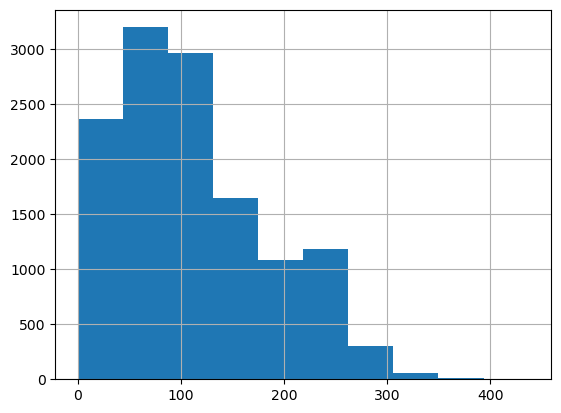

In [27]:
data.total_char.hist()

<AxesSubplot:>

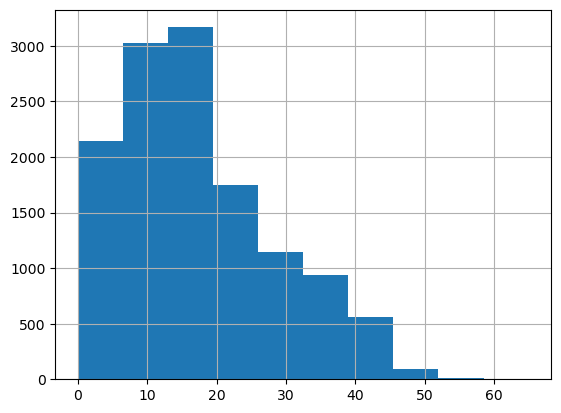

In [28]:
data.total_word.hist()

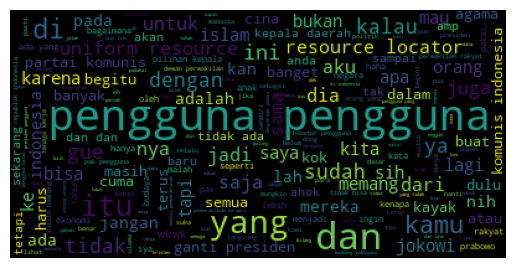

In [29]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
text = ' '.join(data['cleaned_text'])
wordcloud = WordCloud().generate(text)

#Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [30]:
data2 = pd.read_sql_query('''select * from abusivetext''', conn)
data2

,column1,column2,column3,column4,column5,column6,column7,column8,column9,column10,column11,column12,column13
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,1,1,1,0,0,0,1,0,0,1,0,0
13165,USER Kasur mana enak kunyuk',0,1,0,0,0,0,0,0,0,0,0,0
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,0,0,0,0,0,0,0,0,0,0,0,0
13167,USER USER USER USER Bom yang real mudah terdet...,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
#case folding atau merubah huruf kapital menjadi kecil

data2['text'] = data2['column1'].str.lower()
print('Case Folding Result : \n')
print(data2['text'])

Case Folding Result : 

0        - disaat semua cowok berusaha melacak perhatia...
1        rt user: user siapa yang telat ngasih tau elu?...
2        41. kadang aku berfikir, kenapa aku tetap perc...
3        user user aku itu aku\n\nku tau matamu sipit t...
4        user user kaum cebong kapir udah keliatan dong...
                               ...                        
13164    user jangan asal ngomong ndasmu. congor lu yg ...
13165                         user kasur mana enak kunyuk'
13166    user hati hati bisu :( .g\n\nlagi bosan huft \...
13167    user user user user bom yang real mudah terdet...
13168    user mana situ ngasih(": itu cuma foto ya kuti...
Name: text, Length: 13169, dtype: object


In [32]:
def remove(text):
    #remove dem
    text = re.sub(r'[\\x]+[a-z0-9]{2}', '', text)
    
    #remove RT
    text = re.sub(r'^rt[\s]+', ' ', text)
    
    #remove url
    text = re.sub(r'<.*?>', r' ', text)
    
    #remove tandabaca
    text = re.sub(r'[^\w\s\d]', ' ', text)
    
    #remove number
    text = re.sub(r'\d+', ' ', text)
    
    #remove hastag
    text = re.sub(r'#\w+',' ', text)
    
    #remove user
    text = re.sub(r'^user[\s]+', '', text)
    
    #only alphabet
    text = re.sub(r'[^A-Za-z]+', ' ', text)
    
    #remove white space
    text = ' '.join(text.split())
    return text
data2['remove_dem'] = data2['text'].apply(remove)

In [47]:
replacing_word = pd.read_csv("new_kamusalay.csv", encoding='latin-1')

replacing_word_dict={}
for index, row in replacing_word.iterrows():
    if row[0] not in replacing_word_dict:
        replacing_word_dict[row[0]] = row[1]
        
def replacing_term(document):
    return[replacing_word_dict[term] if term in replacing_word_dict else term for term in document]

data2['tweet'] = data2['remove_dem'].apply(lambda x: ''.join(x))
data2.head(5)

,remove_dem,tweet
0,disaat semua cowok berusaha melacak perhatian ...,disaat semua cowok berusaha melacak perhatian ...
1,user user siapa yang telat ngasih tau elu edan...,user user siapa yang telat ngasih tau elu edan...
2,kadang aku berfikir kenapa aku tetap percaya p...,kadang aku berfikir kenapa aku tetap percaya p...
3,user aku itu aku nu tau matamu sipit tapi dili...,user aku itu aku nu tau matamu sipit tapi dili...
4,user kaum cebong kapir udah keliatan dongoknya...,user kaum cebong kapir udah keliatan dongoknya...


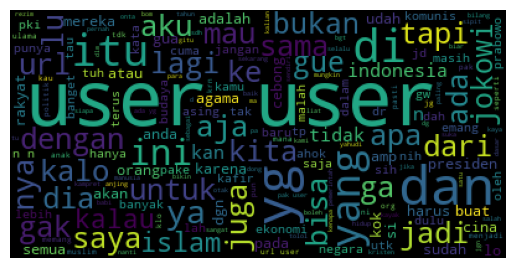

In [48]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
text = ' '.join(data2['tweet'])
wordcloud = WordCloud().generate(text)

#Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.show()